# Influence optical parameters on the LCE

In [1]:
## Imports:

import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec            # to arrange the plots nicely
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import concurrent.futures
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from numpy import exp
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

In [2]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
## PMT properties and physics:

QE_PMT0 = 0.325
QE_PMT1 = 0.3
QE_PMT2 = 0.3
QE_PMT3 = 0.3
QE_PMT4 = 0.3
QE_PMT5 = 0.3
QE_PMT6 = 0.3
QE_PMT7 = 0.3
QE_Bottom = QE_PMT0
QE_Top = 0.3

CE_PMT0 = 0.95
CE_PMT1 = 0.7
CE_PMT2 = 0.7
CE_PMT3 = 0.7
CE_PMT4 = 0.7
CE_PMT5 = 0.7
CE_PMT6 = 0.7
CE_PMT7 = 0.7
CE_Bottom = CE_PMT0
CE_Top = 0.7

W = 1/(1302.808447/32.1517) # 1/W = photons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/W  = '+str(1/W)+' ph/keV')
We = 1/(1045.457843/32.1517) # 1/W = electrons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/We = '+str(1/We)+' e/keV')

W0 = 1/(2195.519/32.1517) # 1/W = photons/keV @ 32.1517 keV, 0.0001 V/cm, ER
print('1/W0  = '+str(1/W0)+' ph/keV')

1/W  = 40.52067066438166 ph/keV
1/We = 32.51640949001141 e/keV
1/W0  = 68.28624924965087 ph/keV


## Imports and data processing

In [4]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters

optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs0.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.85.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.8.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.93.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.97.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.999.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.85.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.8.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.93.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.97.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.999.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs10.root


In [38]:
b_preprocessed = True

if b_preprocessed == False:
    
    ## Selection of path with files to be analysed
    from os import listdir
    from os.path import isfile, join
    path = "/media/ab602/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters"
    files = [f for f in listdir(path) if isfile(join(path, f))]
    #files = files[0:3]

    ## Initialize empty dataframe
    opticals = pd.DataFrame({'RPTFE' : [], 'LXeAbs' : [], 'Tmesh' : [], 'LCE_b' : [],'LCE_t' : [],'LCE_a' : []})

    counter = 0
    for file in files:

        ## Selection of file to be analyzed:
        #file = "optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100.root"
        filename = path+"/"+file
        #filenameprefix = file[:-5]    
        #print(filenameprefix)

        ## Extraction of optical parameters from filename
        RPTFE = float(file[file.find("RPTFE")+5 : file.find("_", file.find("RPTFE")+5)])
        if file.find("Tmesh") is -1:
            LXeAbs = float(file[file.find("LXeAbs")+6 : file.find(".root")])
            Tmesh = 0.89770509
        if file.find("Tmesh") is not -1:
            LXeAbs = float(file[file.find("LXeAbs")+6 : file.find("_", file.find("LXeAbs")+6)])
            Tmesh = float(file[file.find("Tmesh")+5 : file.find(".root")])

        ## Import as pandas dataframes and write to compressed dataframe
        branches= ['nbpmthits','ntpmthits'] # Be careful that the branches are also initilized in _chunk_collect
        executor = concurrent.futures.ThreadPoolExecutor(8)
        _chunk_collect = pd.DataFrame({'nbpmthits' : [],'ntpmthits' : []}) # Initialize empty data frame
        for _chunk in uproot.iterate(filename, "events/events",branches, entrysteps=100000, 
                                               outputtype=pd.DataFrame, executor=executor):
            _chunk.columns=branches
            _chunk_collect = _chunk_collect.append(_chunk)
        LCE_b = _chunk_collect["nbpmthits"].mean()
        LCE_t = _chunk_collect["ntpmthits"].mean()
        LCE_a = LCE_b + LCE_t
        opticals = opticals.append(pd.DataFrame({'RPTFE' : [RPTFE], 'LXeAbs' : [LXeAbs], 'Tmesh' : [Tmesh], 'LCE_b' : [LCE_b],'LCE_t' : [LCE_t],'LCE_a' : [LCE_a]}), ignore_index=True)
        del(_chunk)
        del(_chunk_collect)
        
        counter += 1
        print(str(round(100*counter / len(files),1))+'%', end = ' ')

    ## Derive DE and LY
    opticals['DE_b'] = opticals['LCE_b'] * QE_Bottom * CE_Bottom
    opticals['DE_t'] = opticals['LCE_t'] * QE_Top * CE_Top
    opticals['DE_a'] = opticals['DE_b'] + opticals['DE_t']
    opticals['LY_b'] = opticals['DE_b']/W
    opticals['LY_t'] = opticals['DE_t']/W
    opticals['LY_a'] = opticals['LY_b'] + opticals['LY_t']
    opticals['LY0_b'] = opticals['DE_b']/W0
    opticals['LY0_t'] = opticals['DE_t']/W0
    opticals['LY0_a'] = opticals['LY0_b'] + opticals['LY0_t']

    ## Save to pickle file
    opticals.to_pickle("Influence_optical_parameters.pkl")

if b_preprocessed == True:
    opticals = pd.read_pickle("output/Influence_optical_parameters.pkl")

print('Done.')
opticals

Done.


RPTFE  LXeAbs     Tmesh     LCE_b     LCE_t     LCE_a      DE_b      DE_t  \
0    0.95     0.0  0.897705  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.95    10.0  0.897705  0.097393  0.018043  0.115435  0.030070  0.003789   
2    0.95   100.0  0.897705  0.257016  0.038375  0.295391  0.079354  0.008059   
3    0.95  1000.0  0.897705  0.299144  0.043583  0.342727  0.092361  0.009152   
4    0.95  1000.0  0.800000  0.225156  0.024250  0.249406  0.069517  0.005092   
5    0.95  1000.0  0.850000  0.258456  0.032476  0.290932  0.079798  0.006820   
6    0.95  1000.0  0.897705  0.299272  0.043511  0.342783  0.092400  0.009137   
7    0.95  1000.0  0.930000  0.334337  0.053568  0.387905  0.103226  0.011249   
8    0.95  1000.0  0.970000  0.393267  0.071005  0.464272  0.121421  0.014911   
9    0.95  1000.0  0.999000  0.454888  0.089870  0.544758  0.140447  0.018873   
10   0.95   100.0  0.800000  0.197086  0.021861  0.218947  0.060850  0.004591   
11   0.95   100.0  0.850000  0.224800  0.028997  0.253798  0.069407  0.006089   
12   0.95   100.0  0.897705  0.256802  0.038439  0.295241  0.079288  0.008072   
13   0.95   100.0  0.930000  0.284239  0.046755  0.330994  0.087759  0.009819   
14   0.95   100.0  0.970000  0.328036  0.060897  0.388934  0.101281  0.012788   
15   0.95   100.0  0.999000  0.371321  0.075250  0.446571  0.114645  0.015802   
16   0.95    20.0  0.897705  0.153423  0.025579  0.179002  0.047369  0.005372   
17   0.95   200.0  0.897705  0.279060  0.041033  0.320093  0.086160  0.008617   
18   0.95  2000.0  0.897705  0.301952  0.043798  0.345751  0.093228  0.009198   
19   0.99   200.0  0.897705  0.310778  0.045931  0.356708  0.095953  0.009645   
20   0.99  2000.0  0.897705  0.339247  0.049456  0.388703  0.104743  0.010386   
21   0.99    30.0  0.897705  0.199815  0.032057  0.231872  0.061693  0.006732   
22   0.99   300.0  0.897705  0.320725  0.047086  0.367811  0.099024  0.009888   
23   0.99    40.0  0.897705  0.223895  0.035110  0.259005  0.069128  0.007373   
24   0.99   400.0  0.897705  0.325833  0.047784  0.373617  0.100601  0.010035   
25   0.99    50.0  0.897705  0.241254  0.037273  0.278527  0.074487  0.007827   
26   0.99   500.0  0.897705  0.329187  0.048008  0.377196  0.101637  0.010082   
27   0.99  5000.0  0.897705  0.341483  0.049565  0.391048  0.105433  0.010409   
28   0.90     0.0  0.897705  0.000000  0.000000  0.000000  0.000000  0.000000   
29   0.90    10.0  0.897705  0.092703  0.017048  0.109751  0.028622  0.003580   
..    ...     ...       ...       ...       ...       ...       ...       ...   
36   0.95  5000.0  0.897705  0.303739  0.044092  0.347832  0.093780  0.009259   
37   0.99     0.0  0.897705  0.000000  0.000000  0.000000  0.000000  0.000000   
38   0.99    10.0  0.897705  0.101476  0.019007  0.120482  0.031331  0.003991   
39   0.99   100.0  0.897705  0.283778  0.042587  0.326366  0.087617  0.008943   
40   0.99  1000.0  0.897705  0.335930  0.048996  0.384926  0.103719  0.010289   
41   0.95    30.0  0.897705  0.185808  0.029637  0.215445  0.057368  0.006224   
42   0.99  1000.0  0.800000  0.247572  0.026464  0.274036  0.076438  0.005557   
43   0.99    20.0  0.897705  0.163186  0.027267  0.190453  0.050384  0.005726   
44   0.90  1000.0  0.897705  0.262442  0.038299  0.300741  0.081029  0.008043   
45   0.99  1000.0  0.850000  0.286727  0.036006  0.322733  0.088527  0.007561   
46   0.99  1000.0  0.897705  0.335712  0.048976  0.384688  0.103651  0.010285   
47   0.99  1000.0  0.930000  0.379783  0.061068  0.440851  0.117258  0.012824   
48   0.99  1000.0  0.970000  0.456470  0.083059  0.539529  0.140935  0.017442   
49   0.99  1000.0  0.999000  0.541046  0.108067  0.649114  0.167048  0.022694   
50   0.99   100.0  0.800000  0.214596  0.023694  0.238290  0.066257  0.004976   
51   0.99   100.0  0.850000  0.246021  0.031800  0.277821  0.075959  0.006678   
52   0.99   100.0  0.897705  0.283901  0.042433  0.326335  0.087654  0.008911   
53   0.99   100.0  0.930000  0.3163

## Influence of the PTFE Reflectivity on the LCE

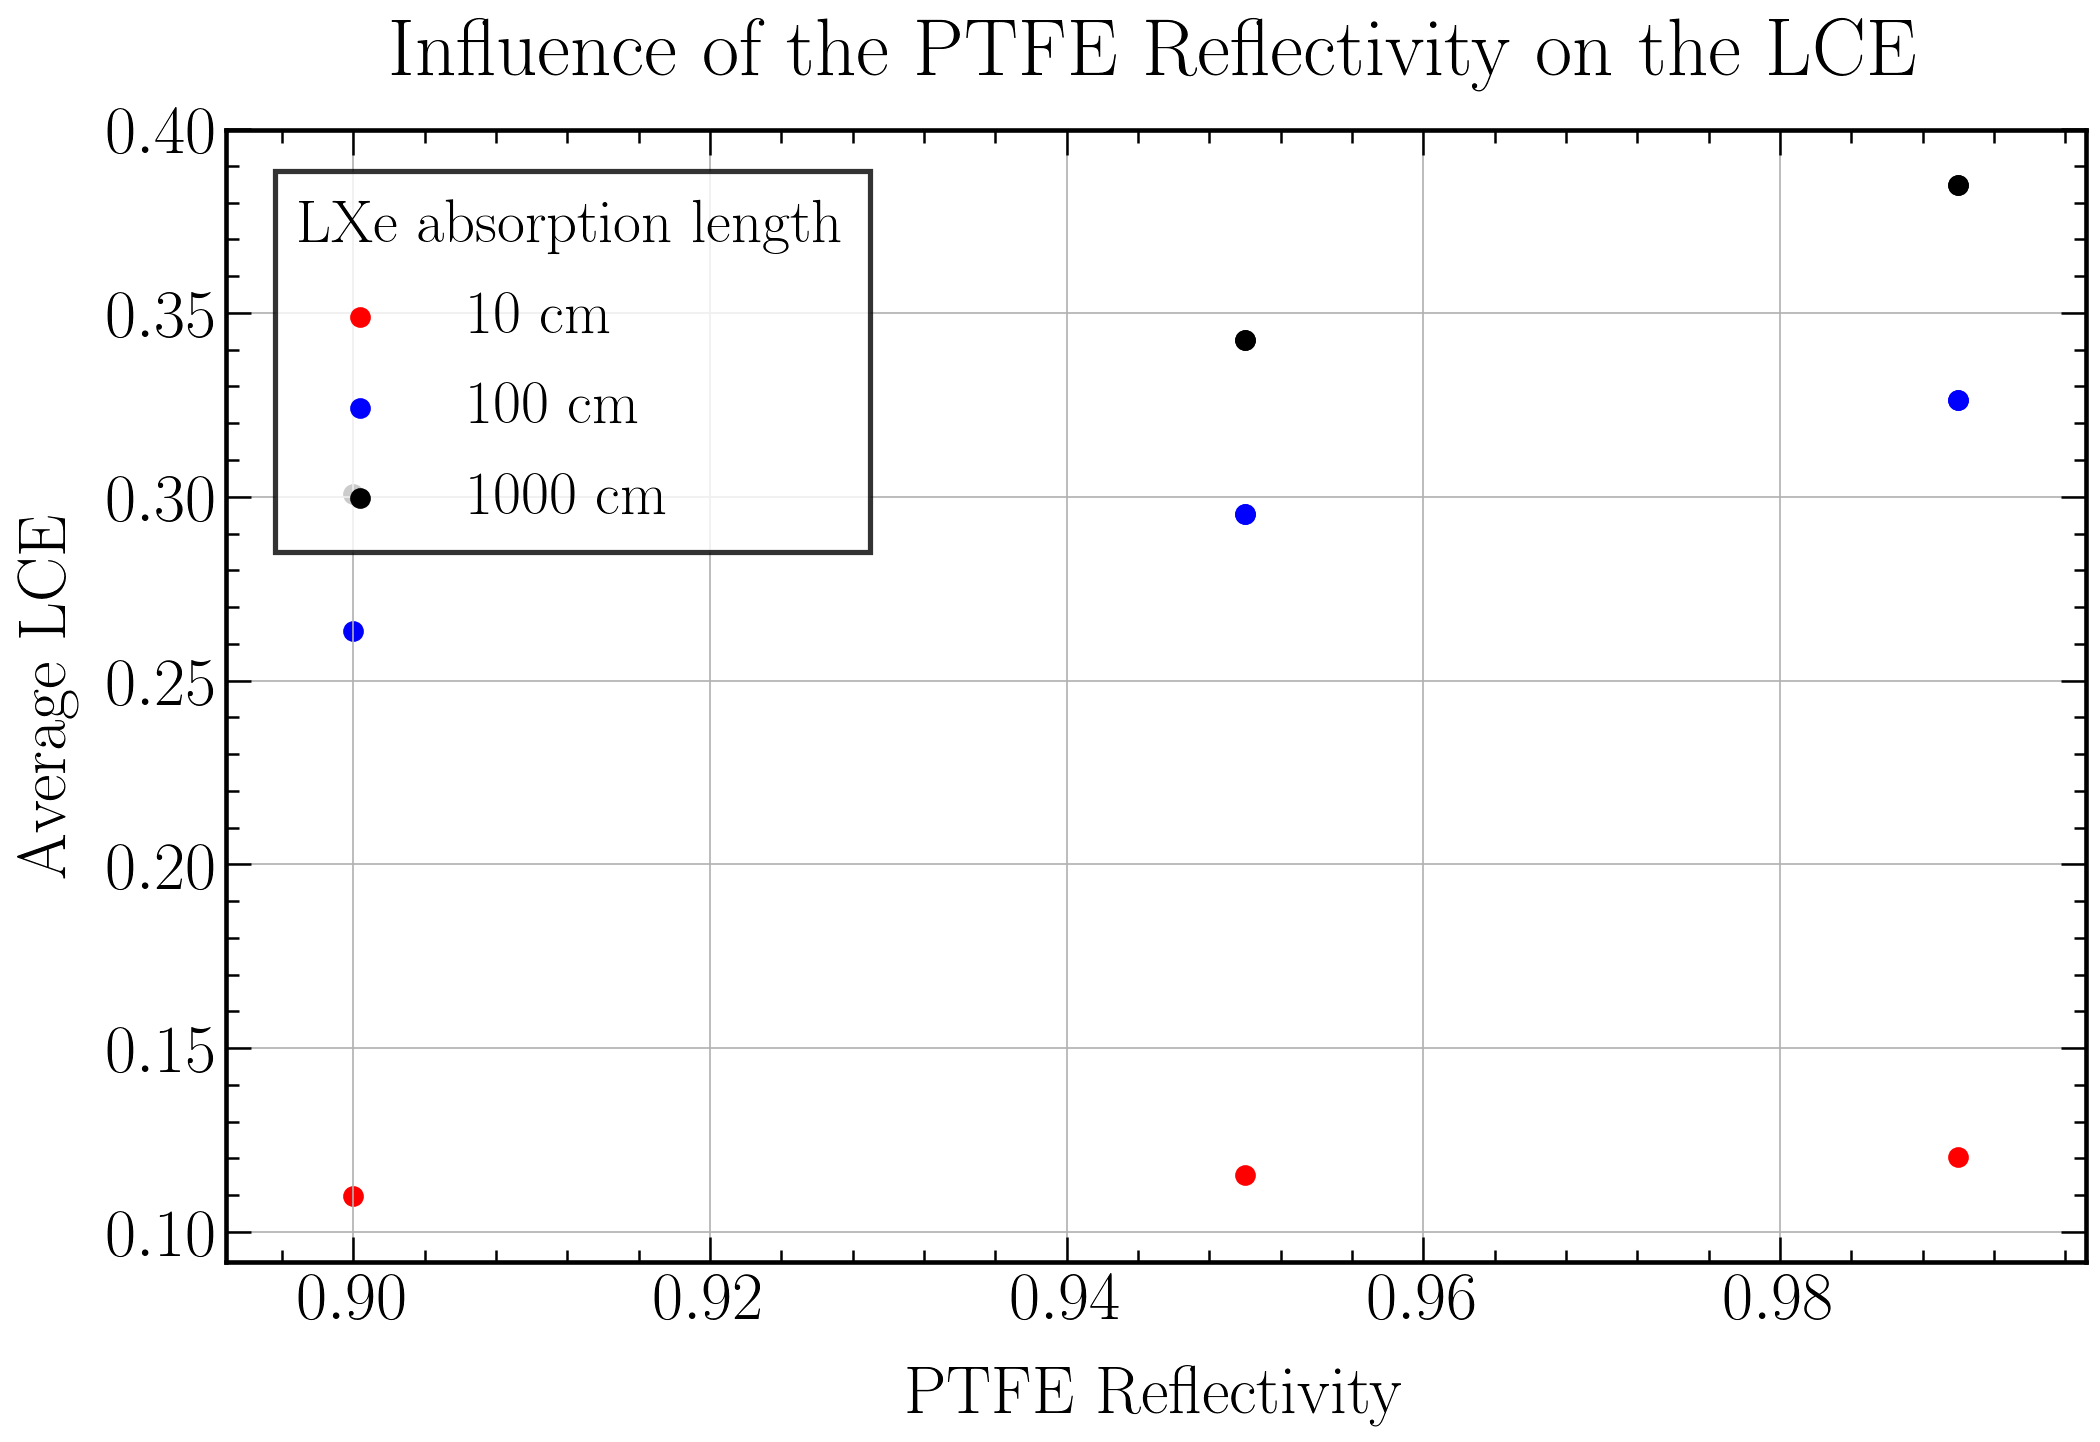

In [6]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the LCE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="LXe absorption length", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.0,0.4)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_LCE.png")
plt.show()

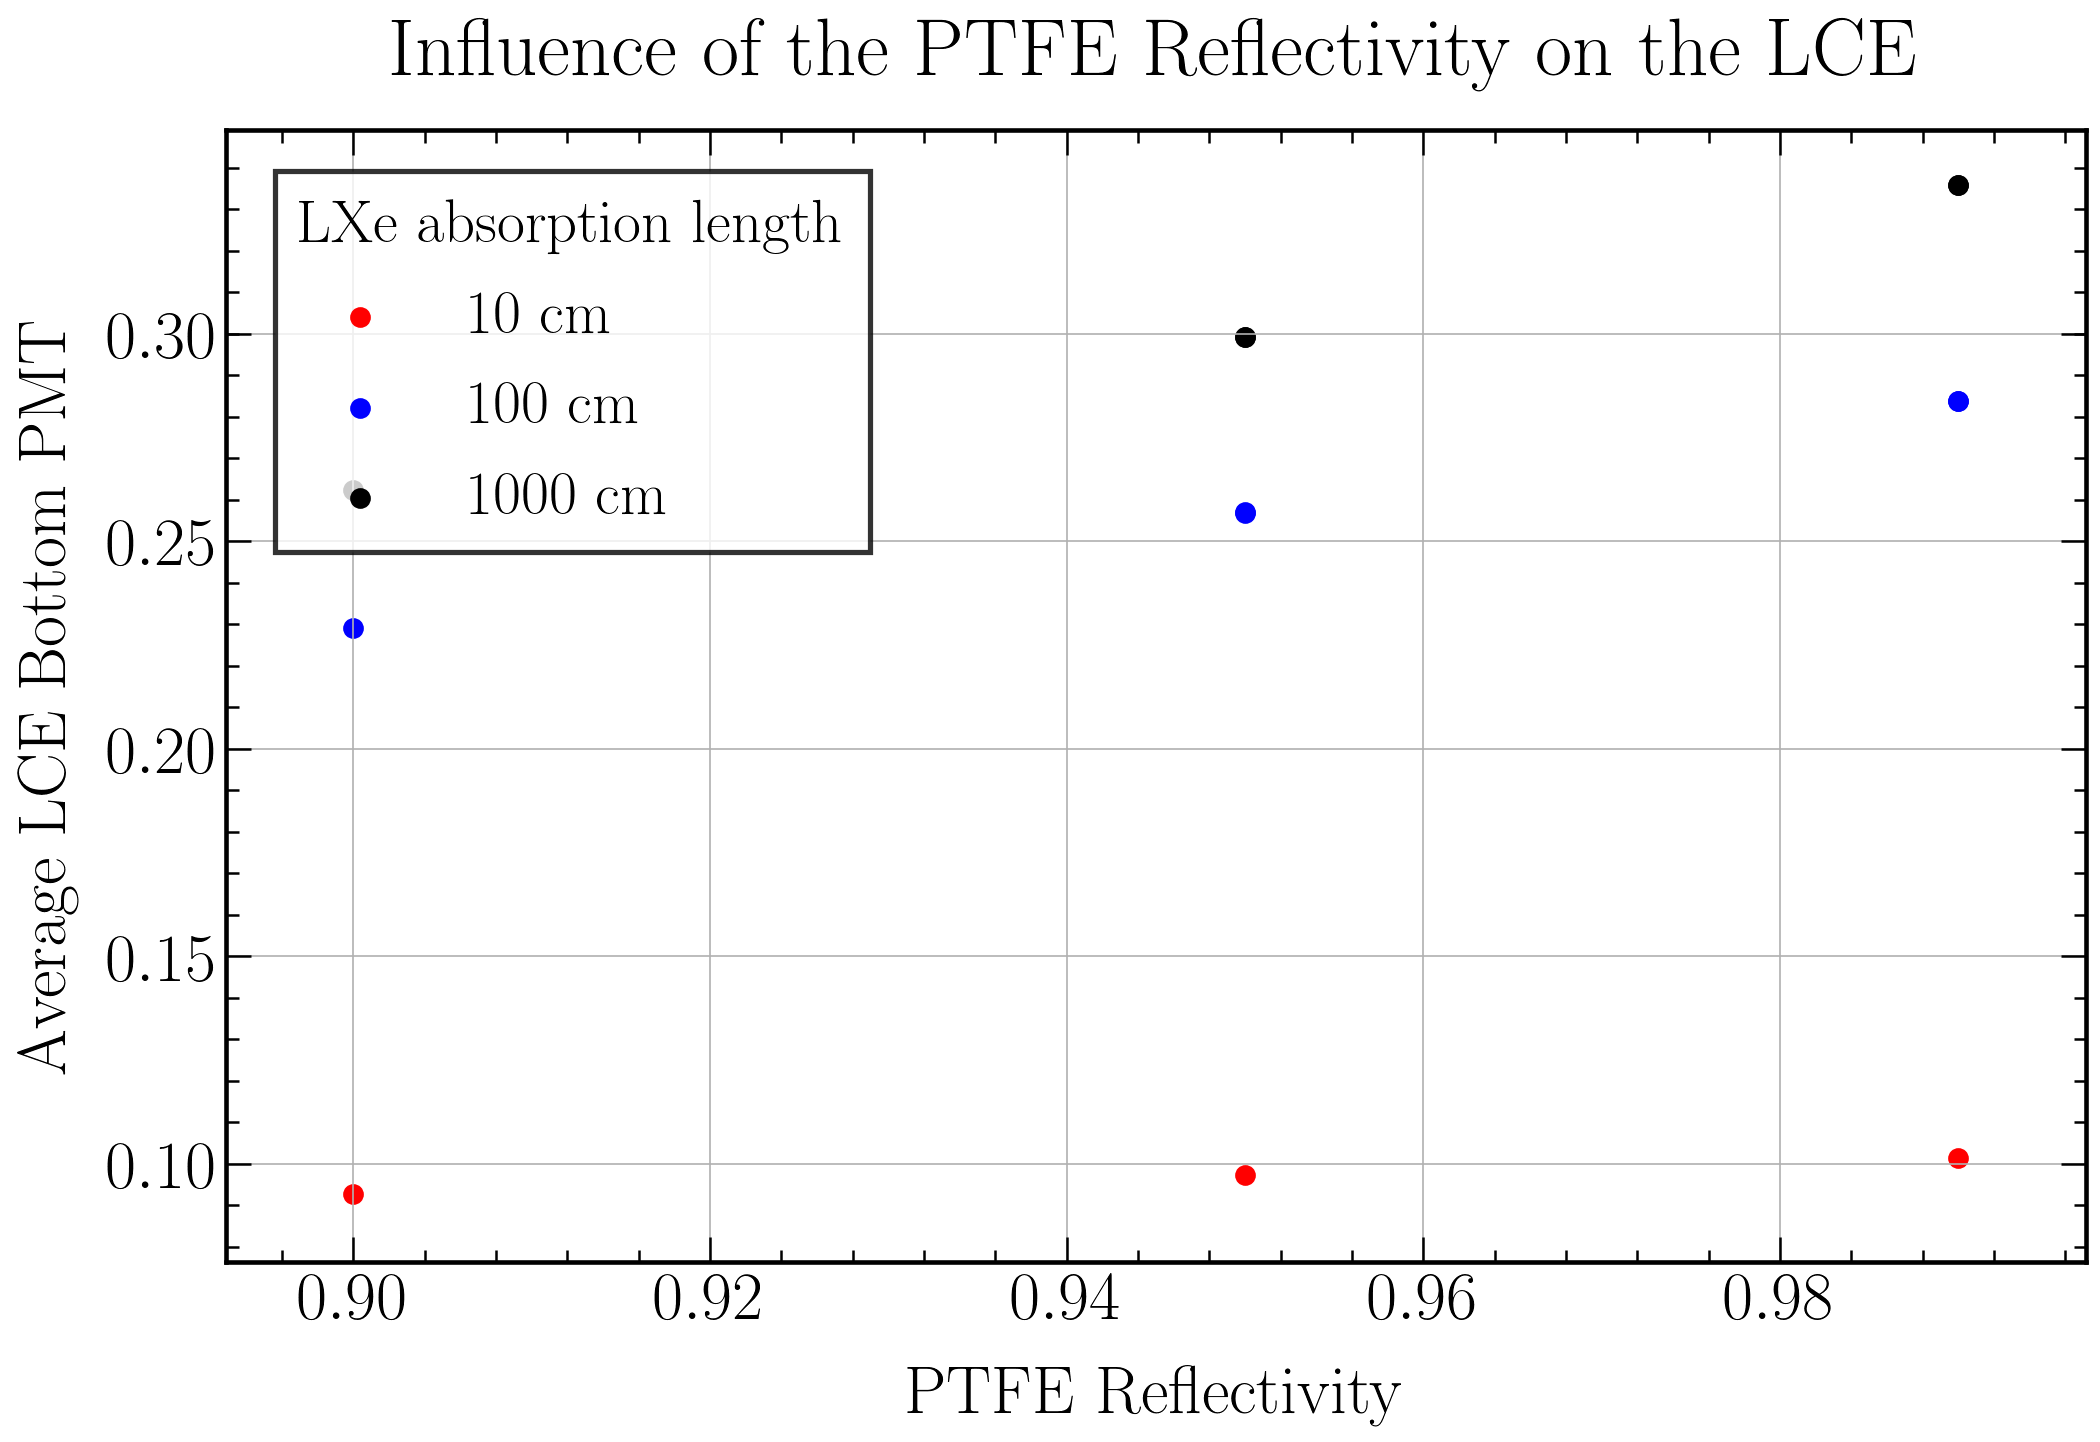

In [7]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the LCE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="LXe absorption length", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.0,0.4)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_LCE_Bottom.png")
plt.show()

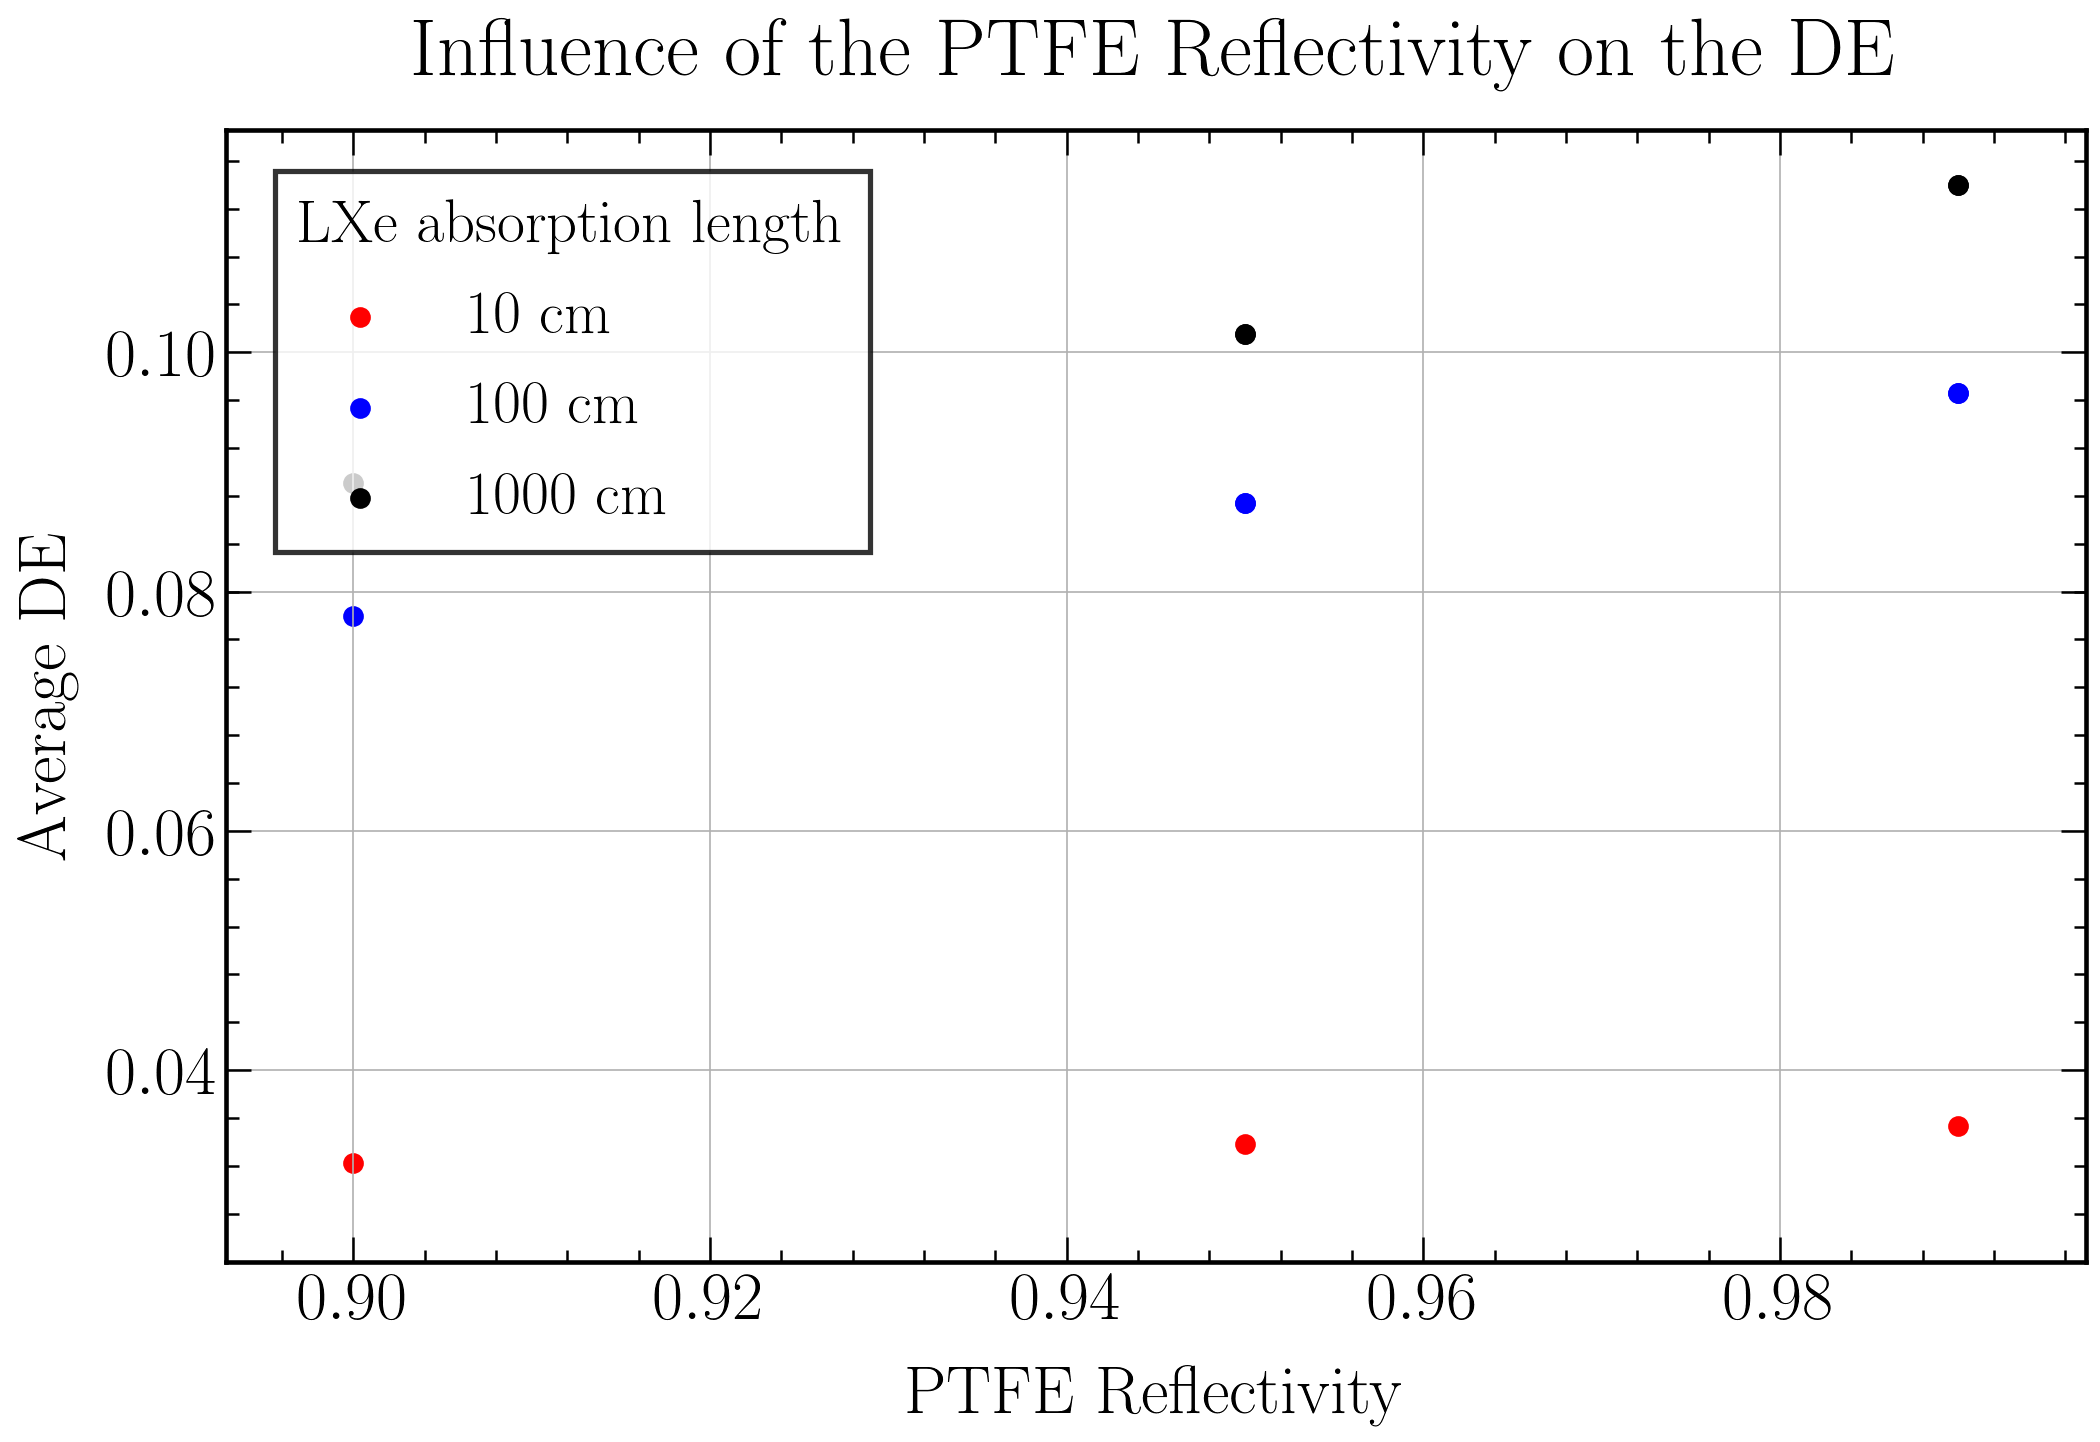

In [8]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the DE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="LXe absorption length", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.02,0.104)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_DE.png")
plt.show()

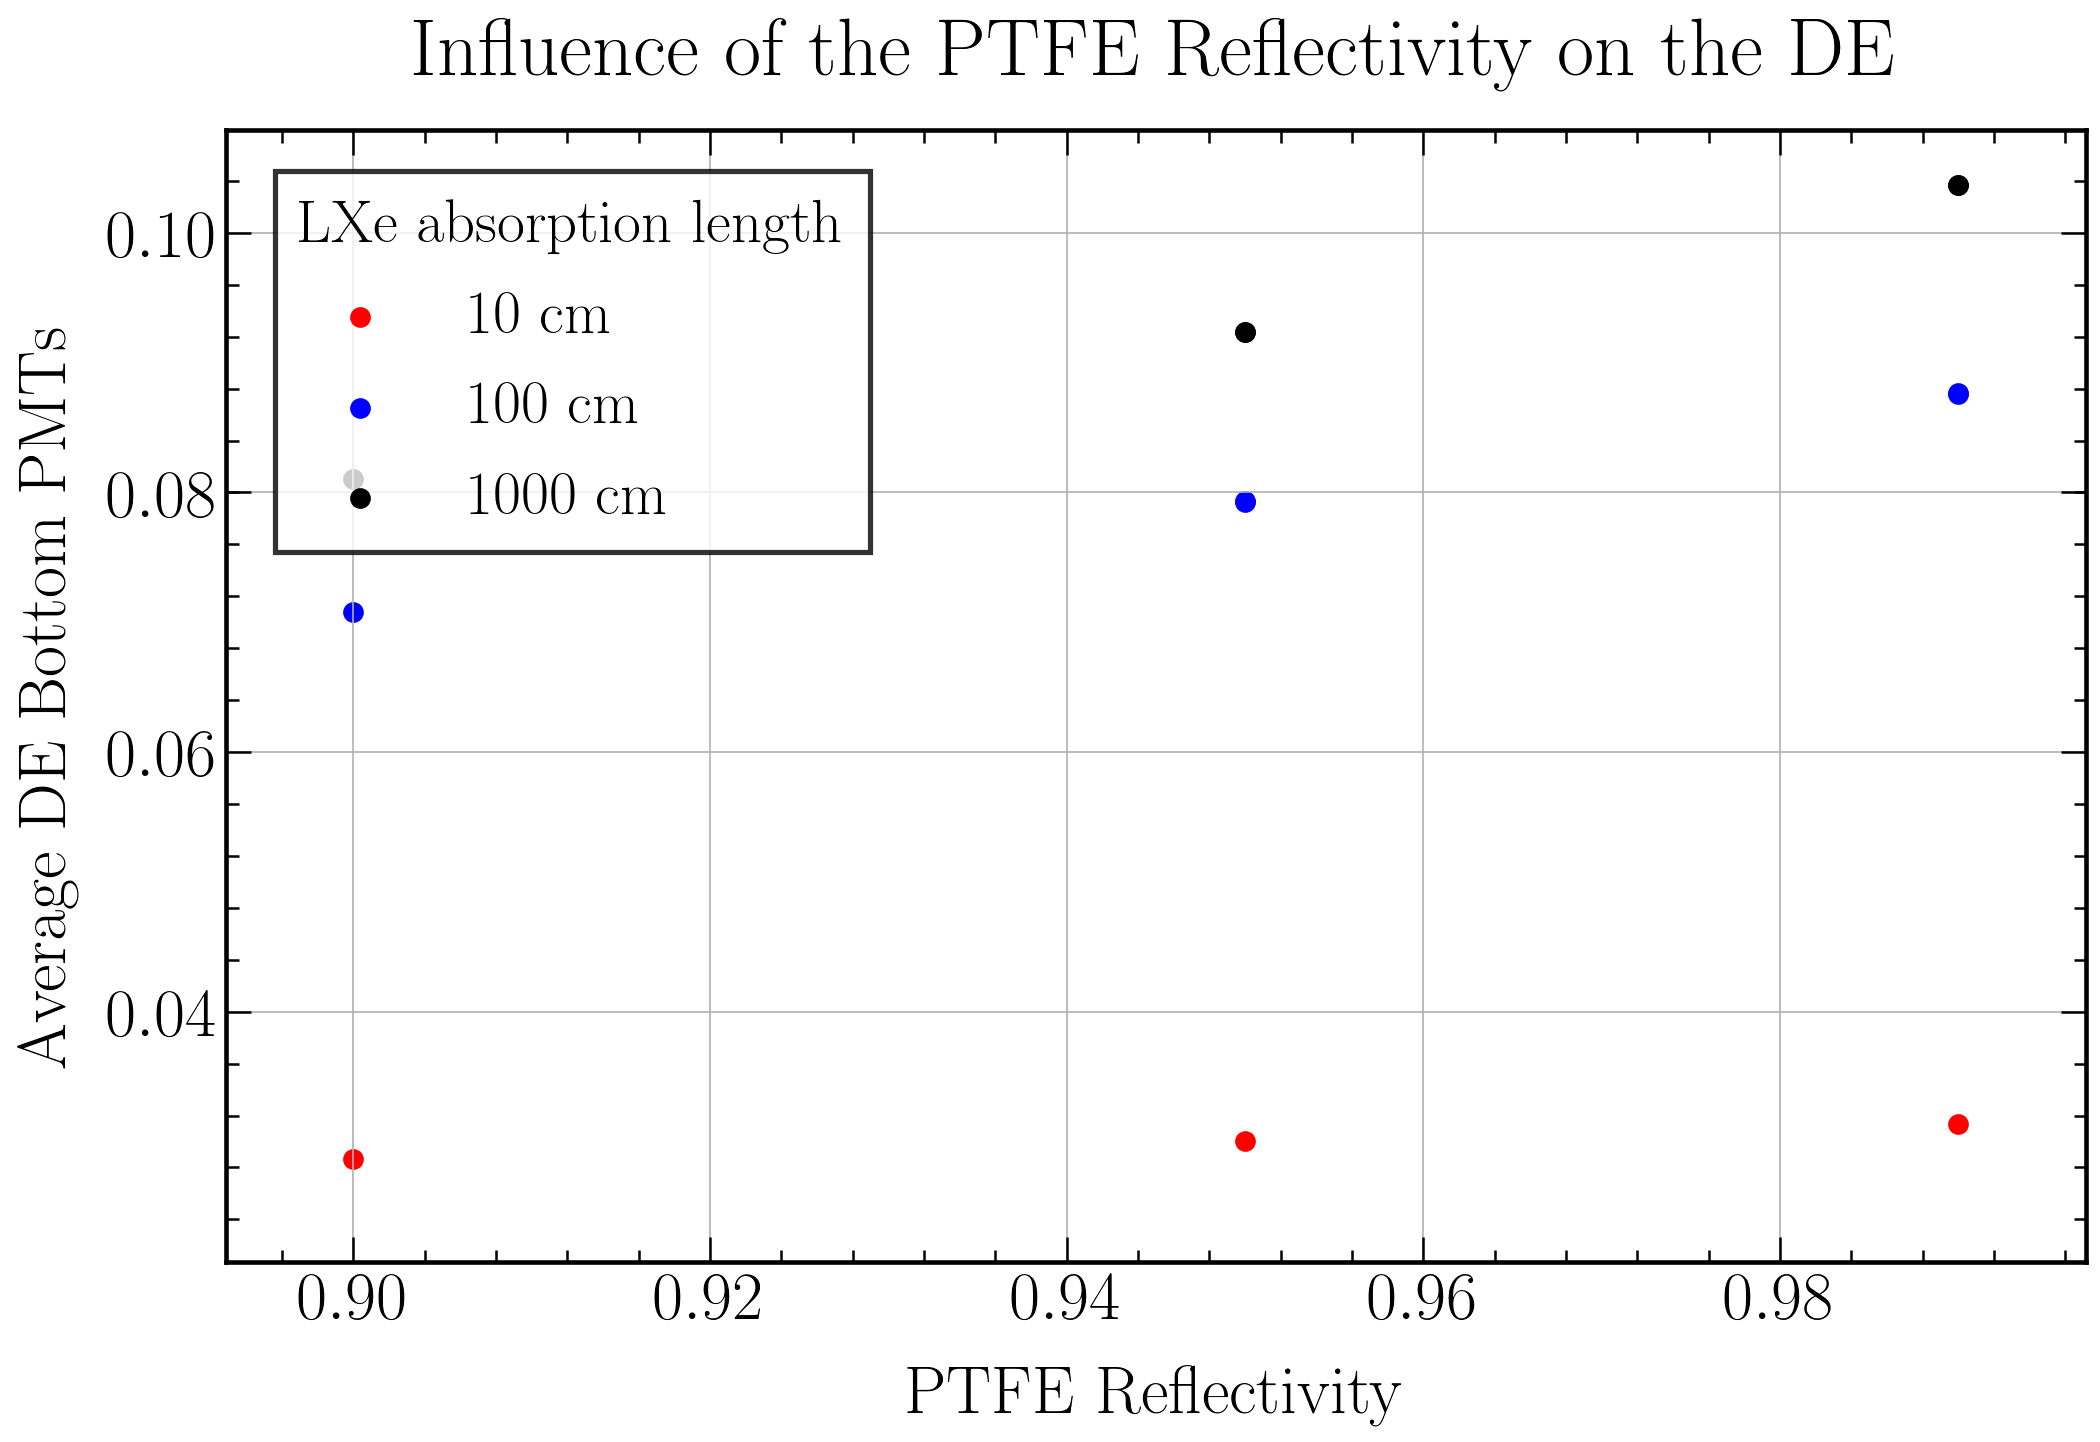

In [9]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMTs', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the DE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="LXe absorption length", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.02,0.104)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_DE_Bottom.png")
plt.show()

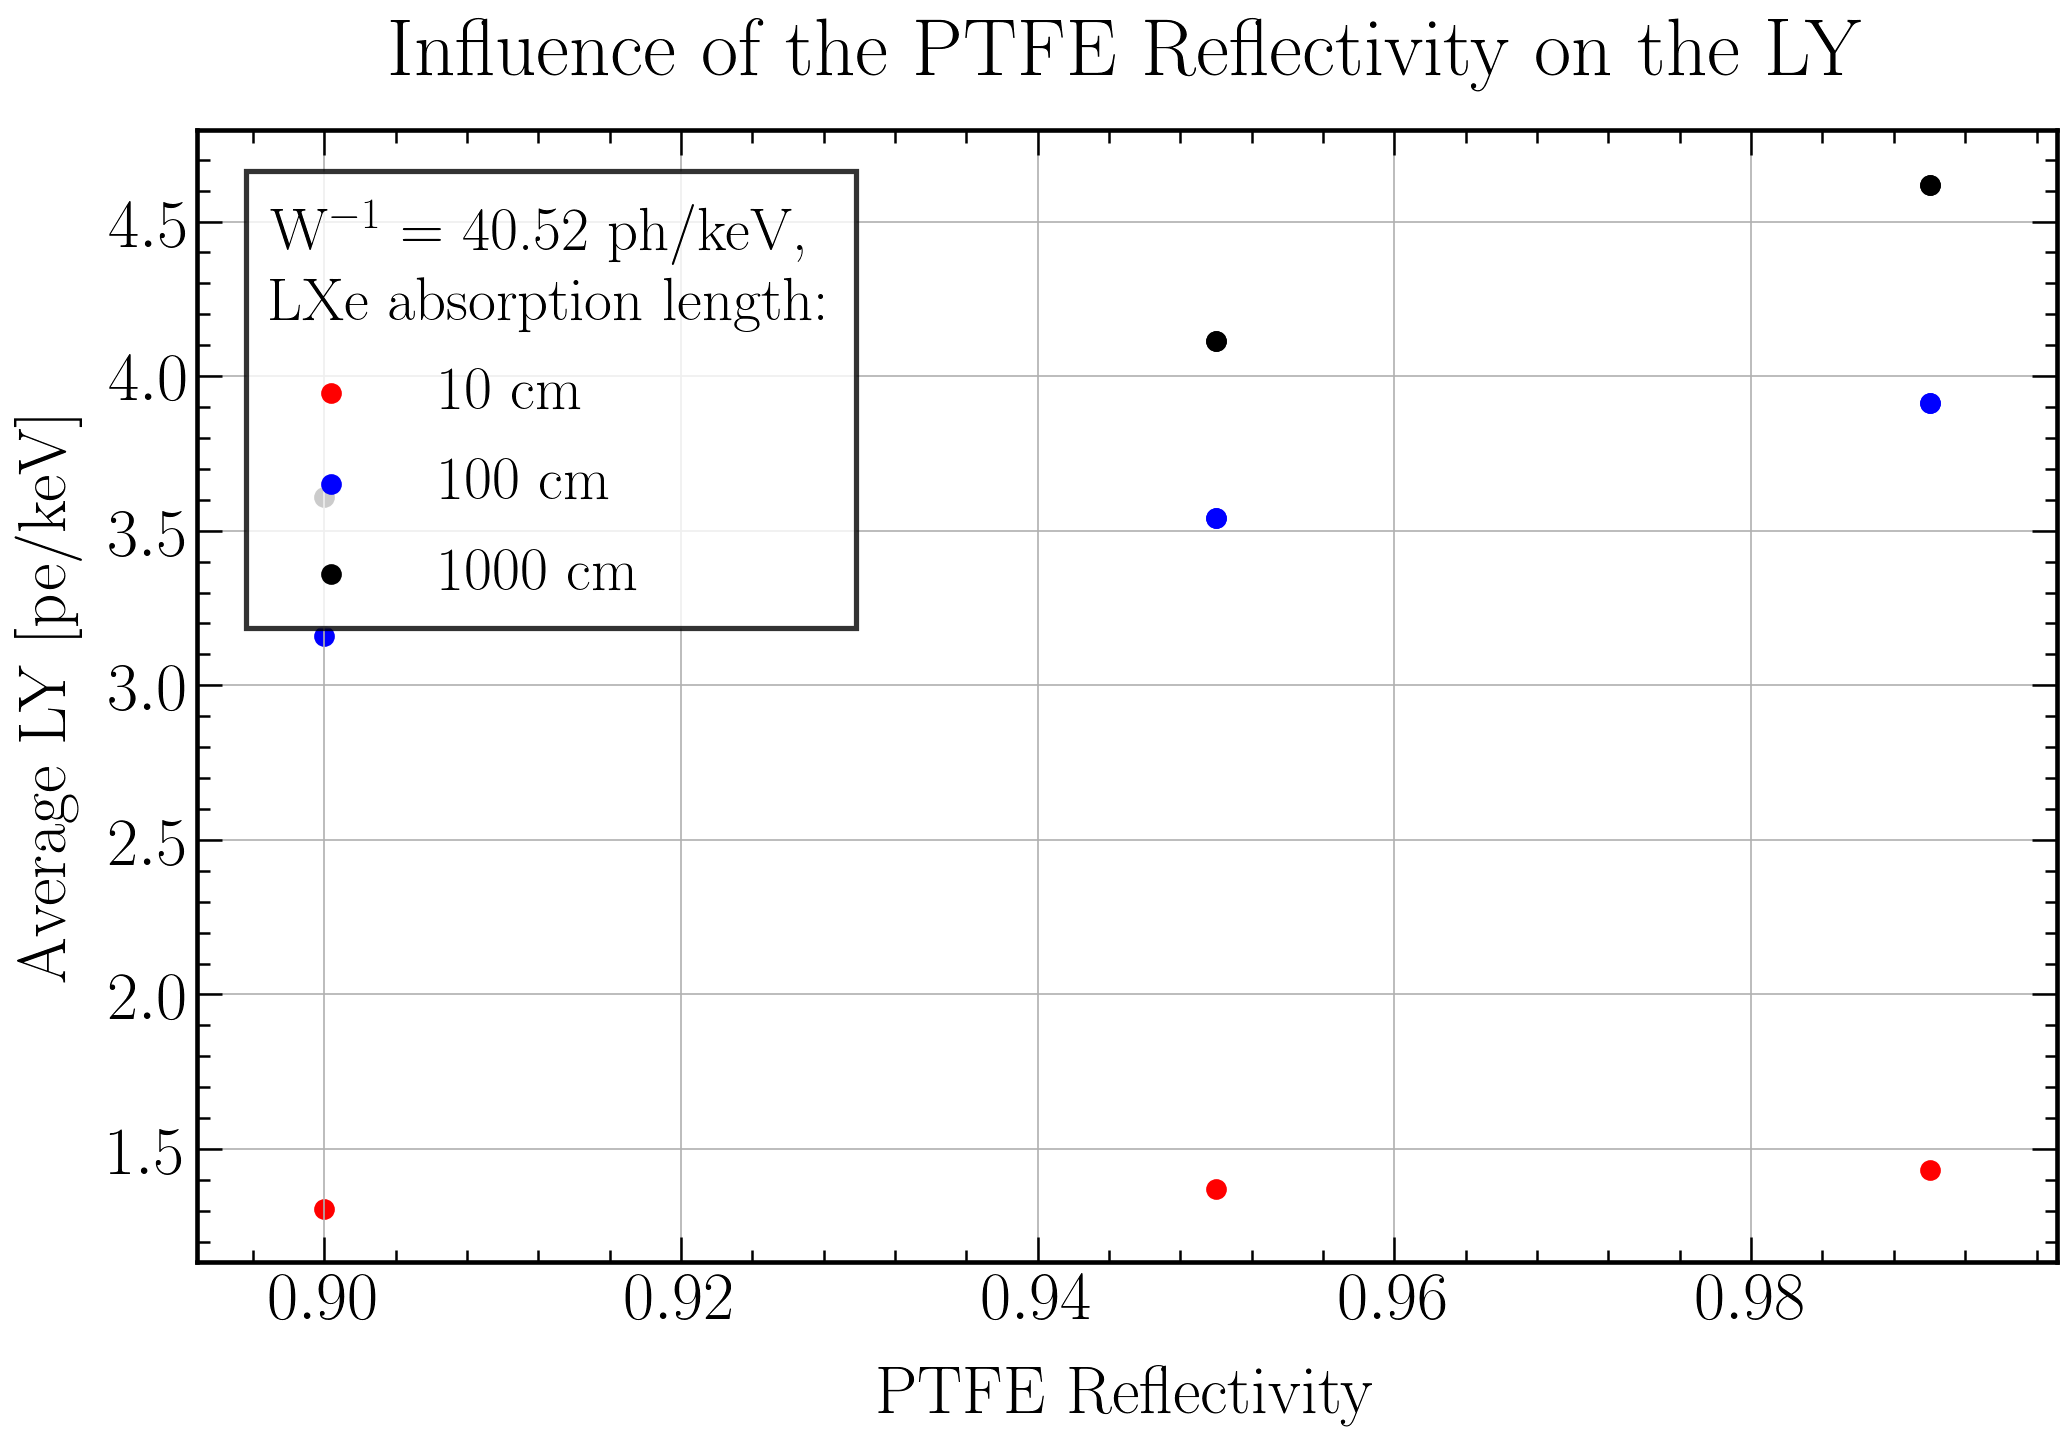

In [10]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"LXe absorption length:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.02,0.104)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_LY.png")
plt.show()

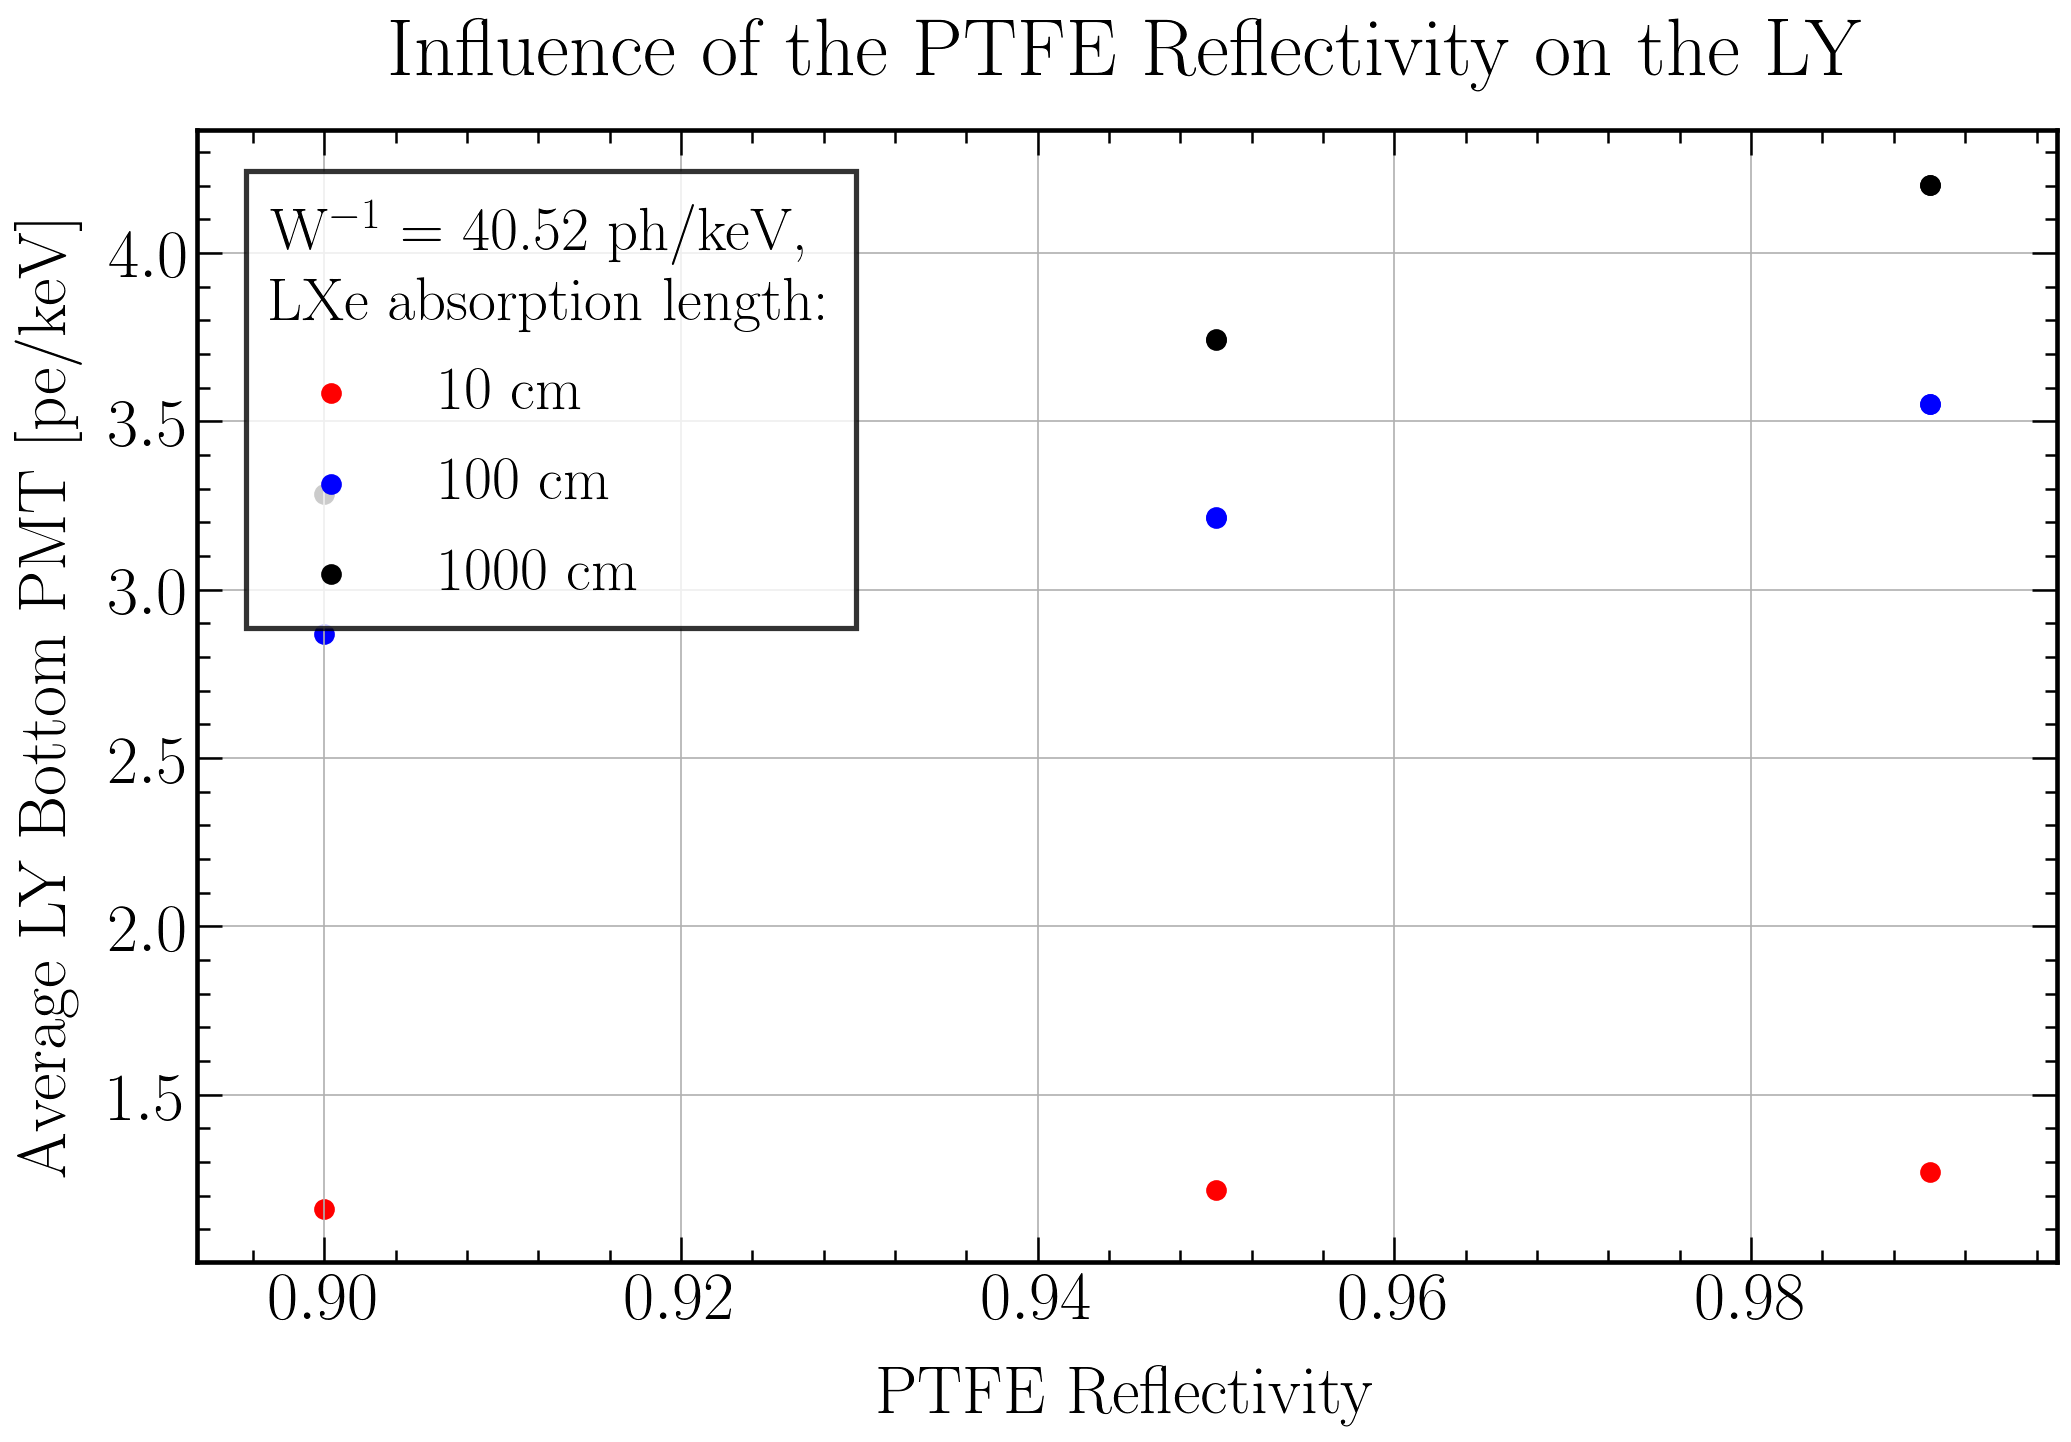

In [11]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"LXe absorption length:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.02,0.104)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_LY_Bottom.png")
plt.show()

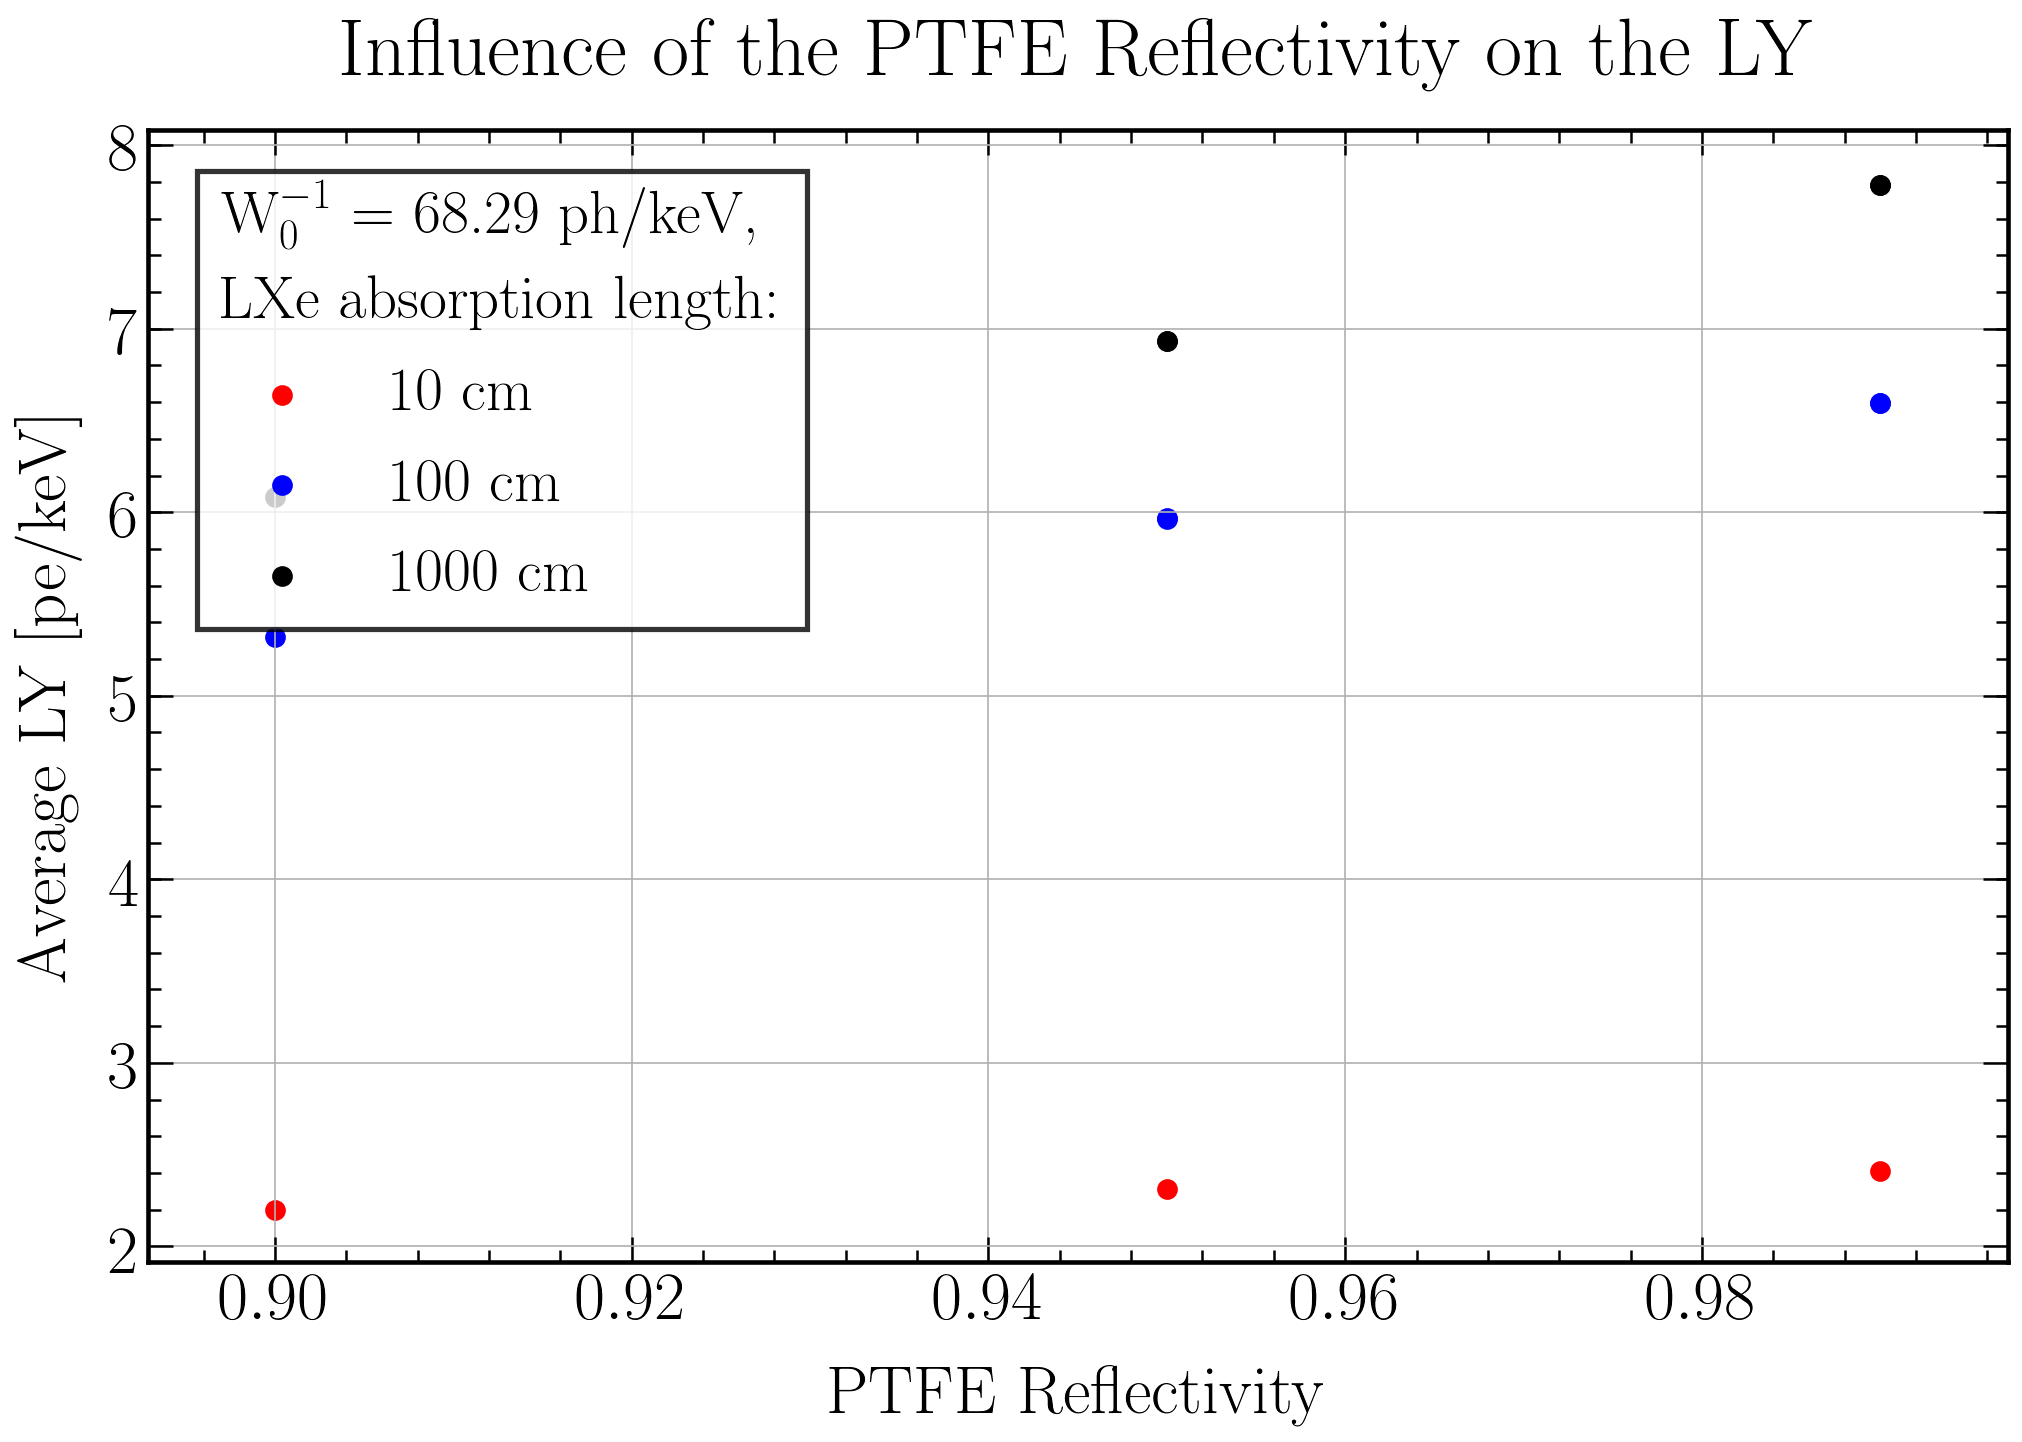

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\n"+"LXe absorption length:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.02,0.104)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_LY0.png")
plt.show()

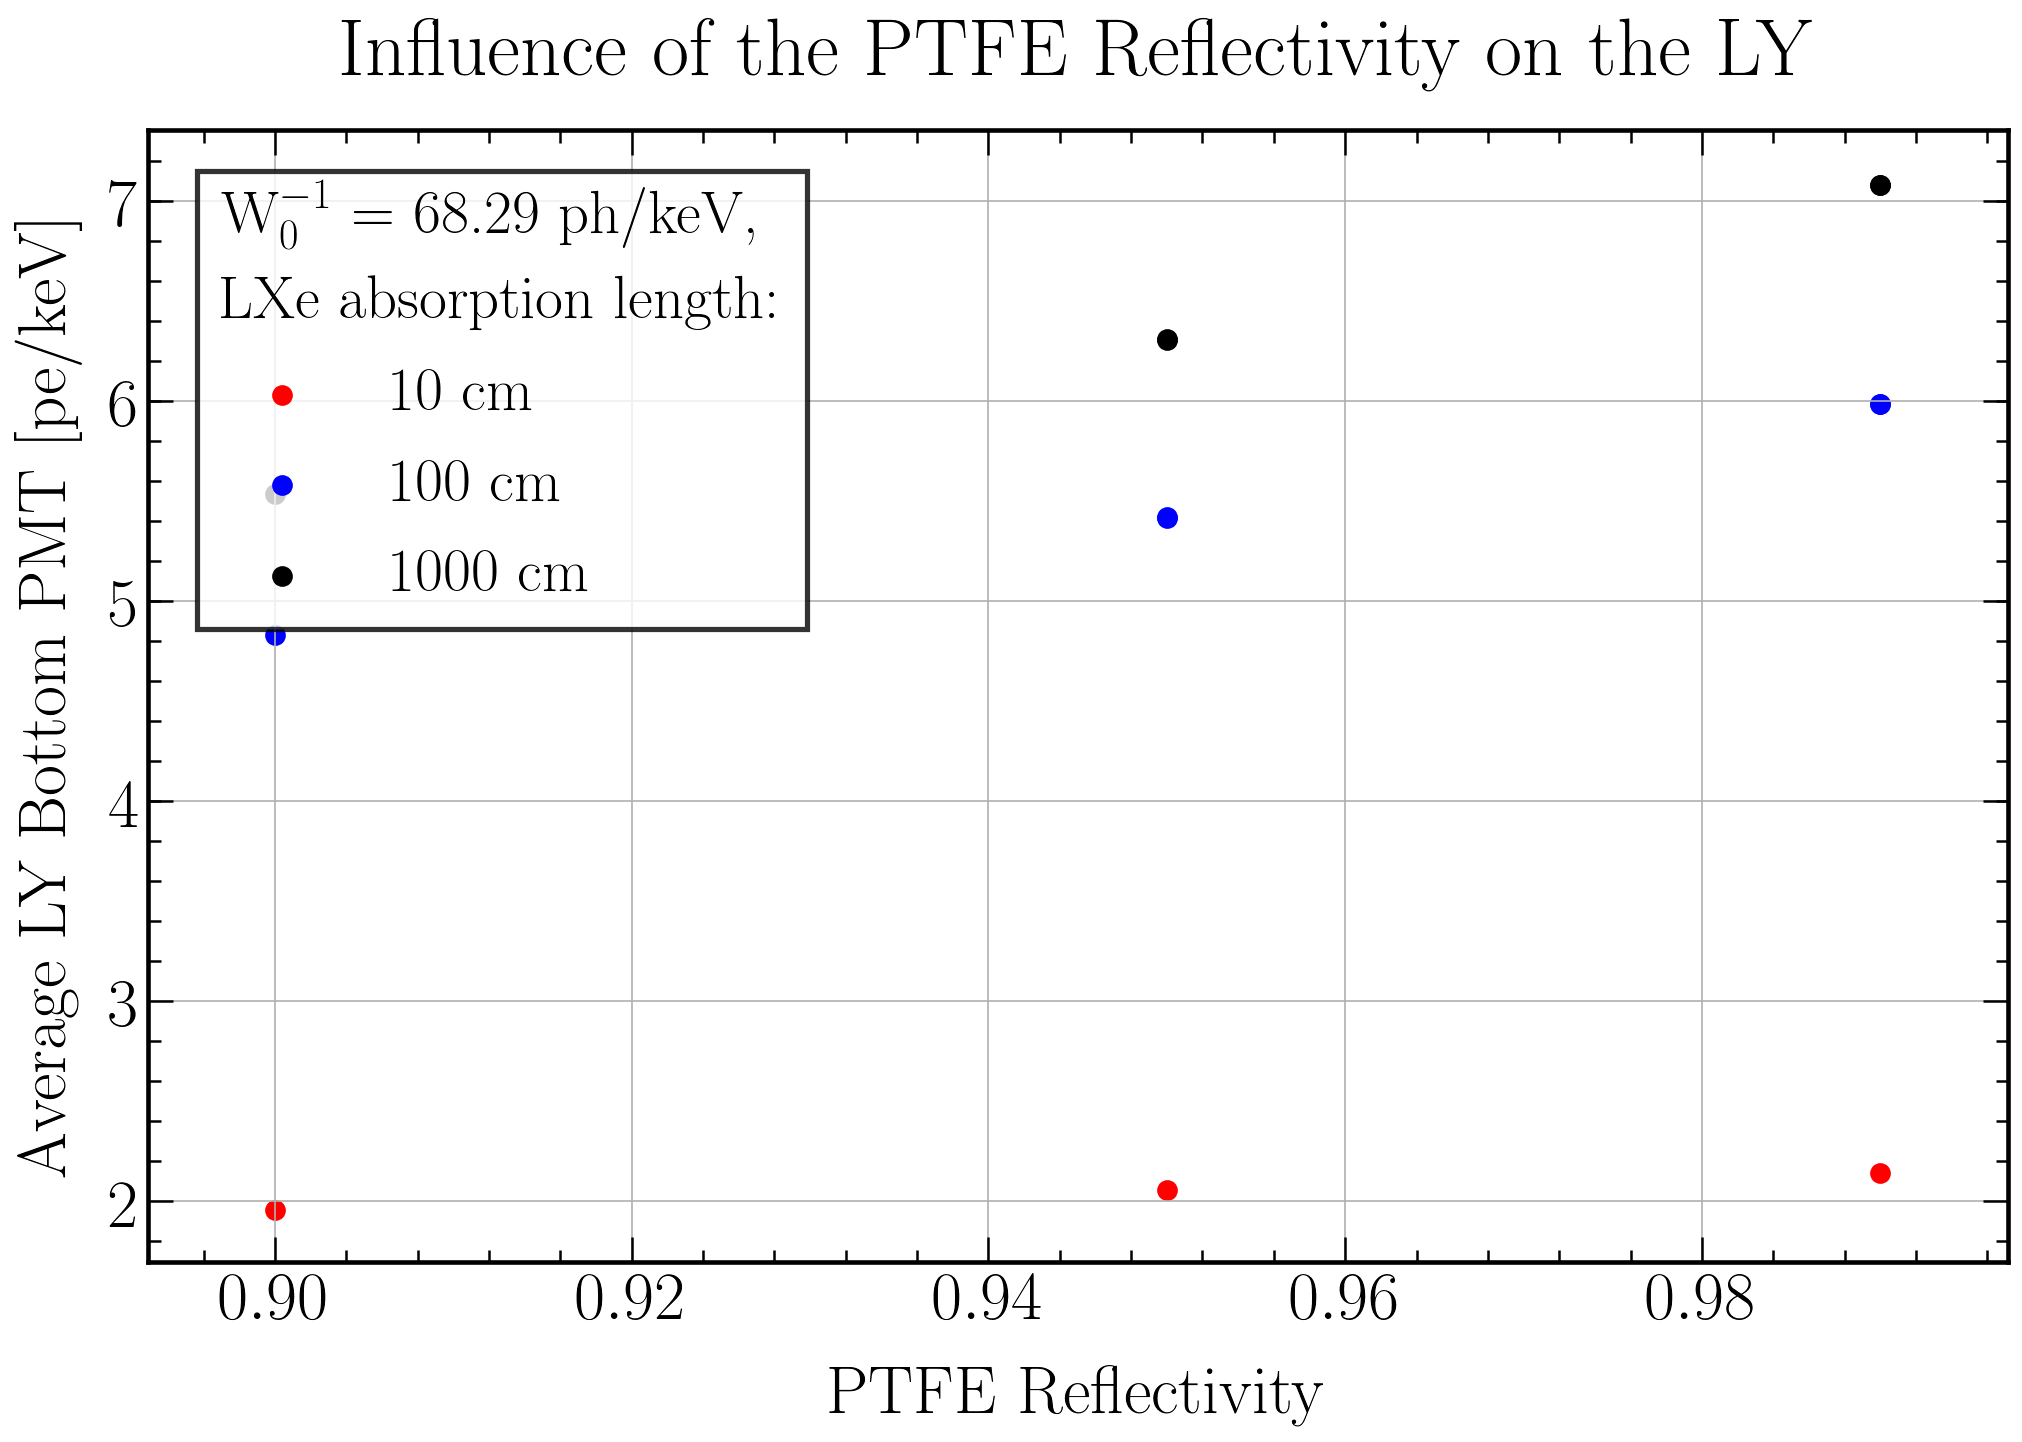

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["RPTFE"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["LXeAbs"] == 10) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = "  10 cm", color = "red", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["LXeAbs"] == 100) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 100 cm", color = "blue", s = 80)

x = opticals["RPTFE"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["LXeAbs"] == 1000) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 1000 cm", color = "black", s = 80)

plt.xlabel('PTFE Reflectivity', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the PTFE Reflectivity on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\n"+"LXe absorption length:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0.02,0.104)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig("Influence_TeflonRef_LY0_Bottom.png")
plt.show()

## Influence of the LXe Absorption Length on the LCE

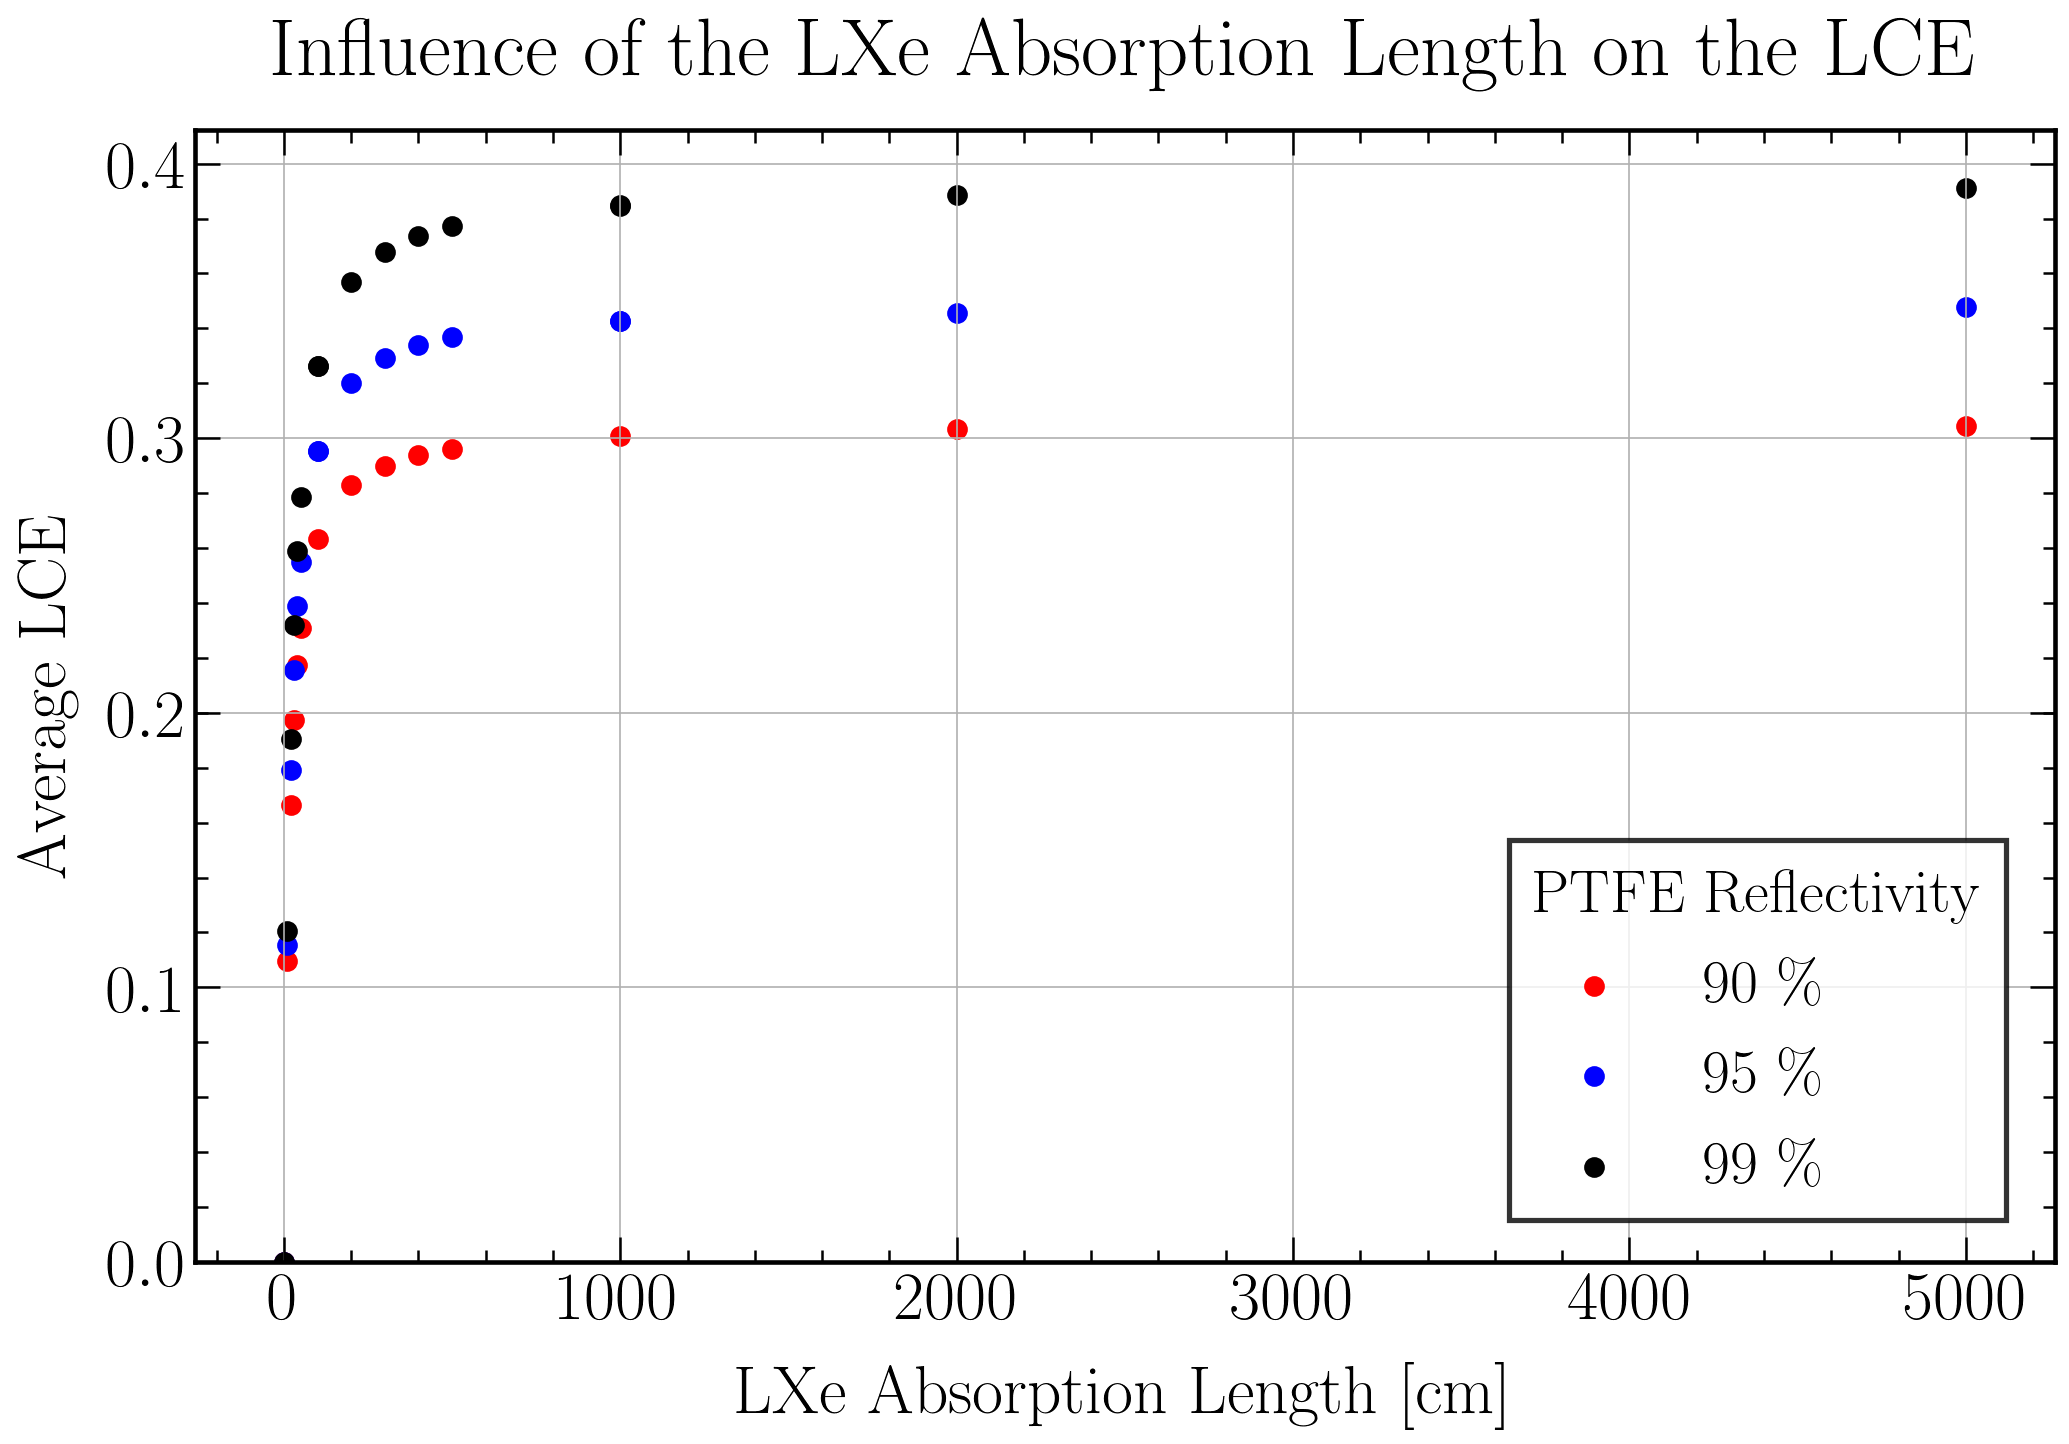

In [14]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LCE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LCE.png")
plt.show()

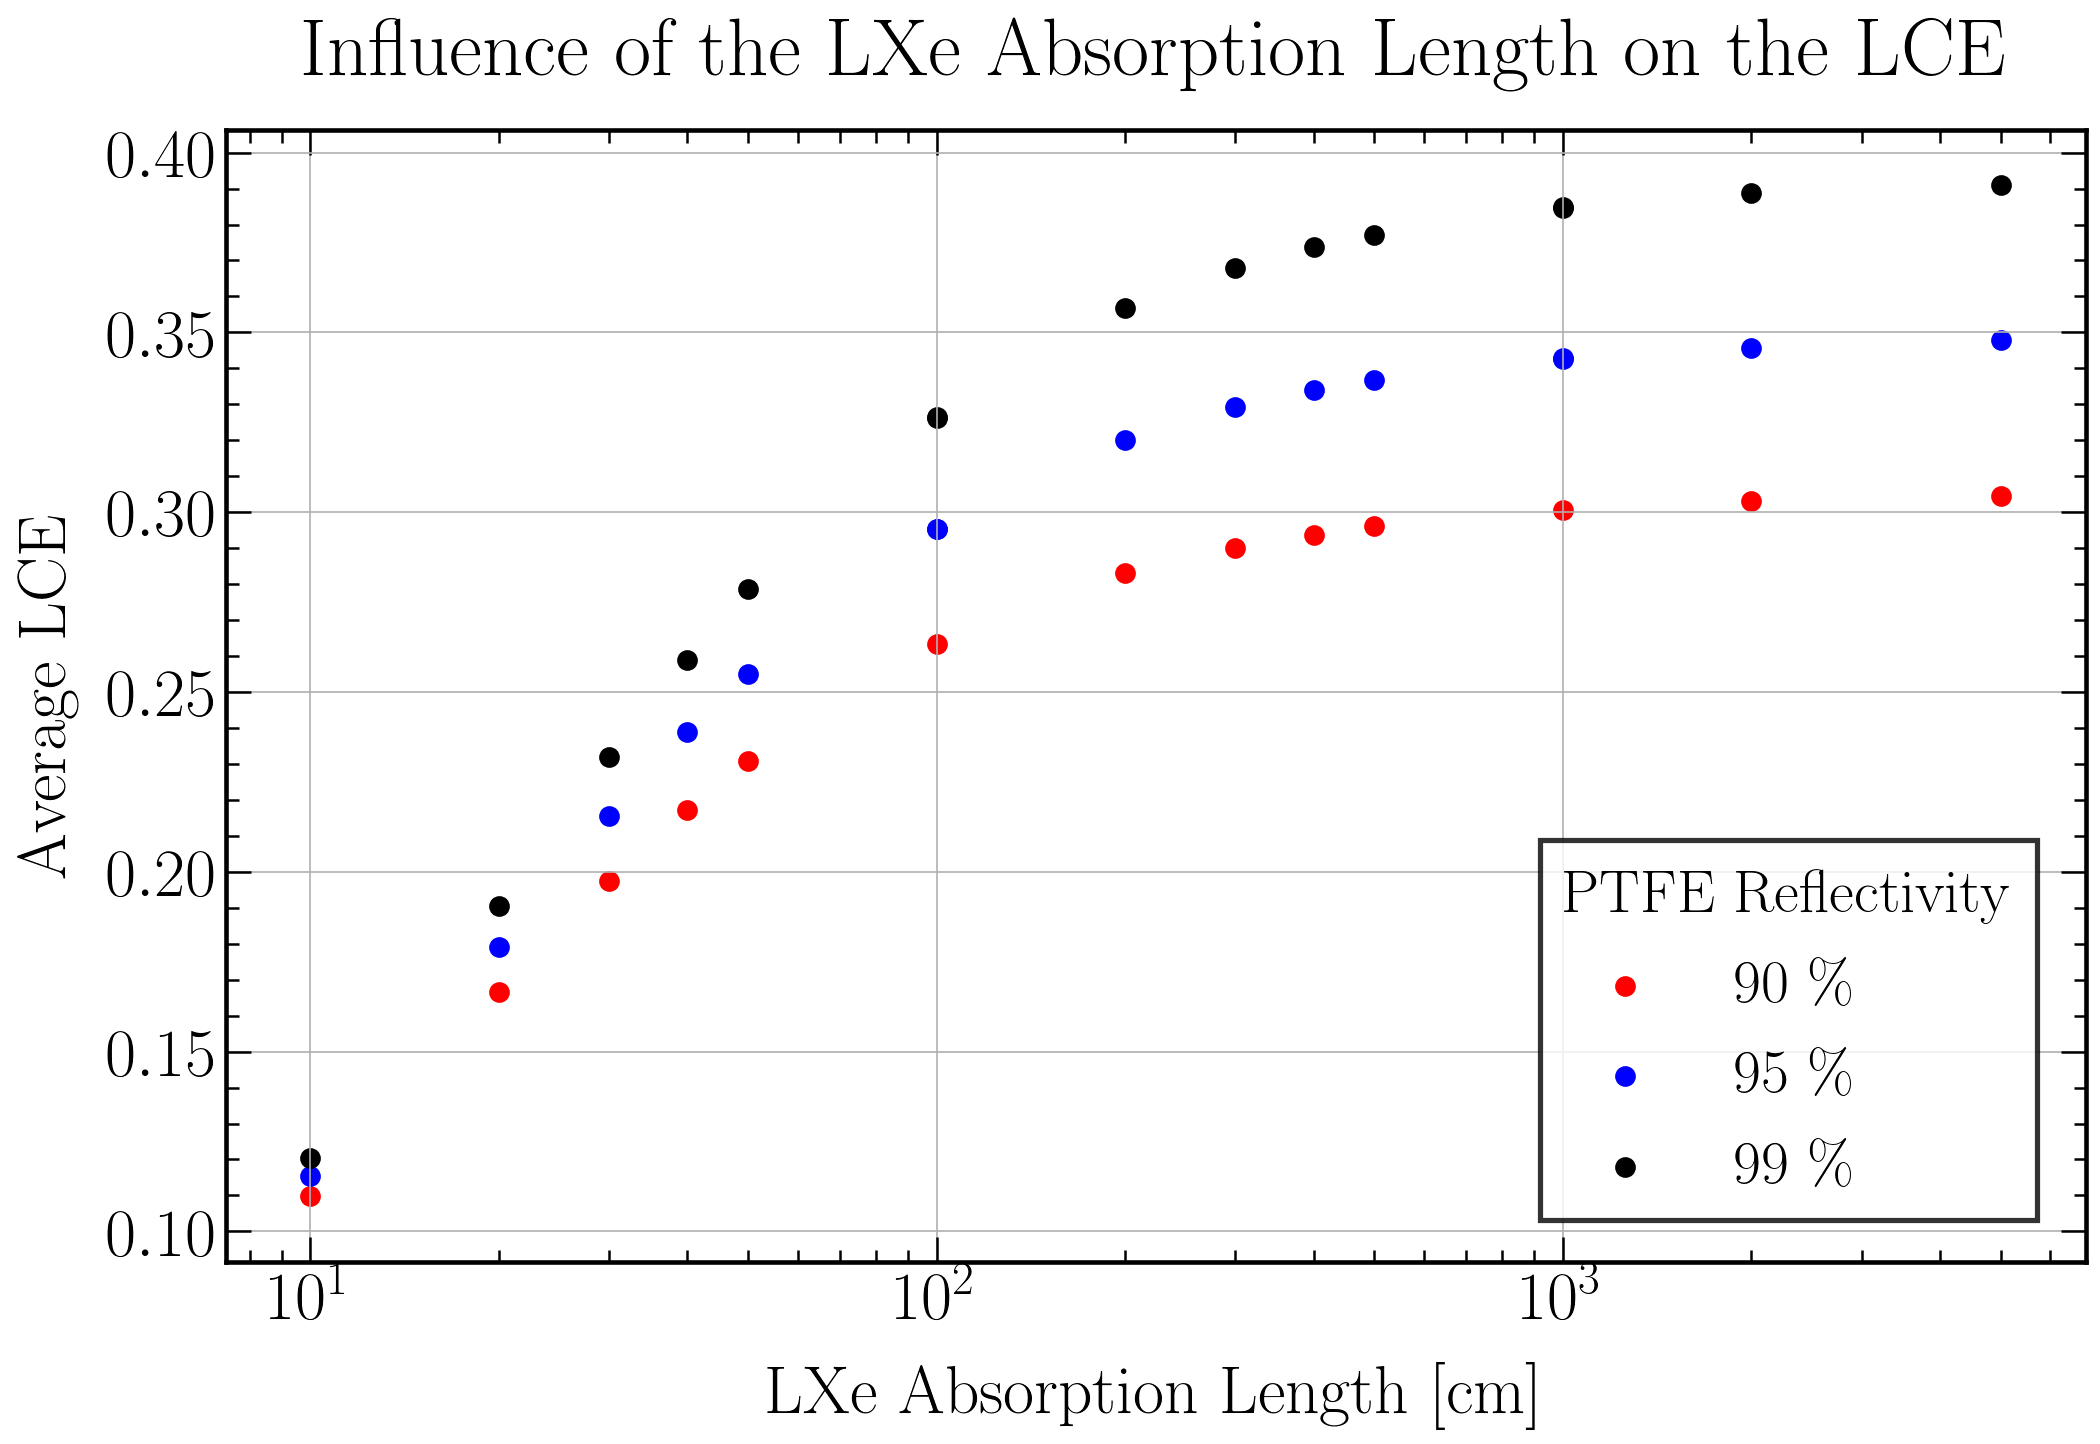

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LCE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LCE_log.png")
plt.show()

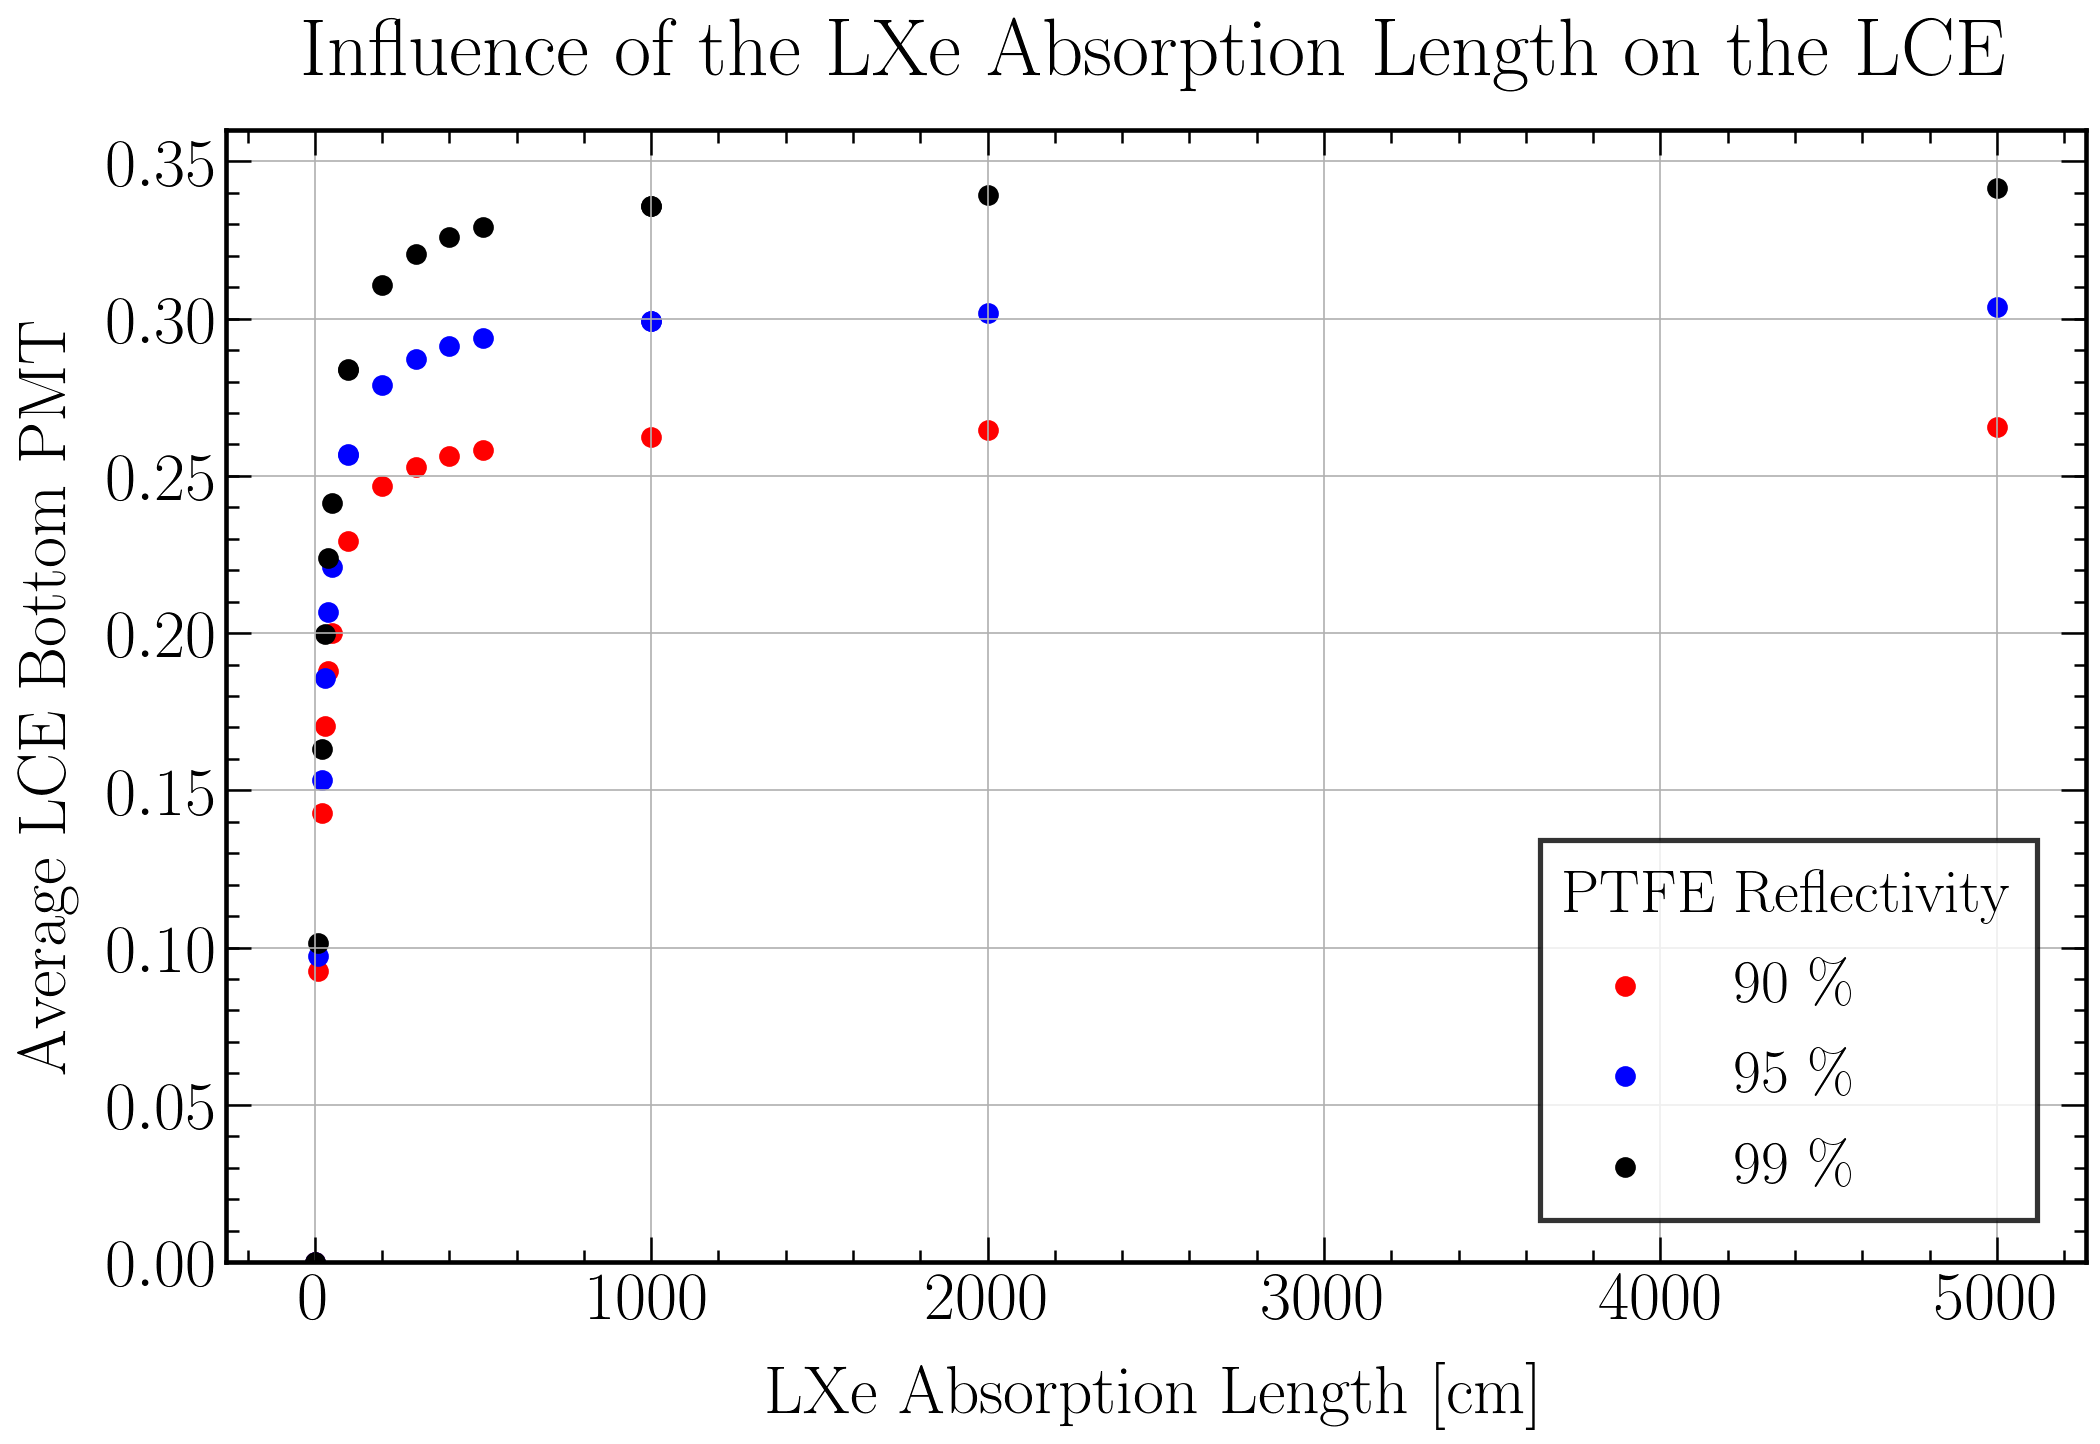

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LCE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LCE_Bottom.png")
plt.show()

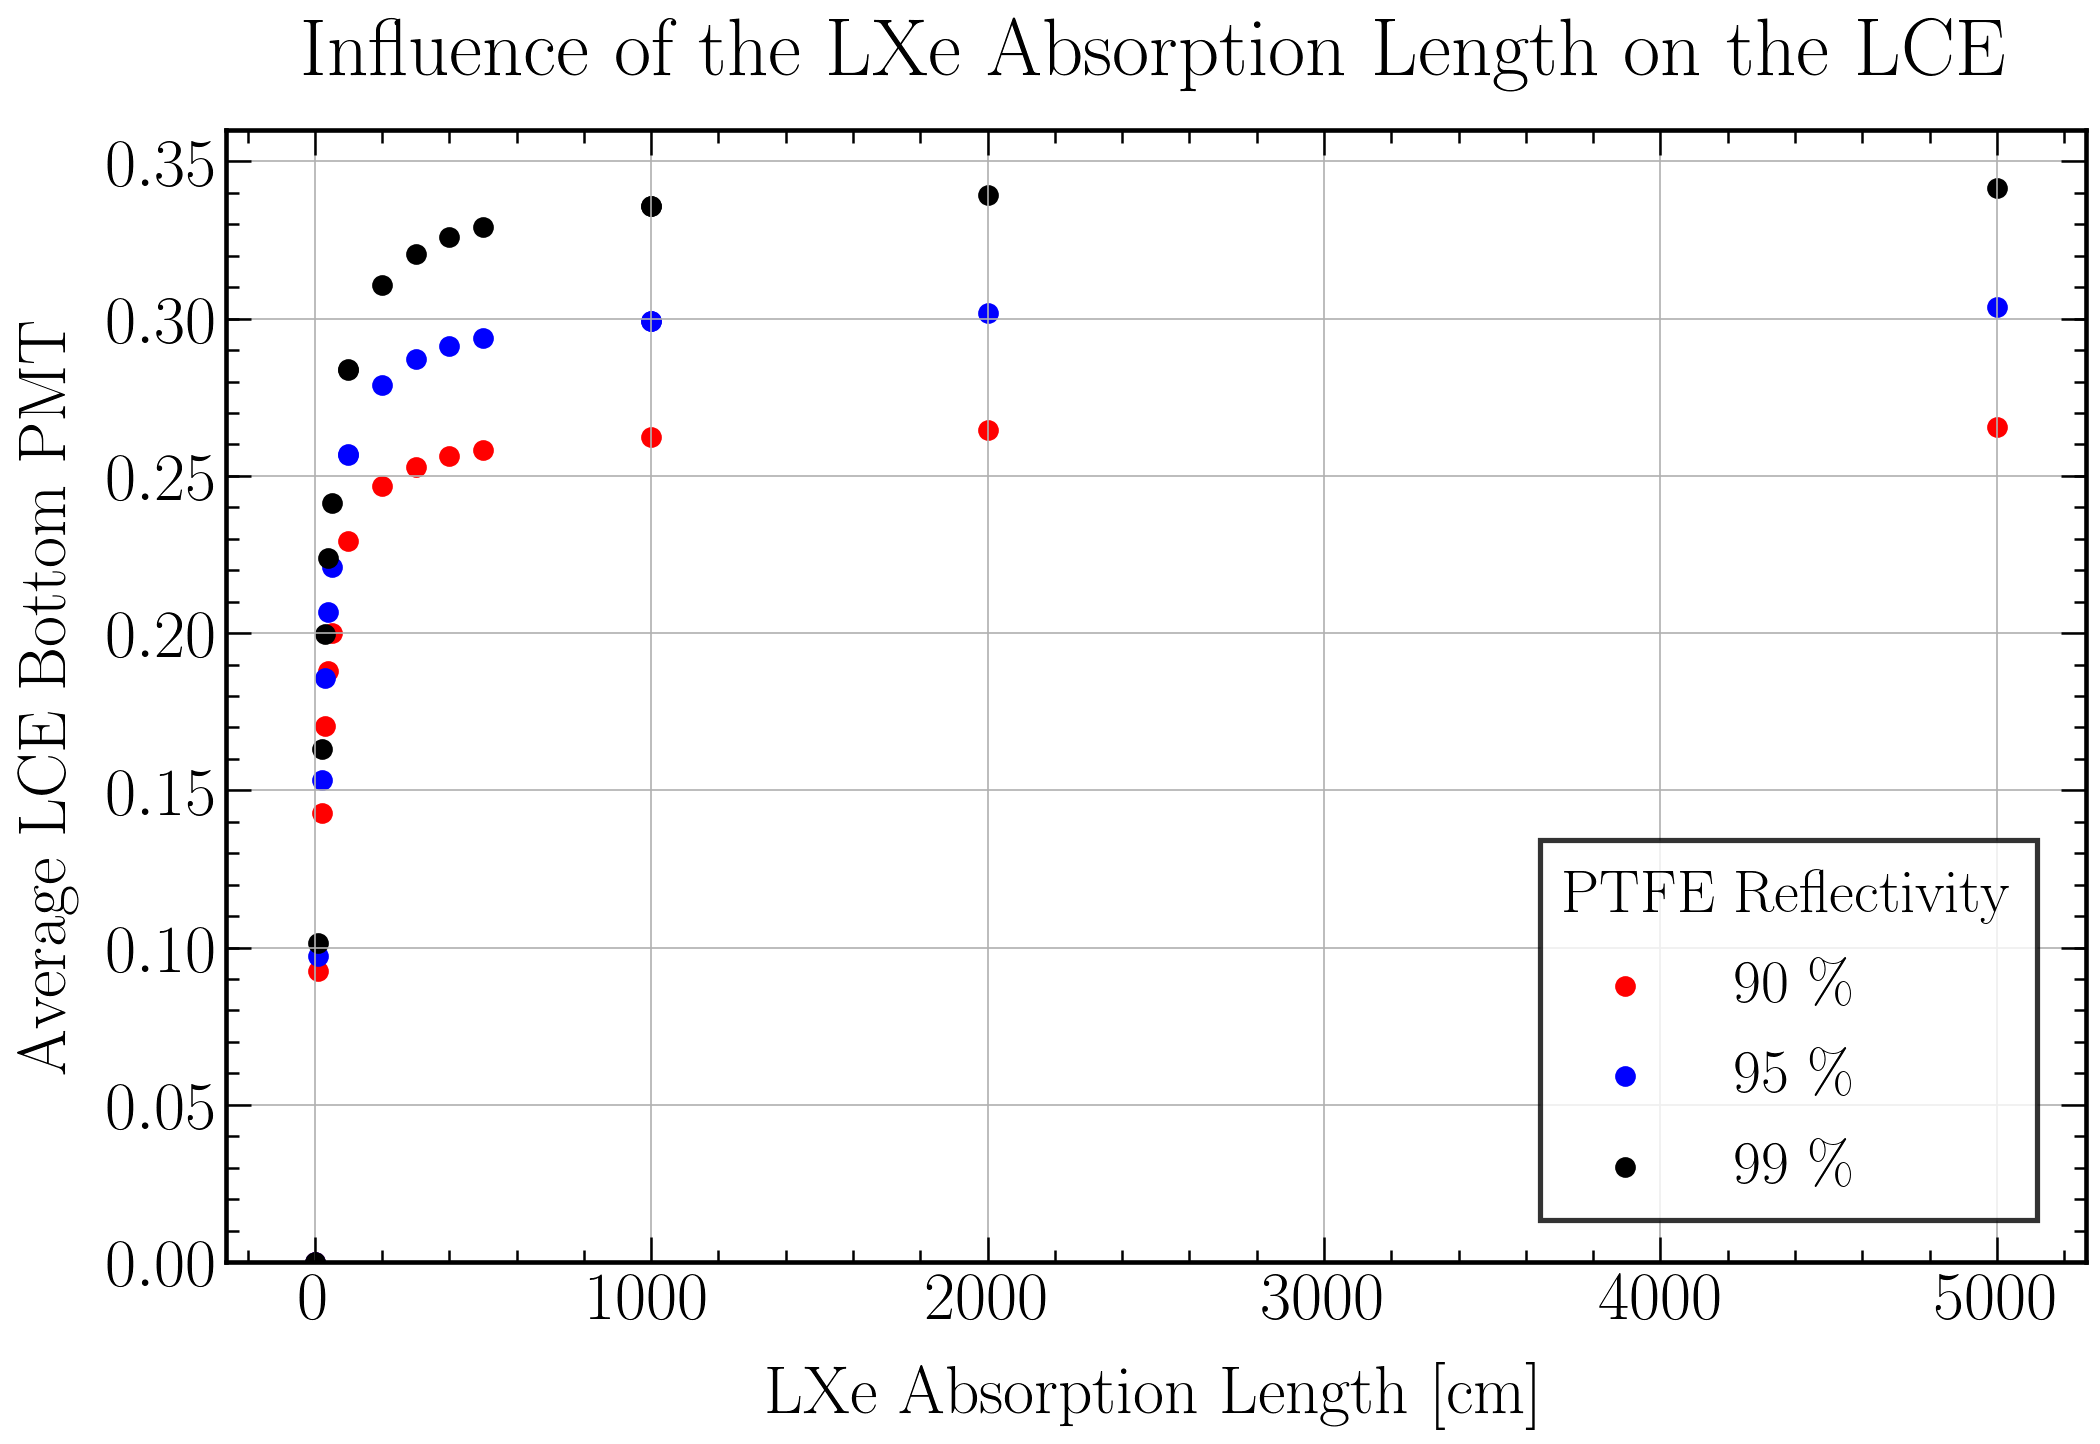

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LCE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LCE_Bottom.png")
plt.show()

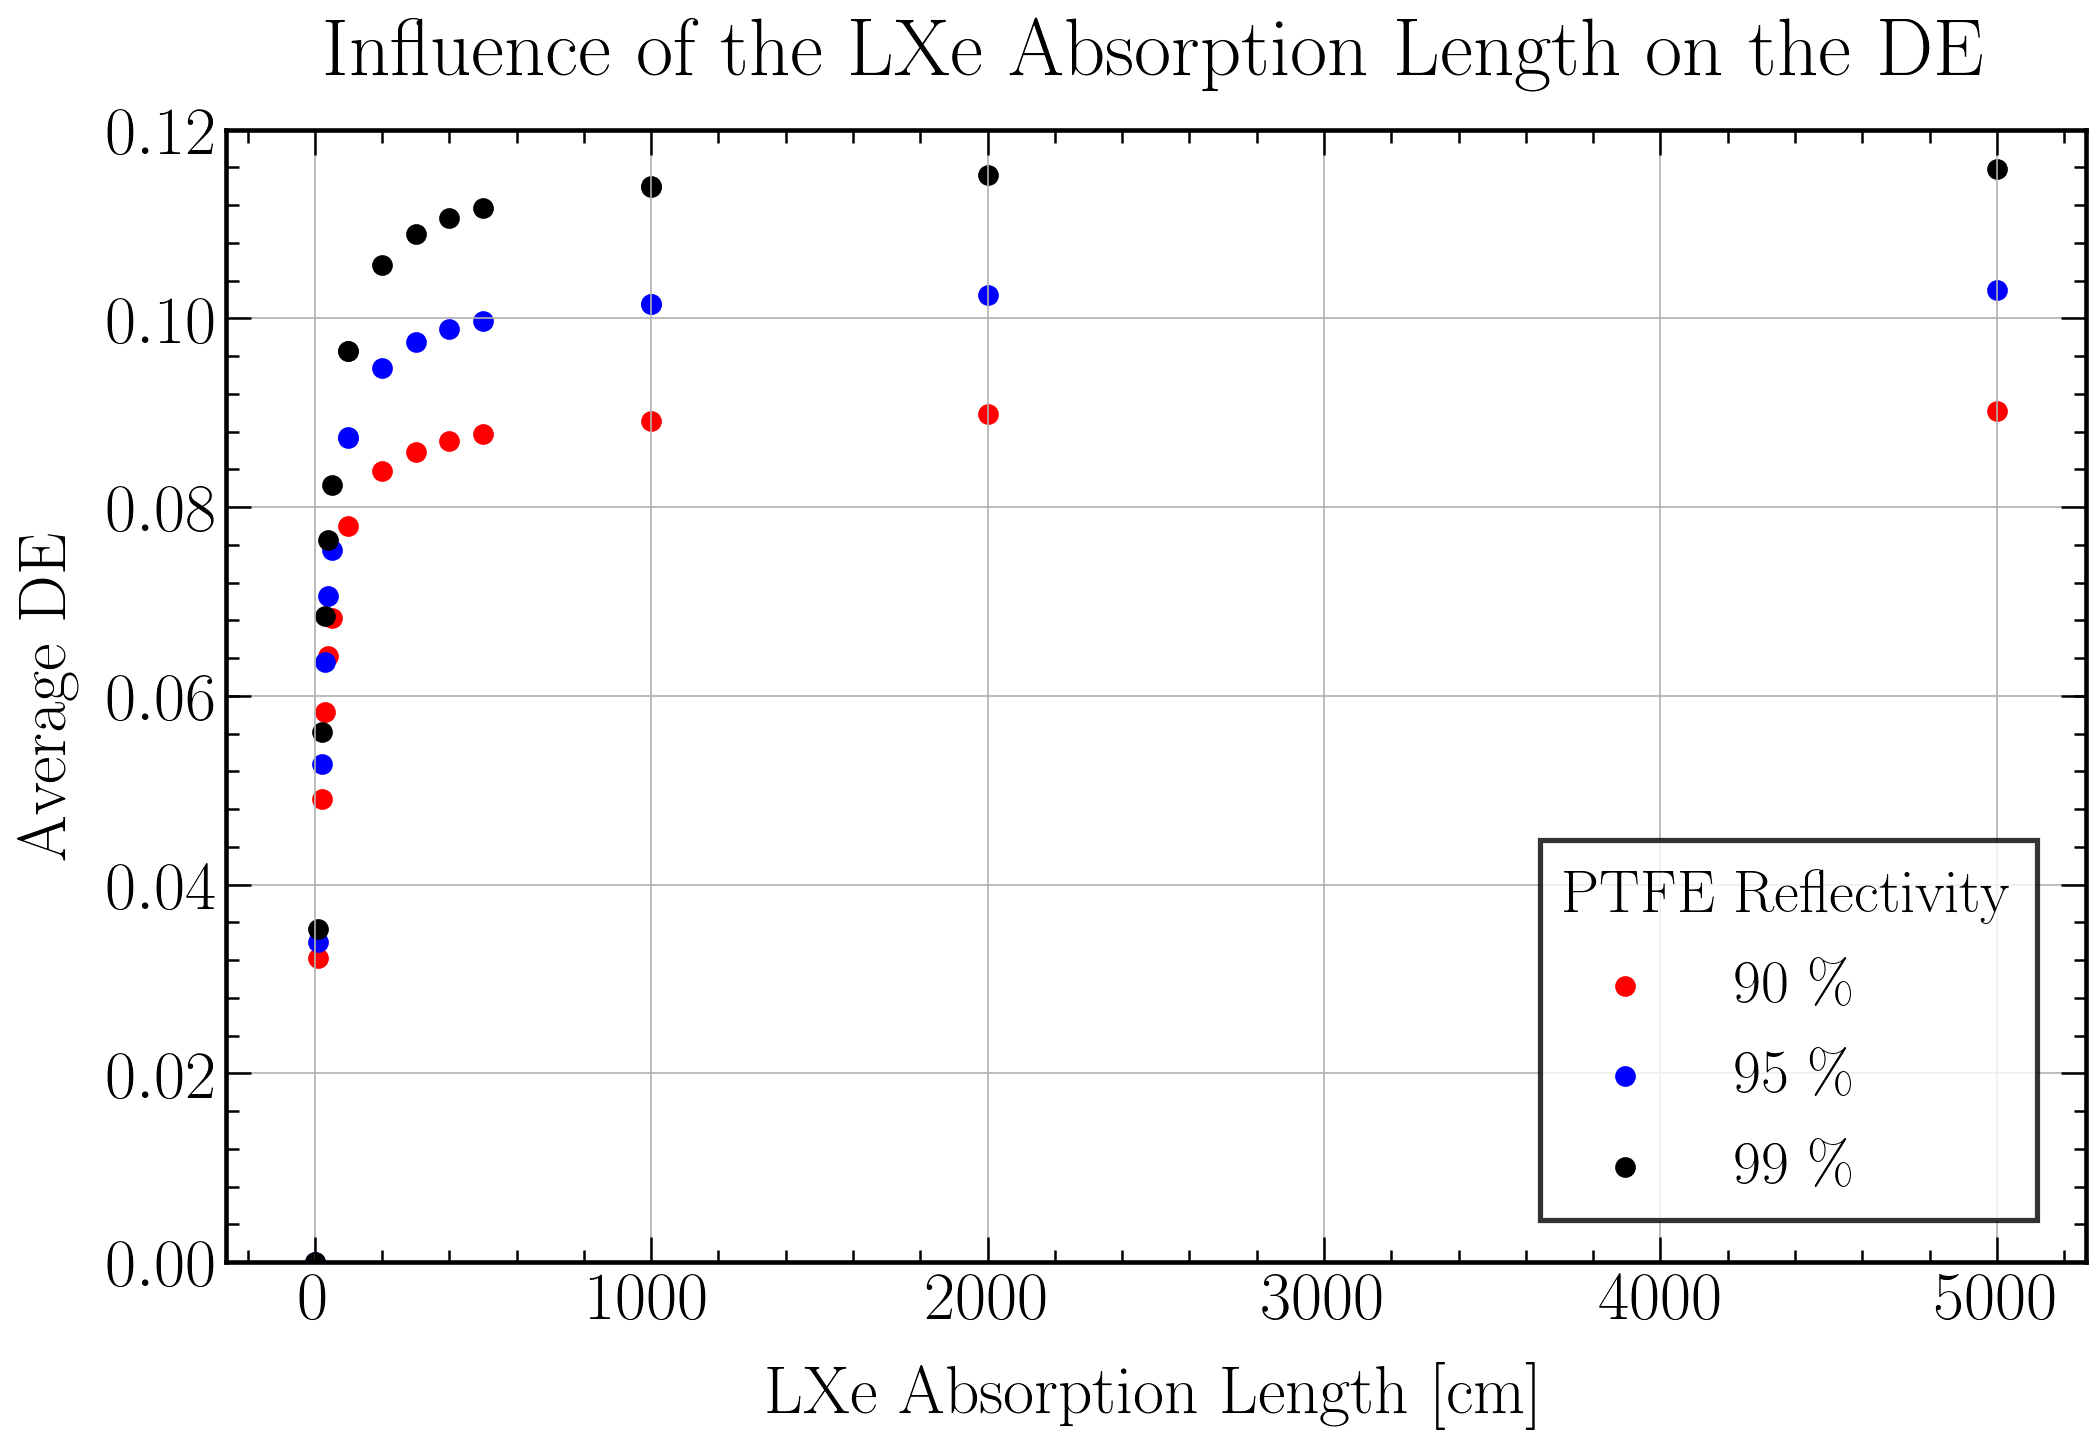

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the DE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_DE.png")
plt.show()

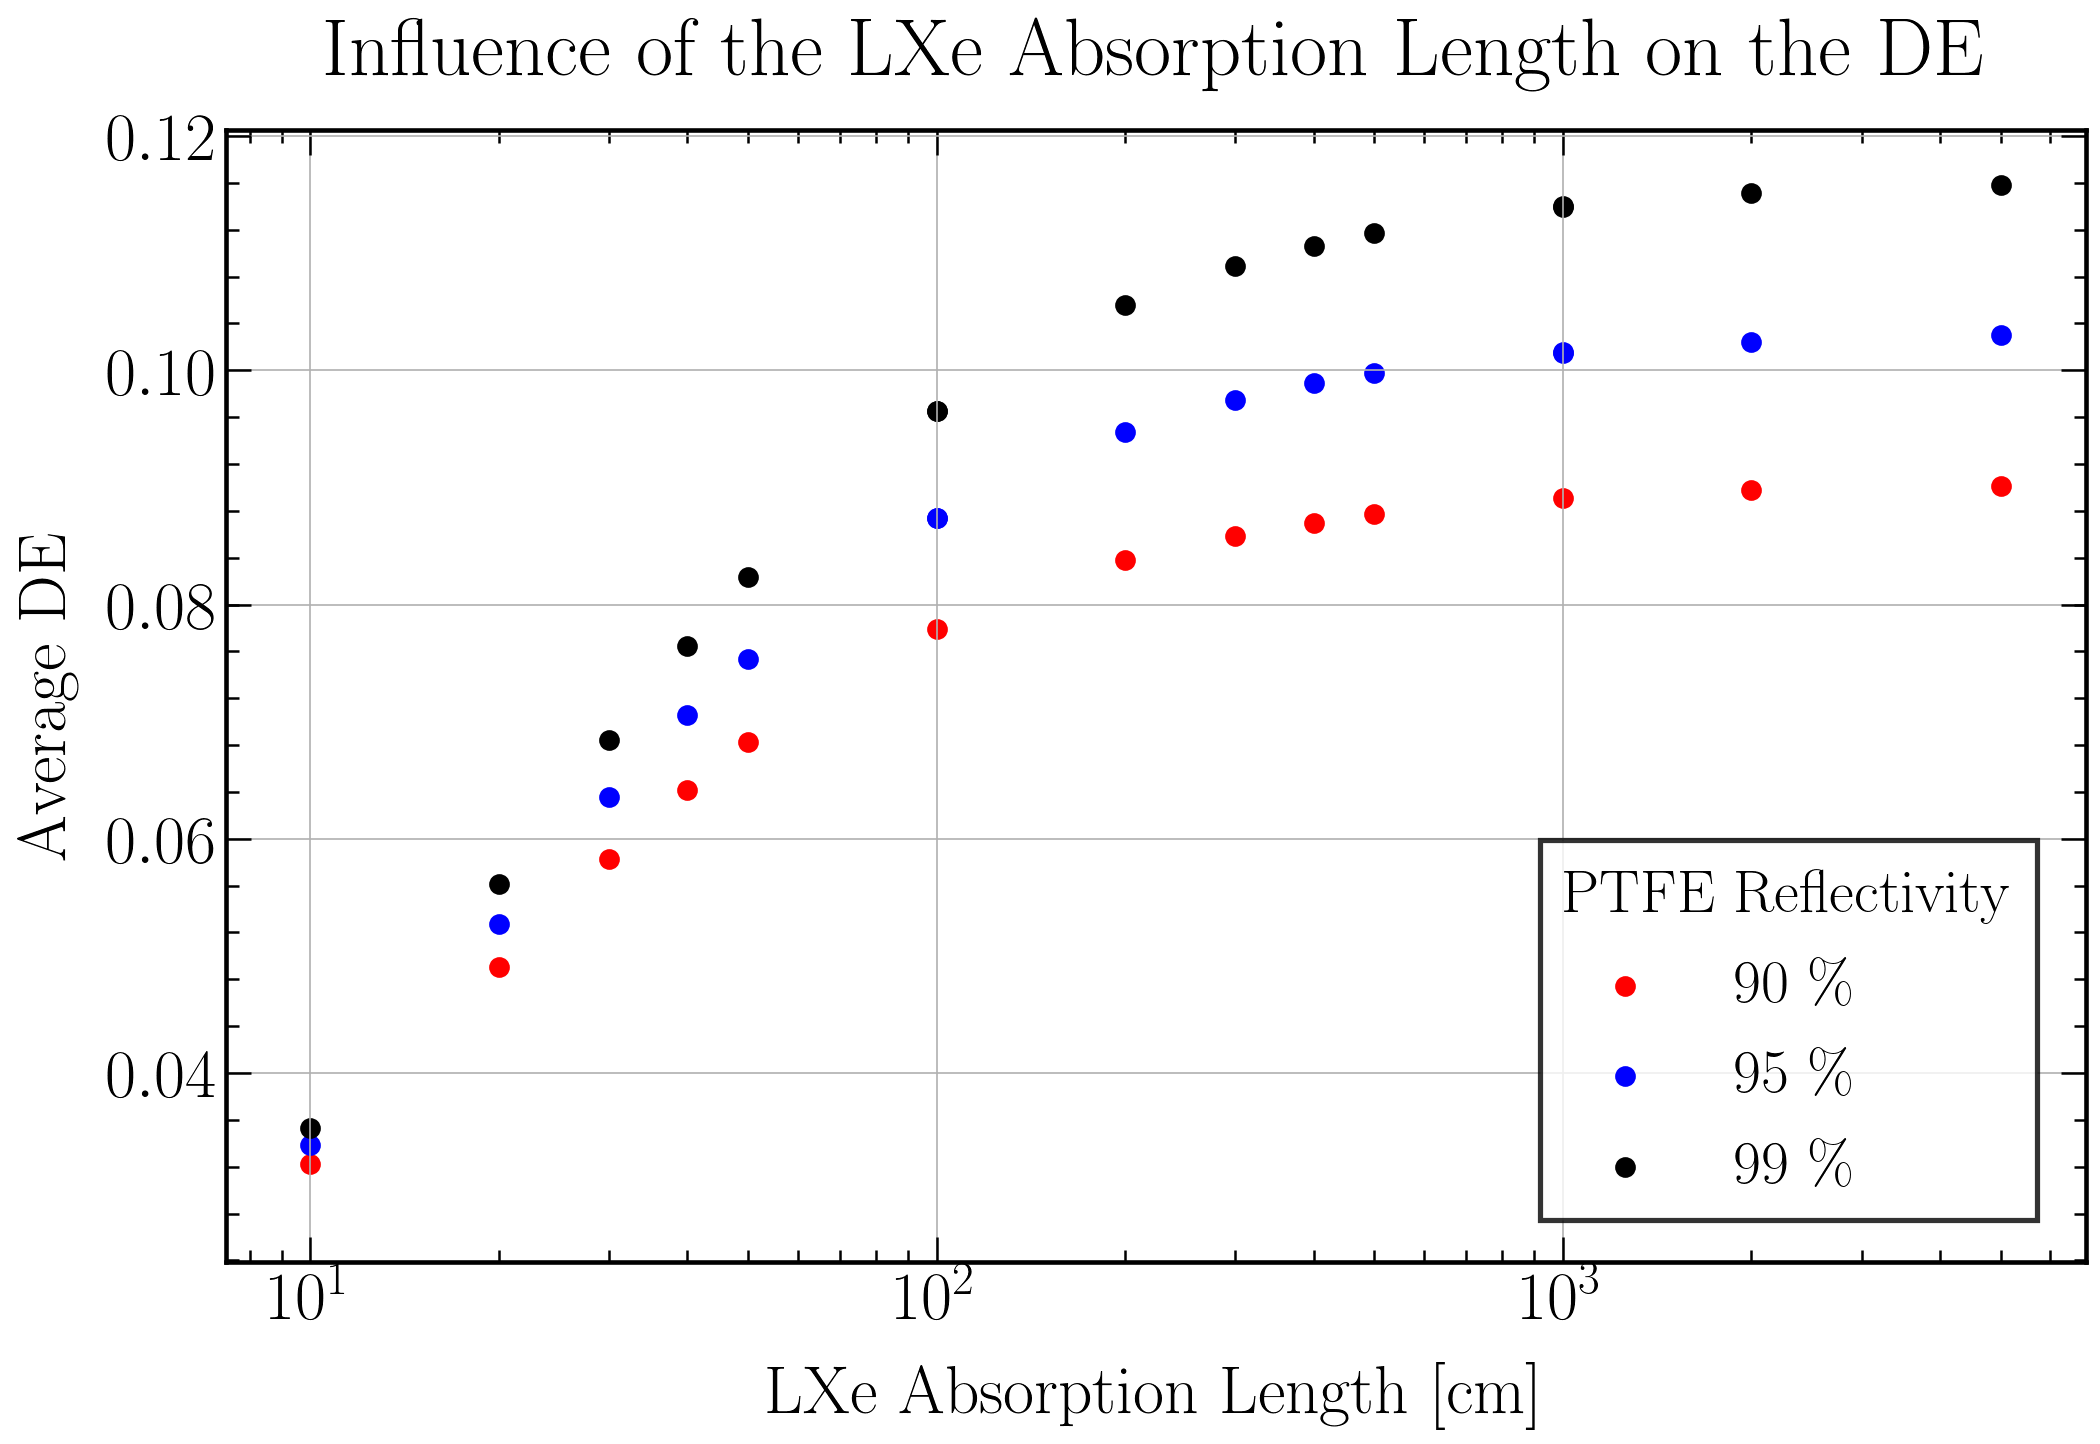

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the DE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_DE_log.png")
plt.show()

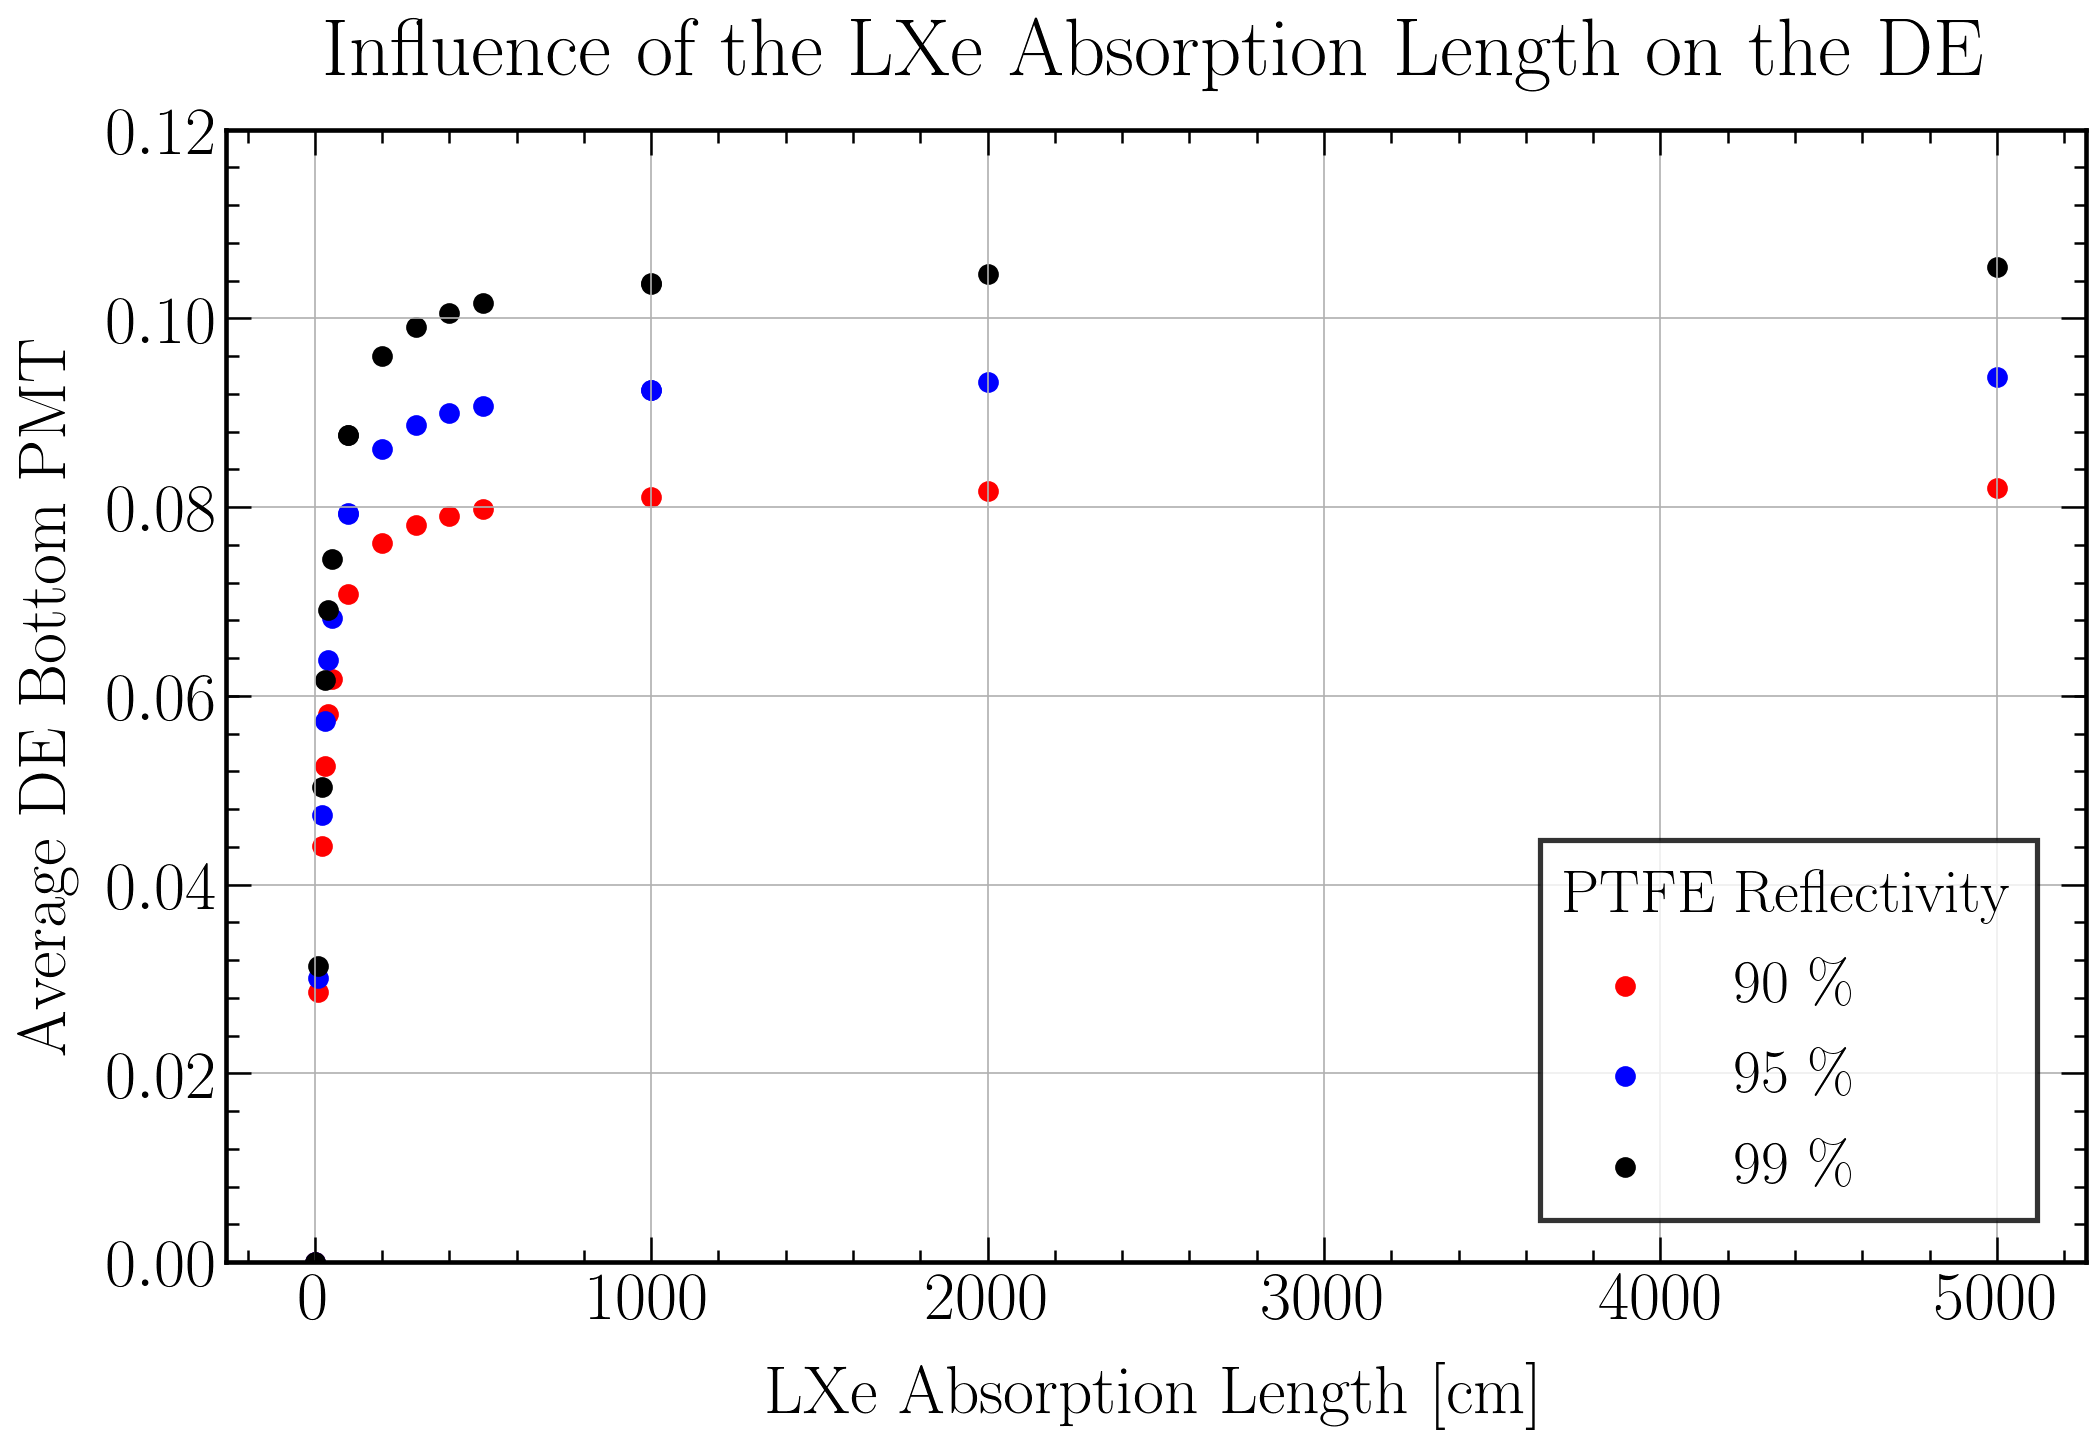

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the DE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_DE_Bottom.png")
plt.show()

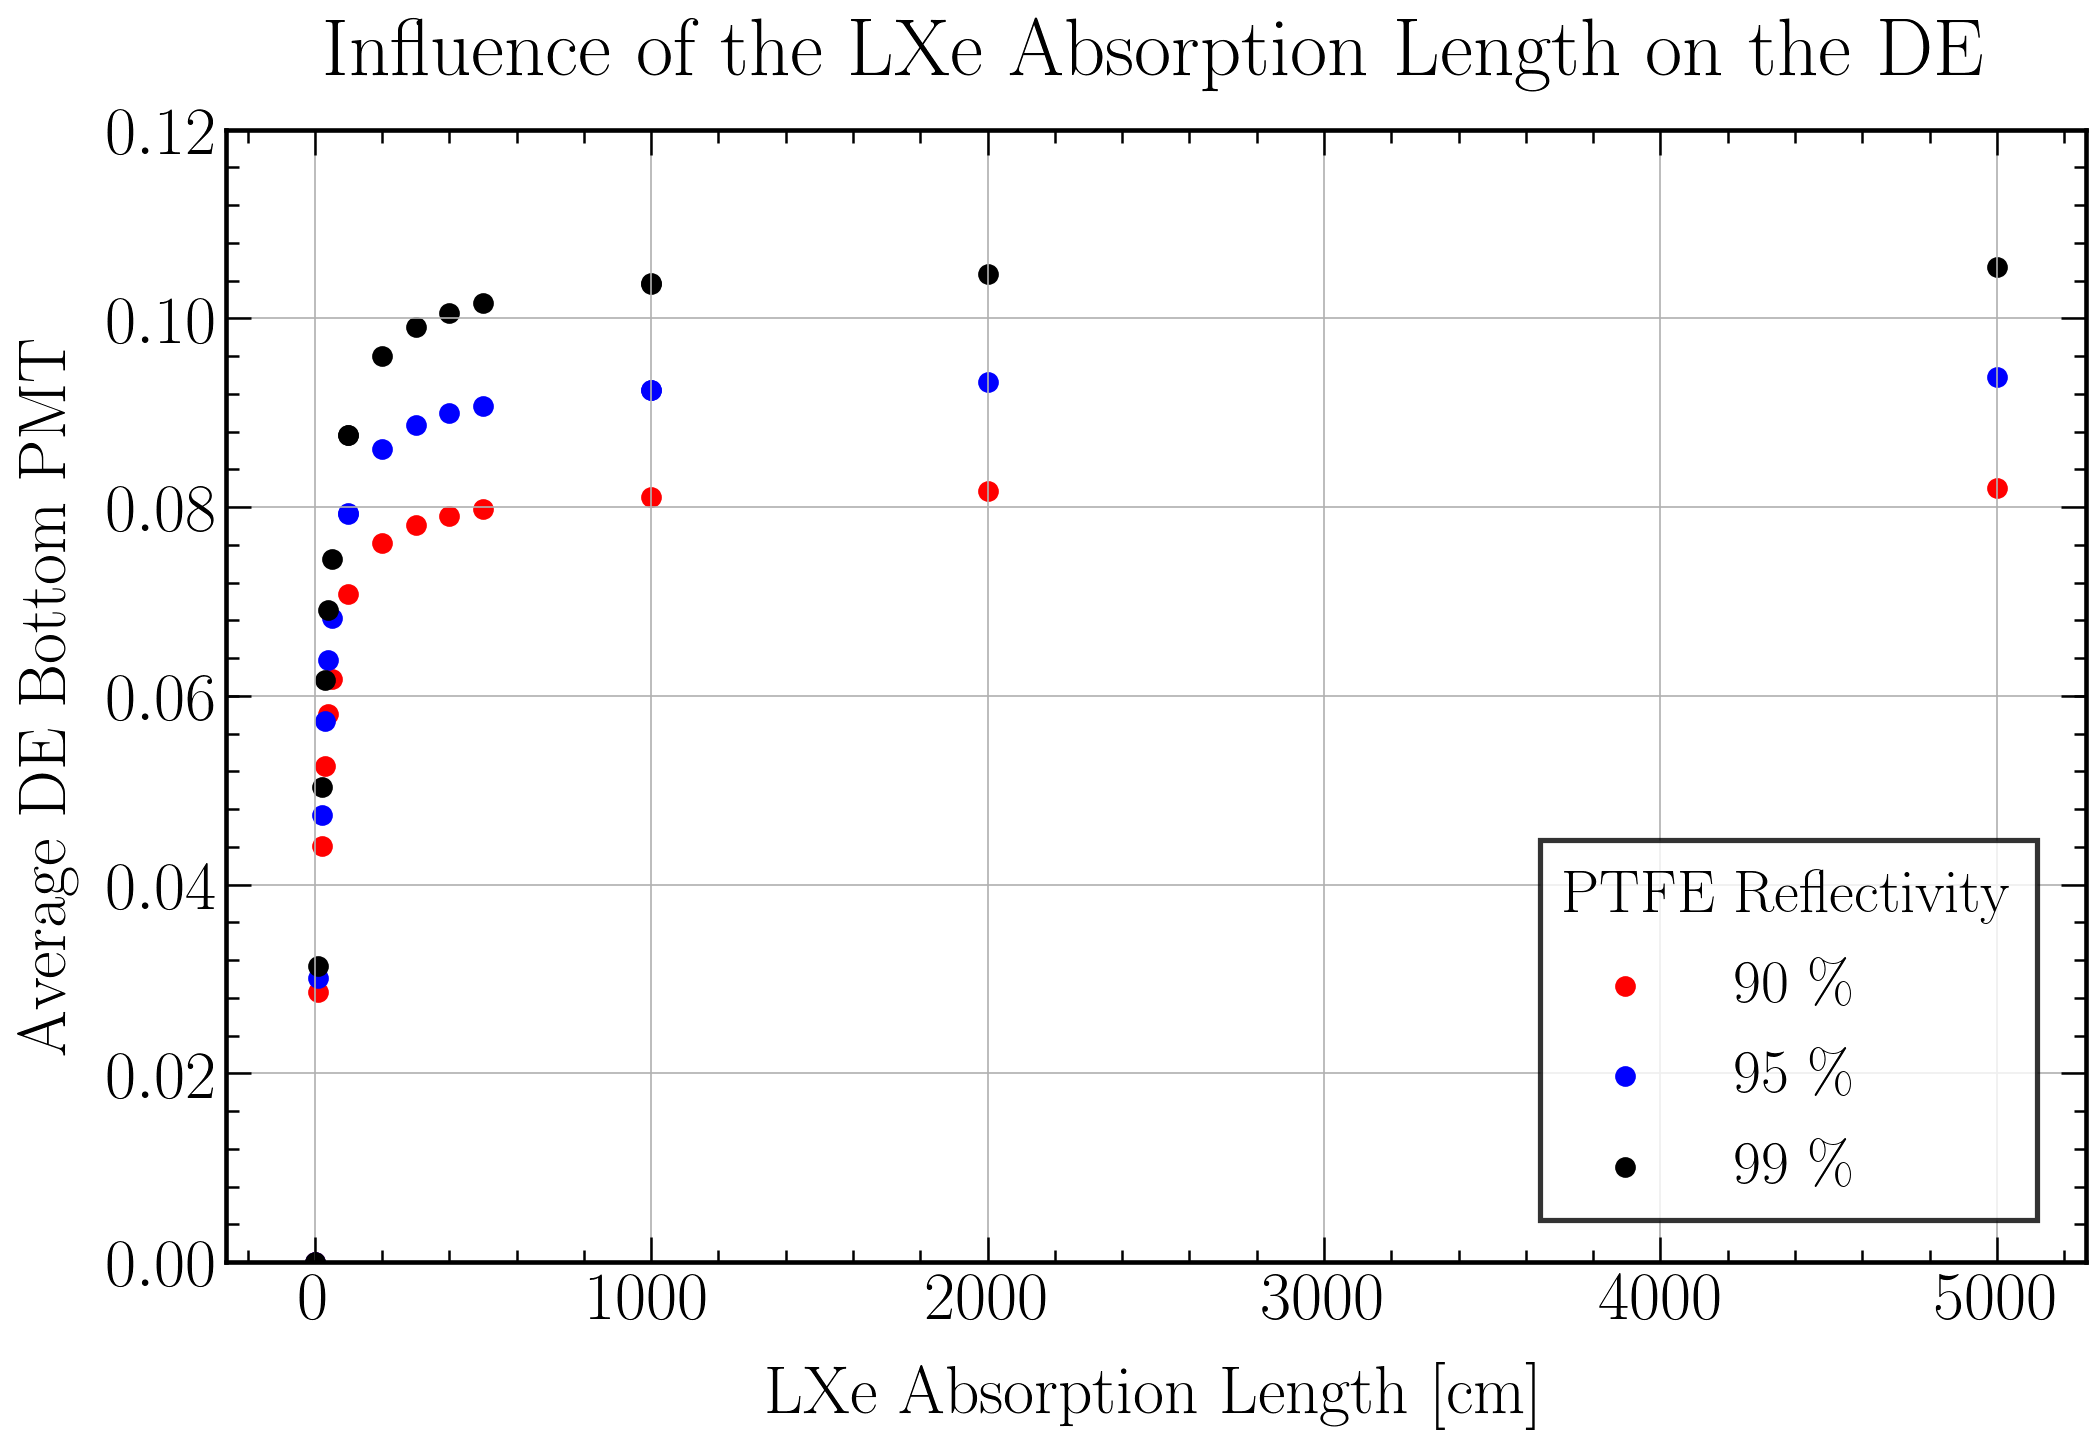

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the DE', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="PTFE Reflectivity", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_DE_Bottom.png")
plt.show()

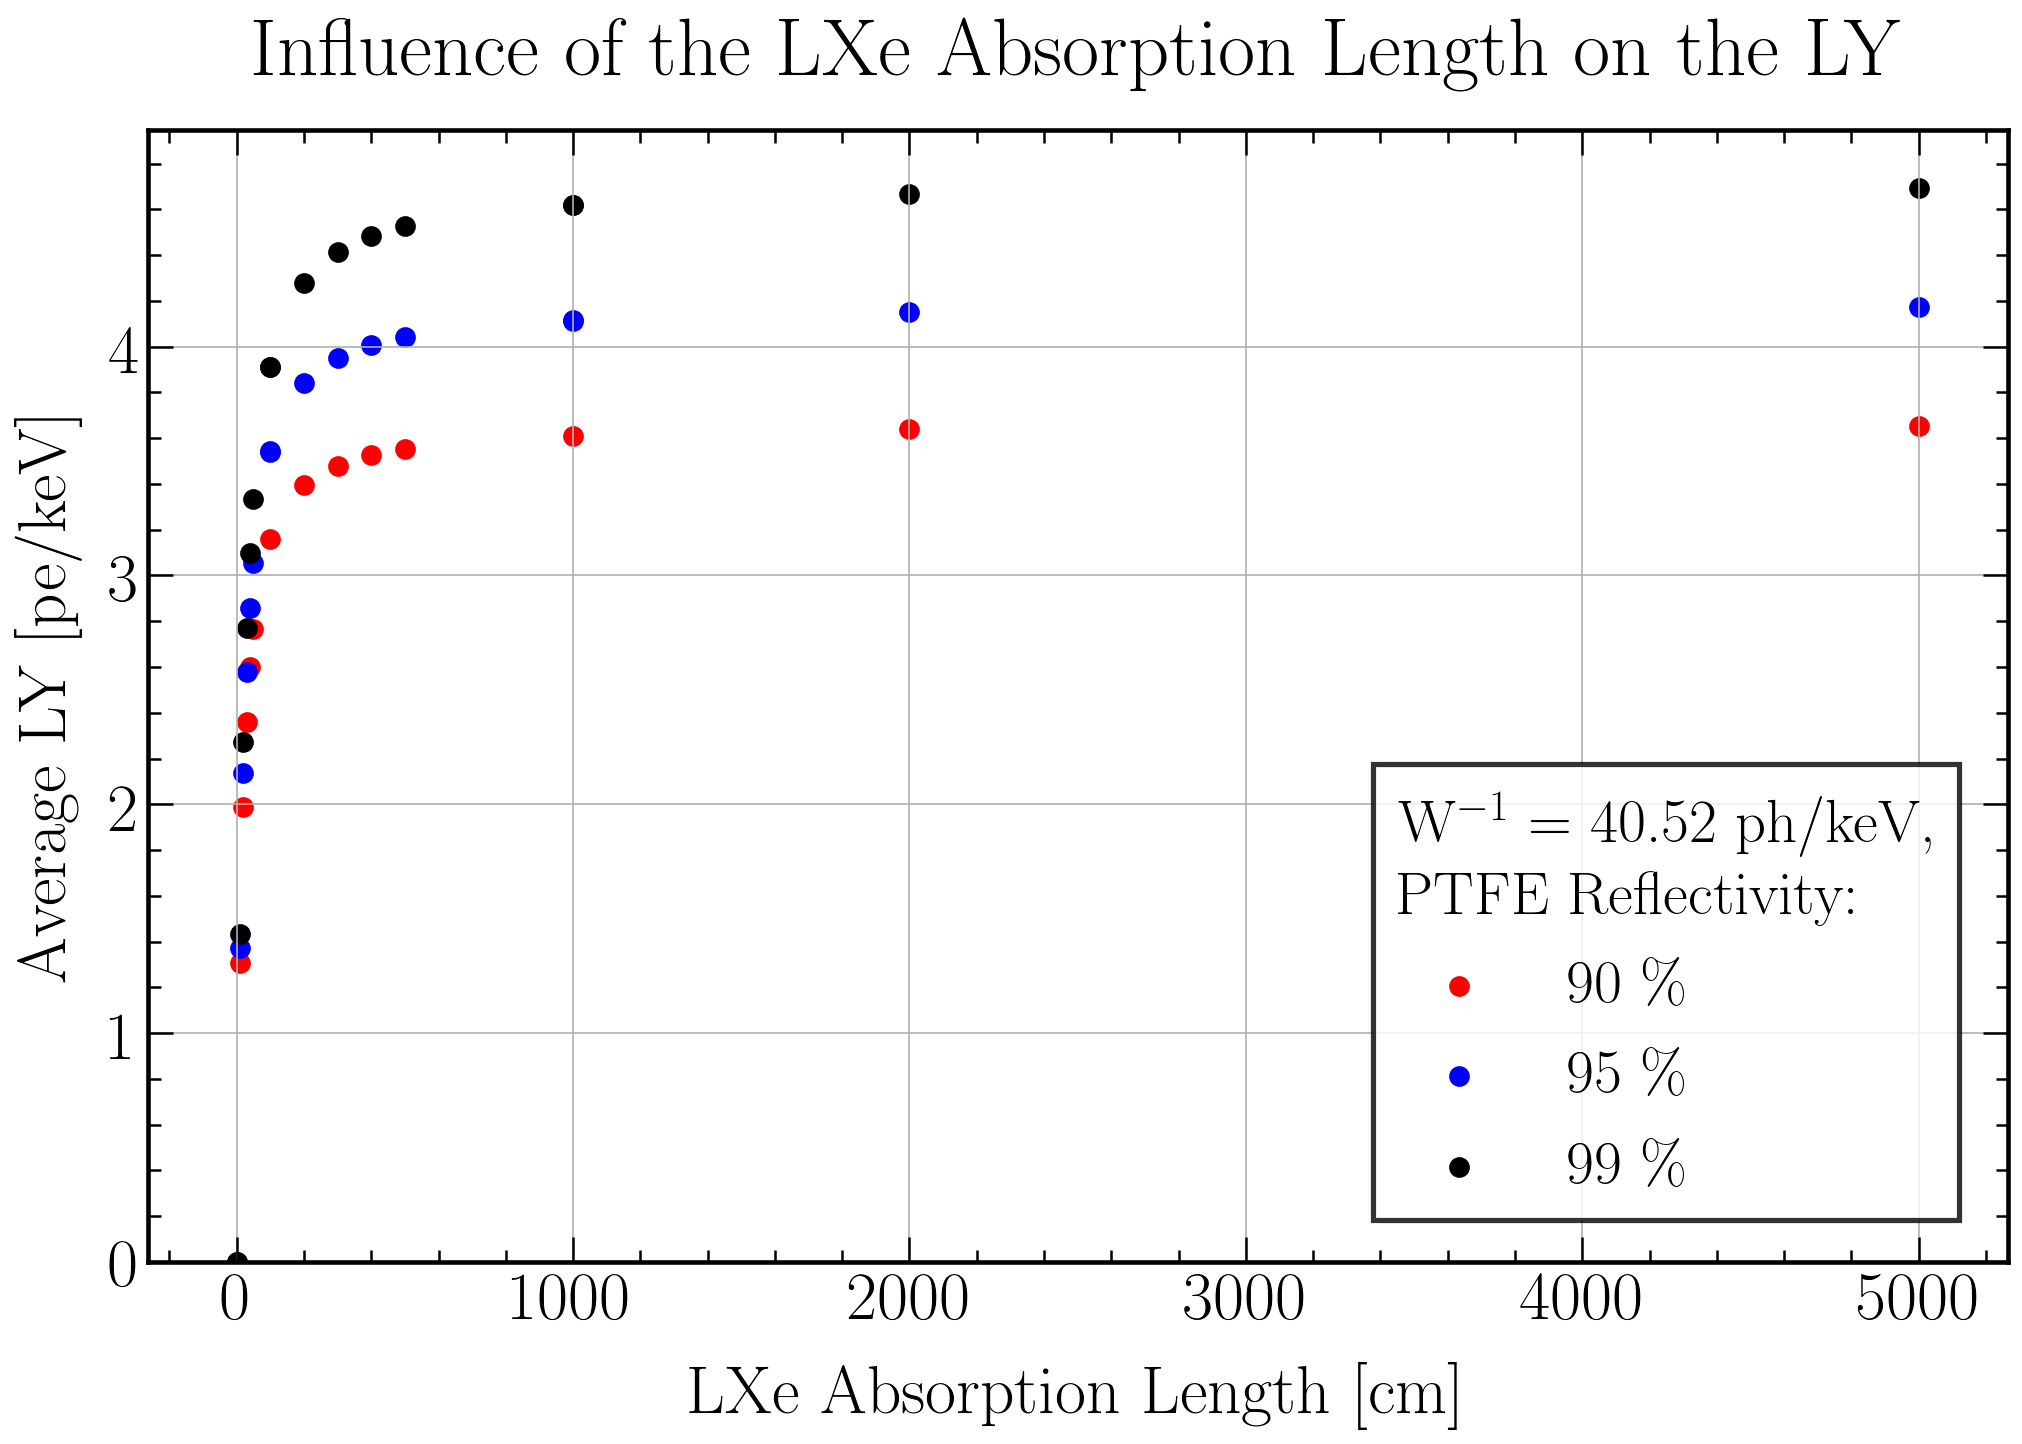

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY.png")
plt.show()

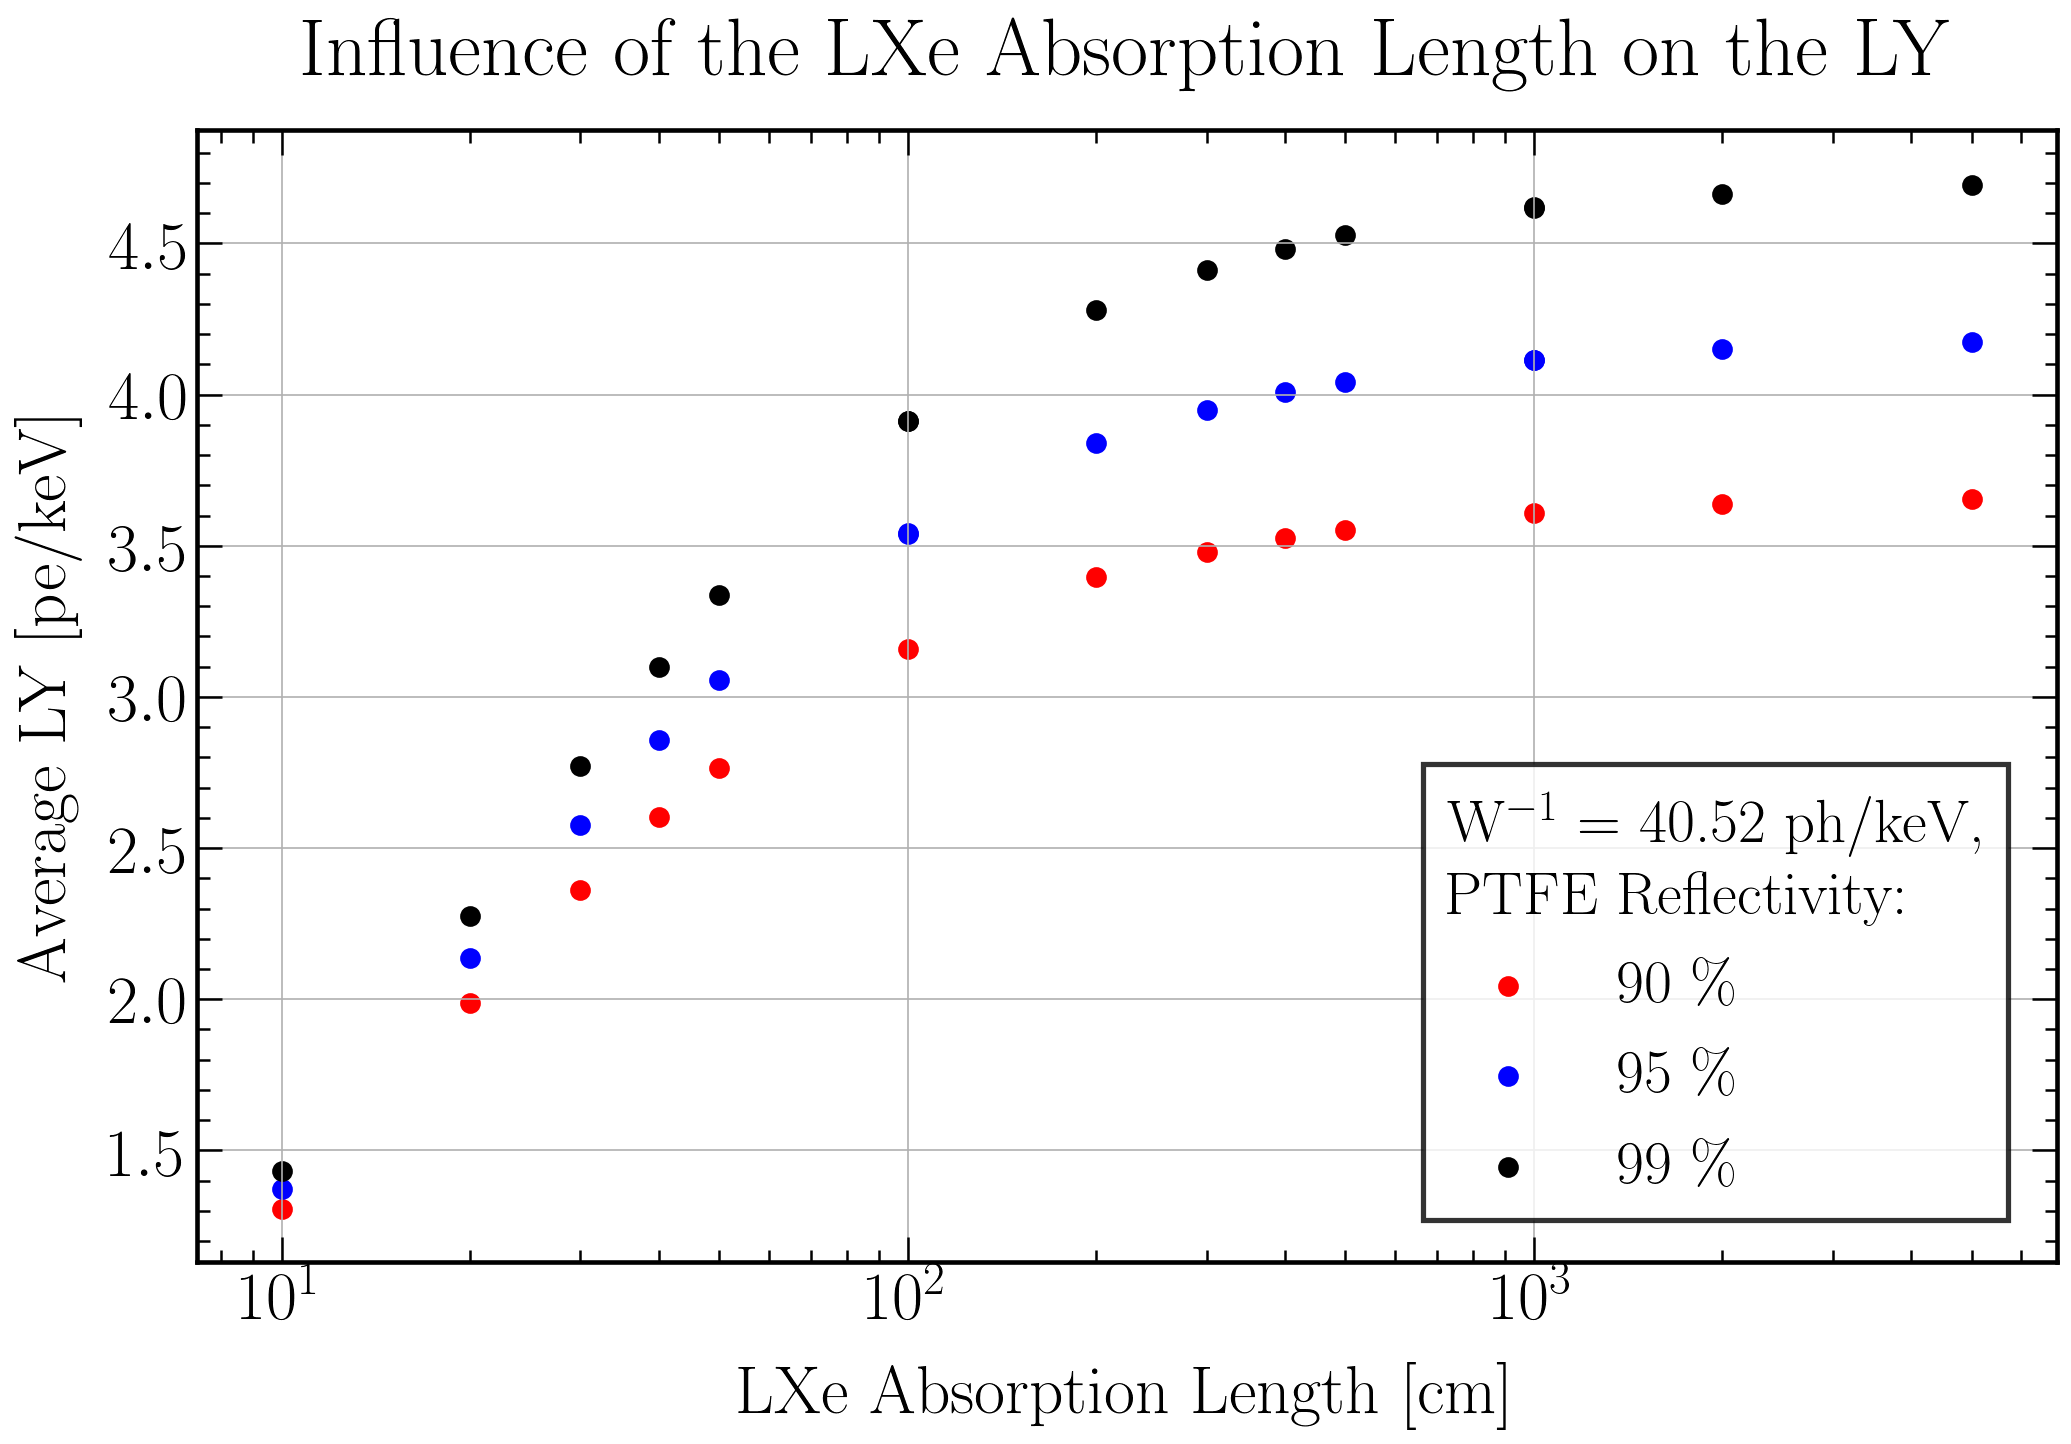

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY_log.png")
plt.show()

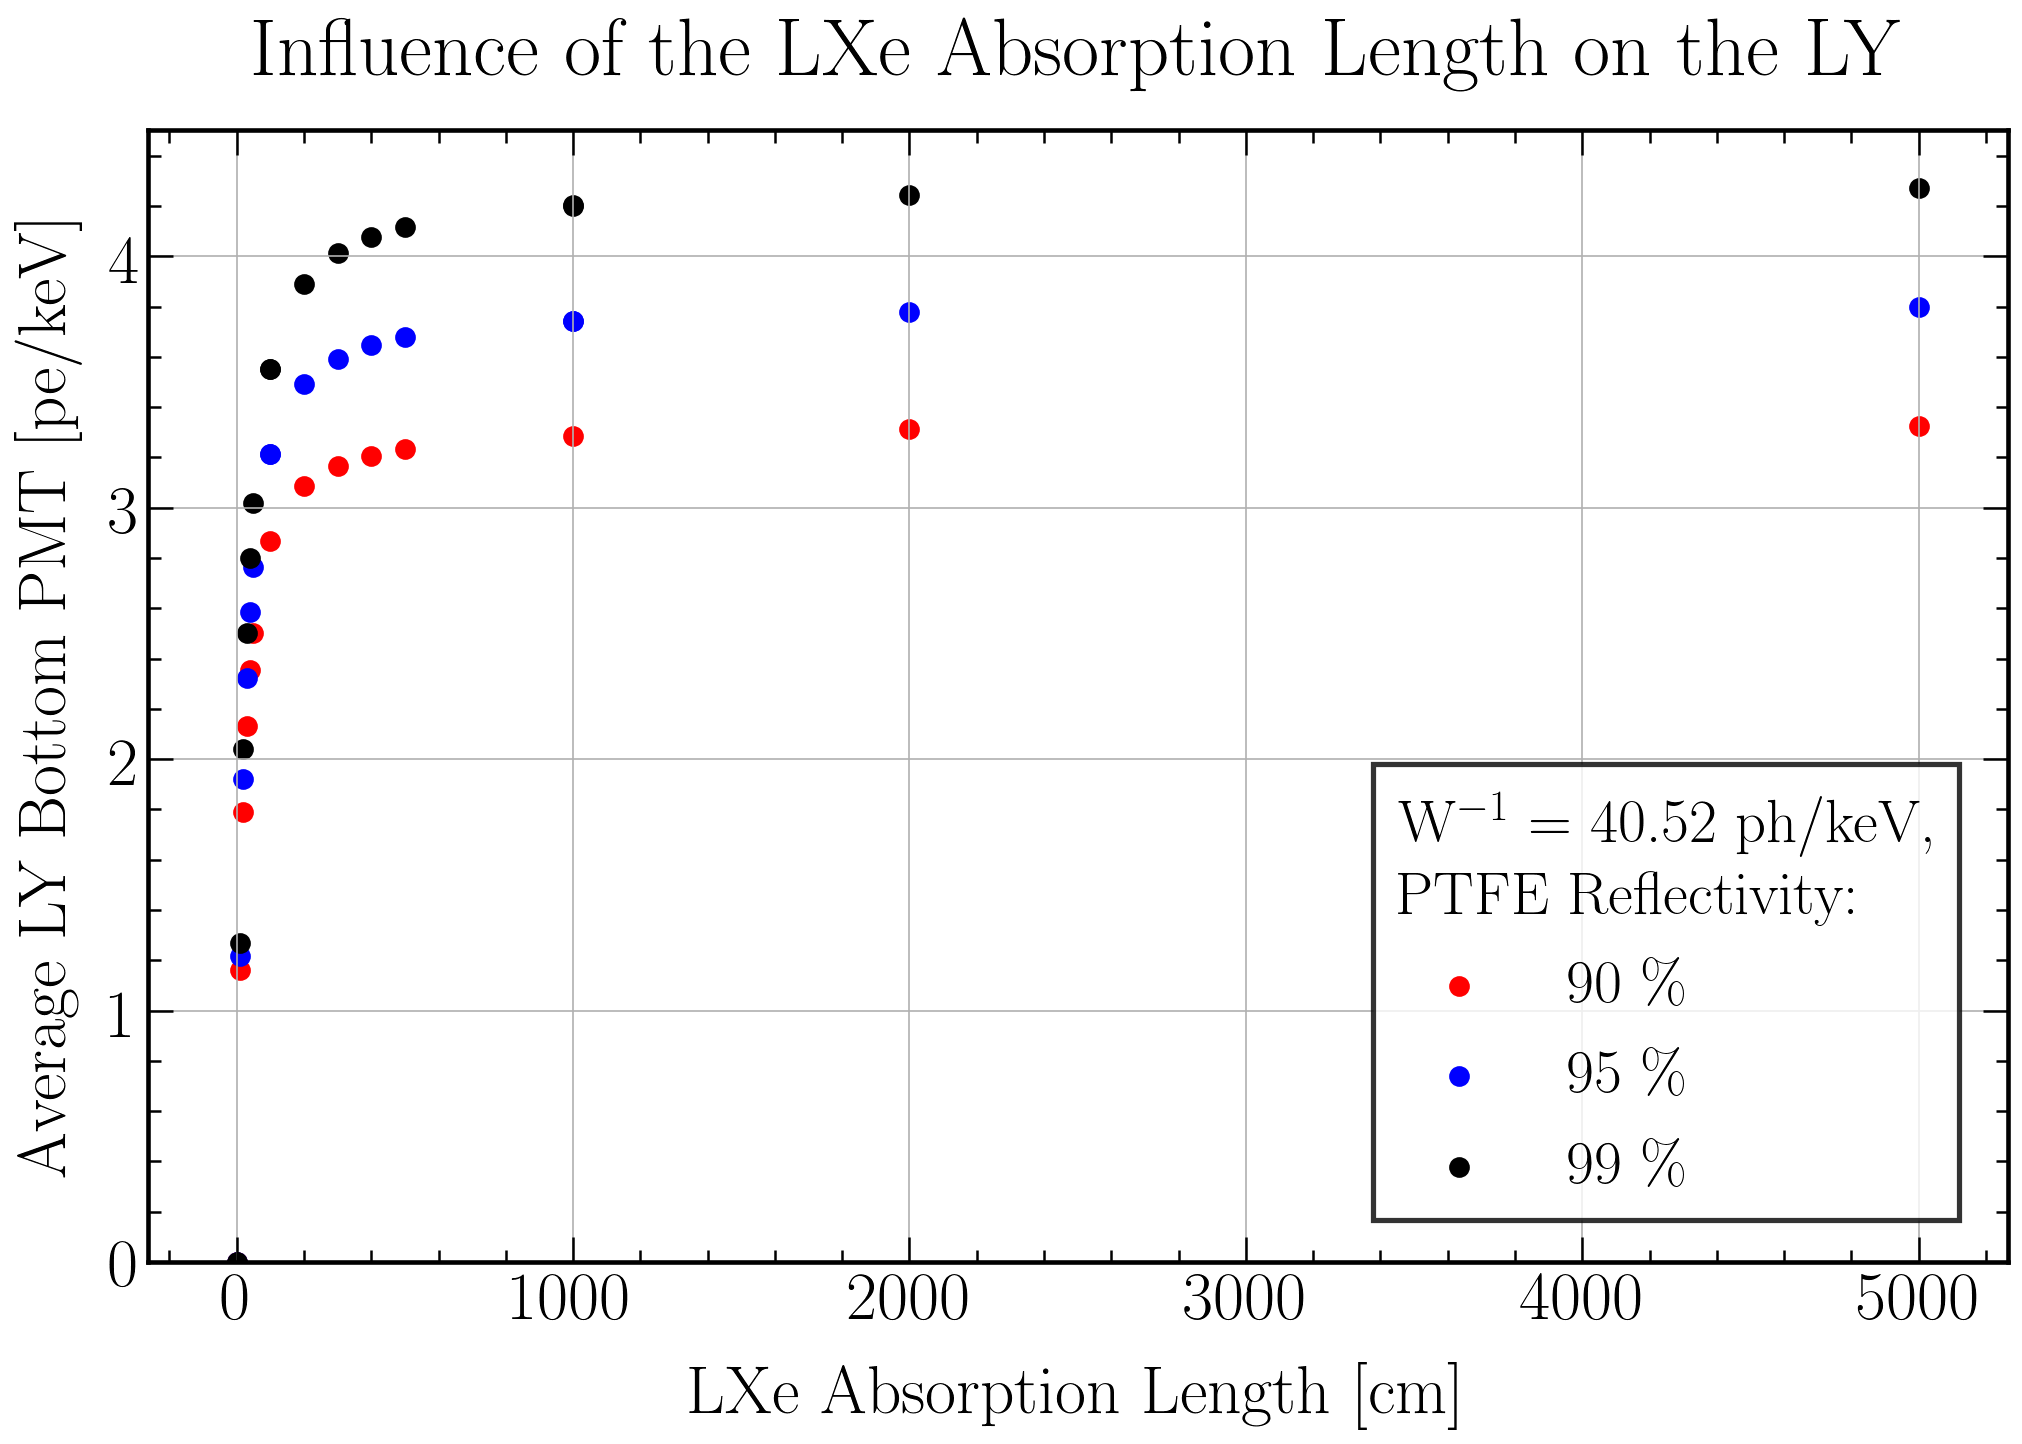

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY_Bottom.png")
plt.show()

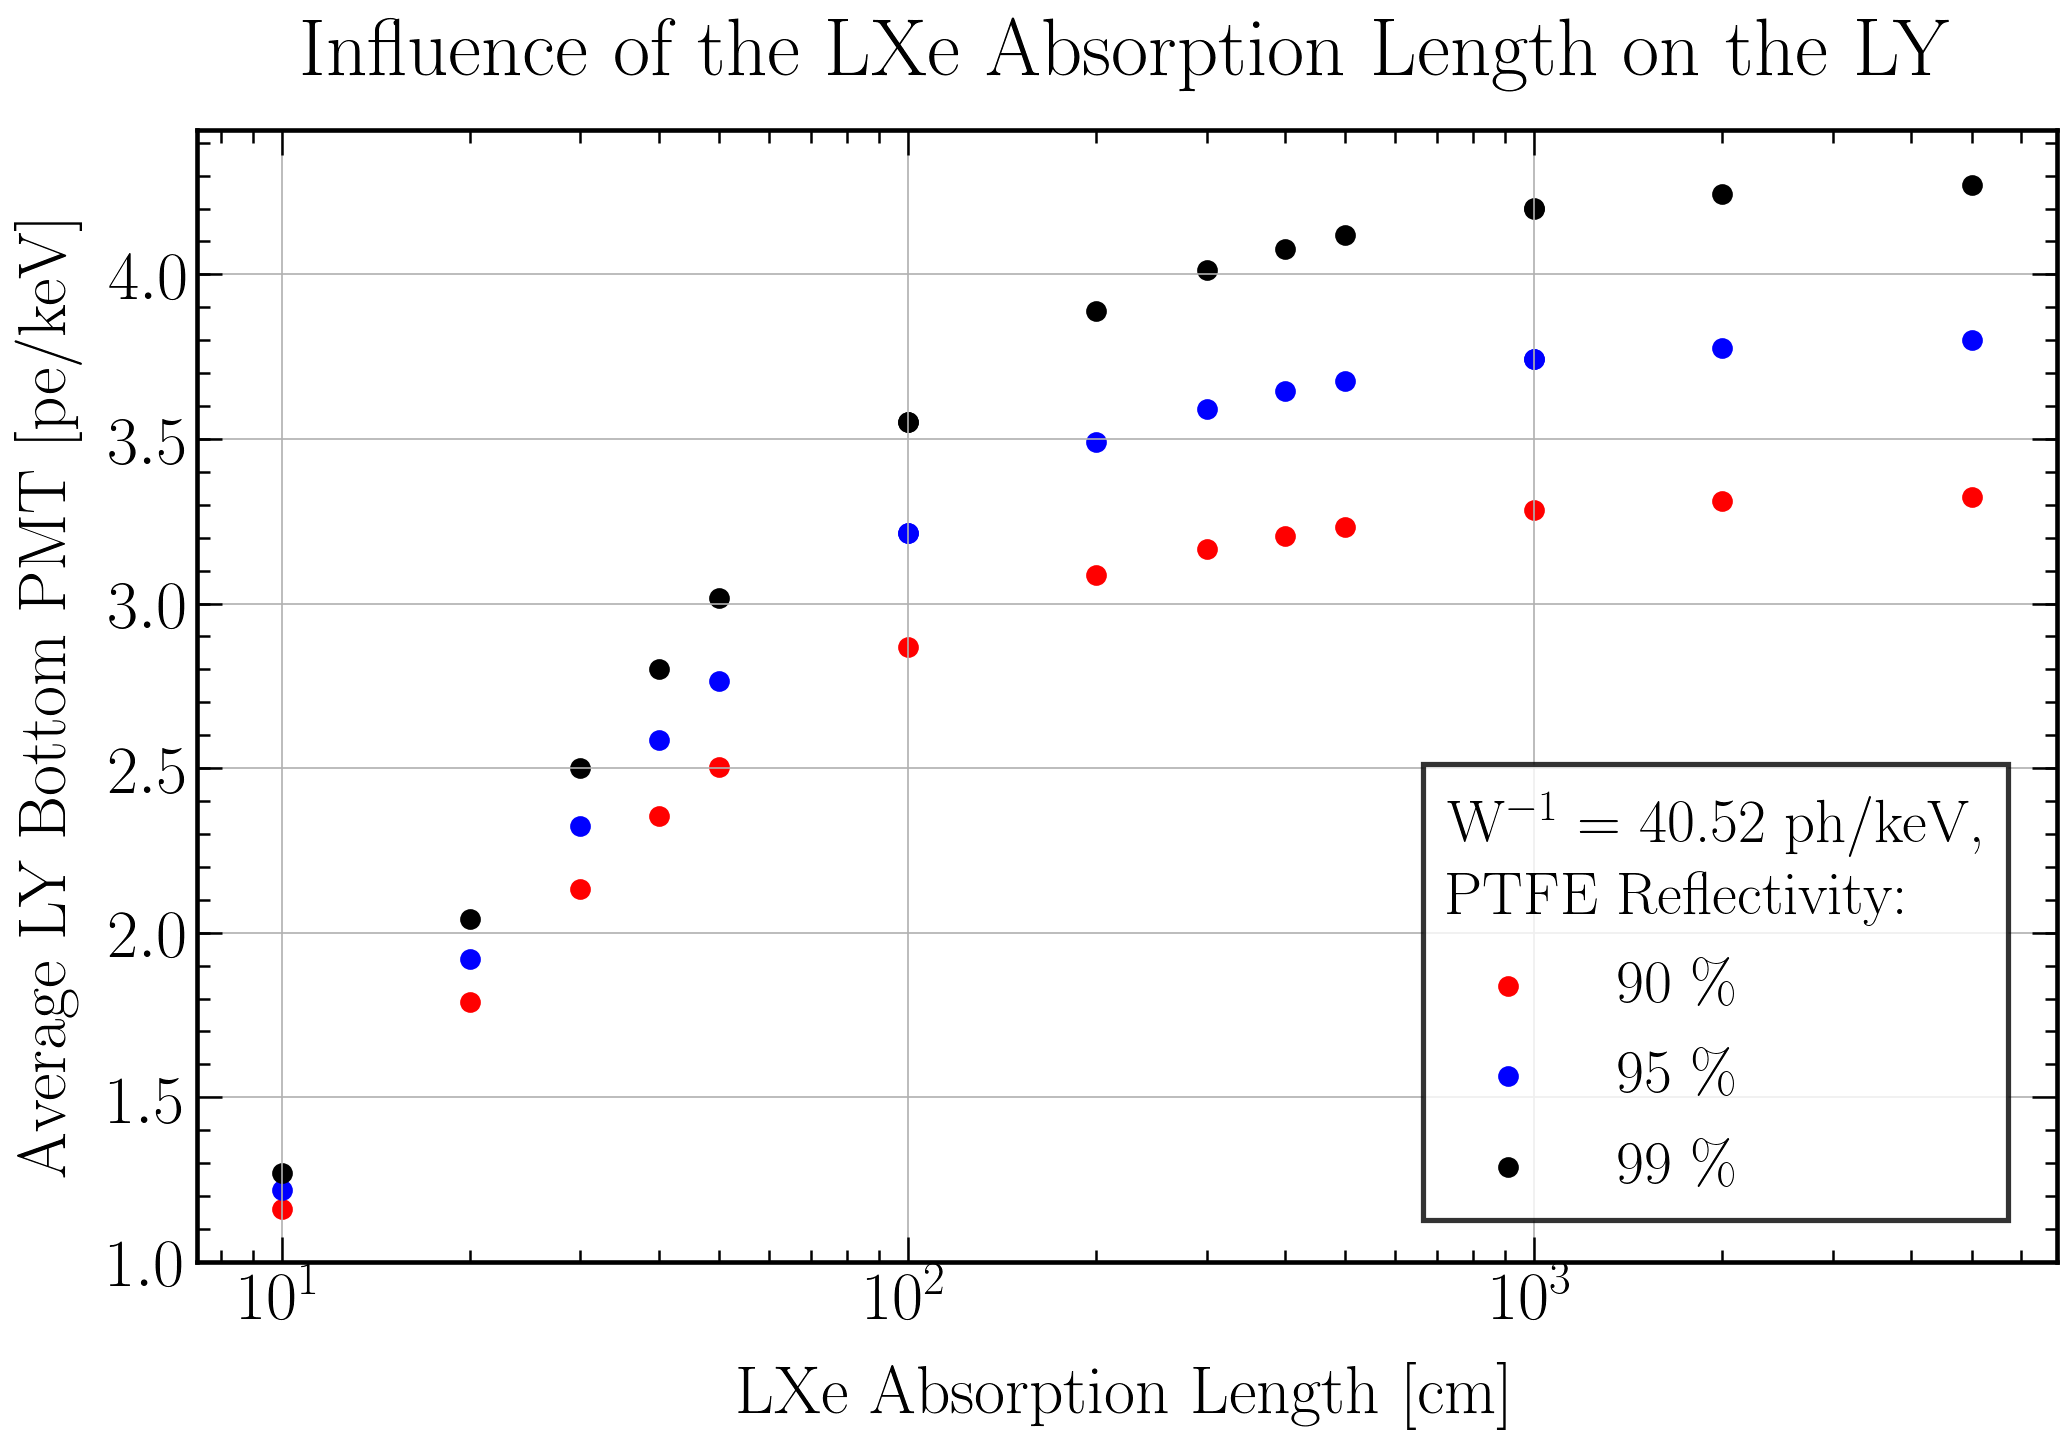

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY_b"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY_Bottom_log.png")
plt.show()

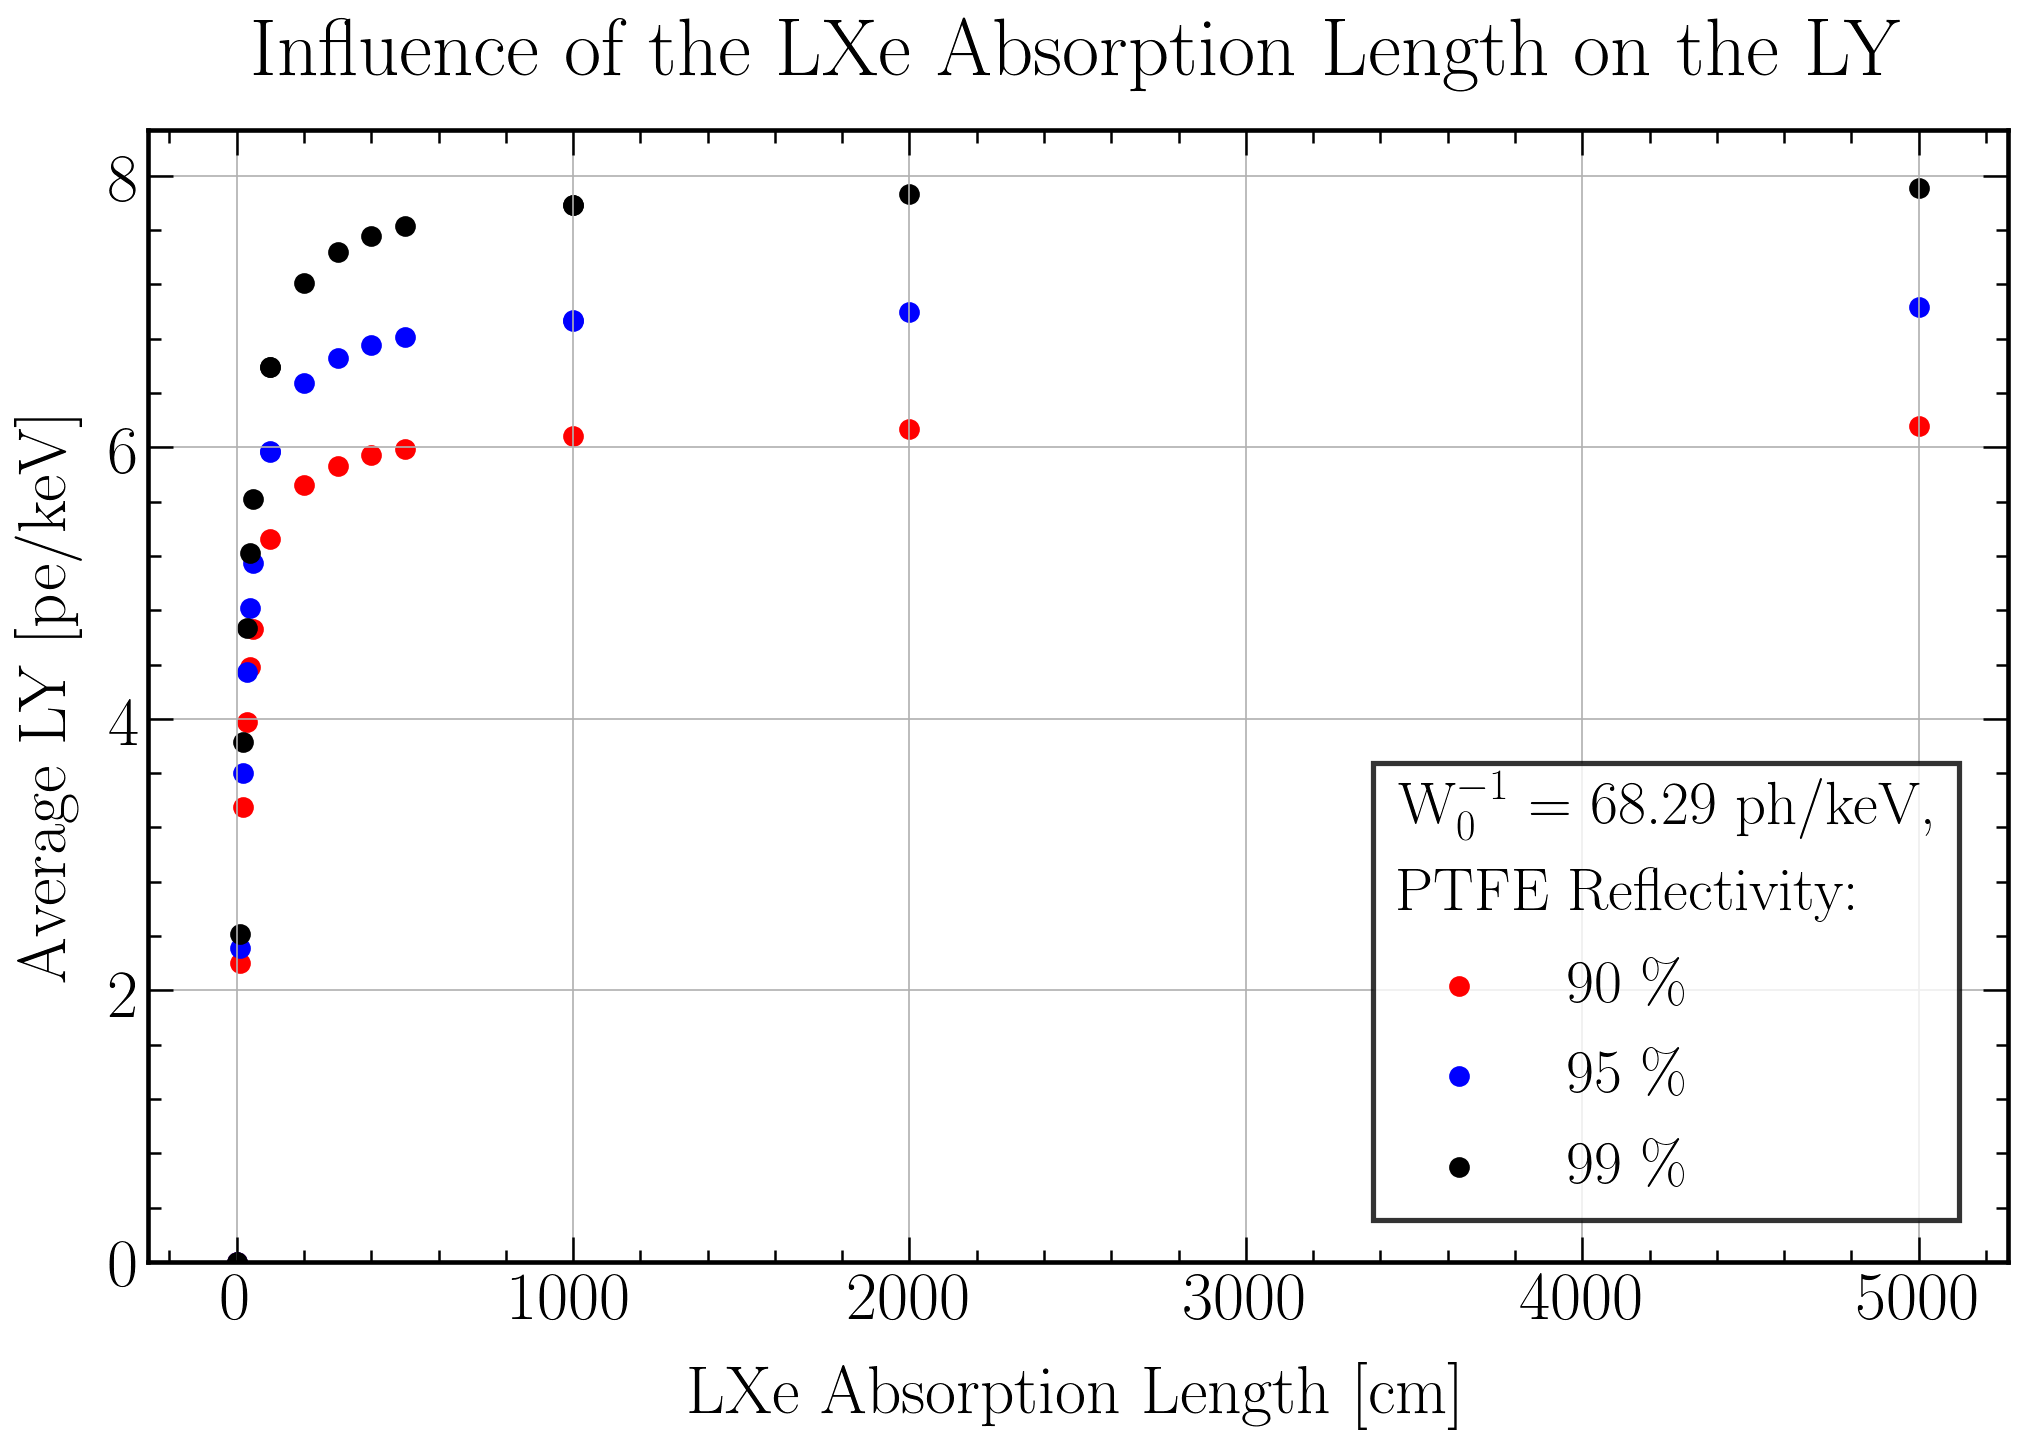

In [26]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY0.png")
plt.show()

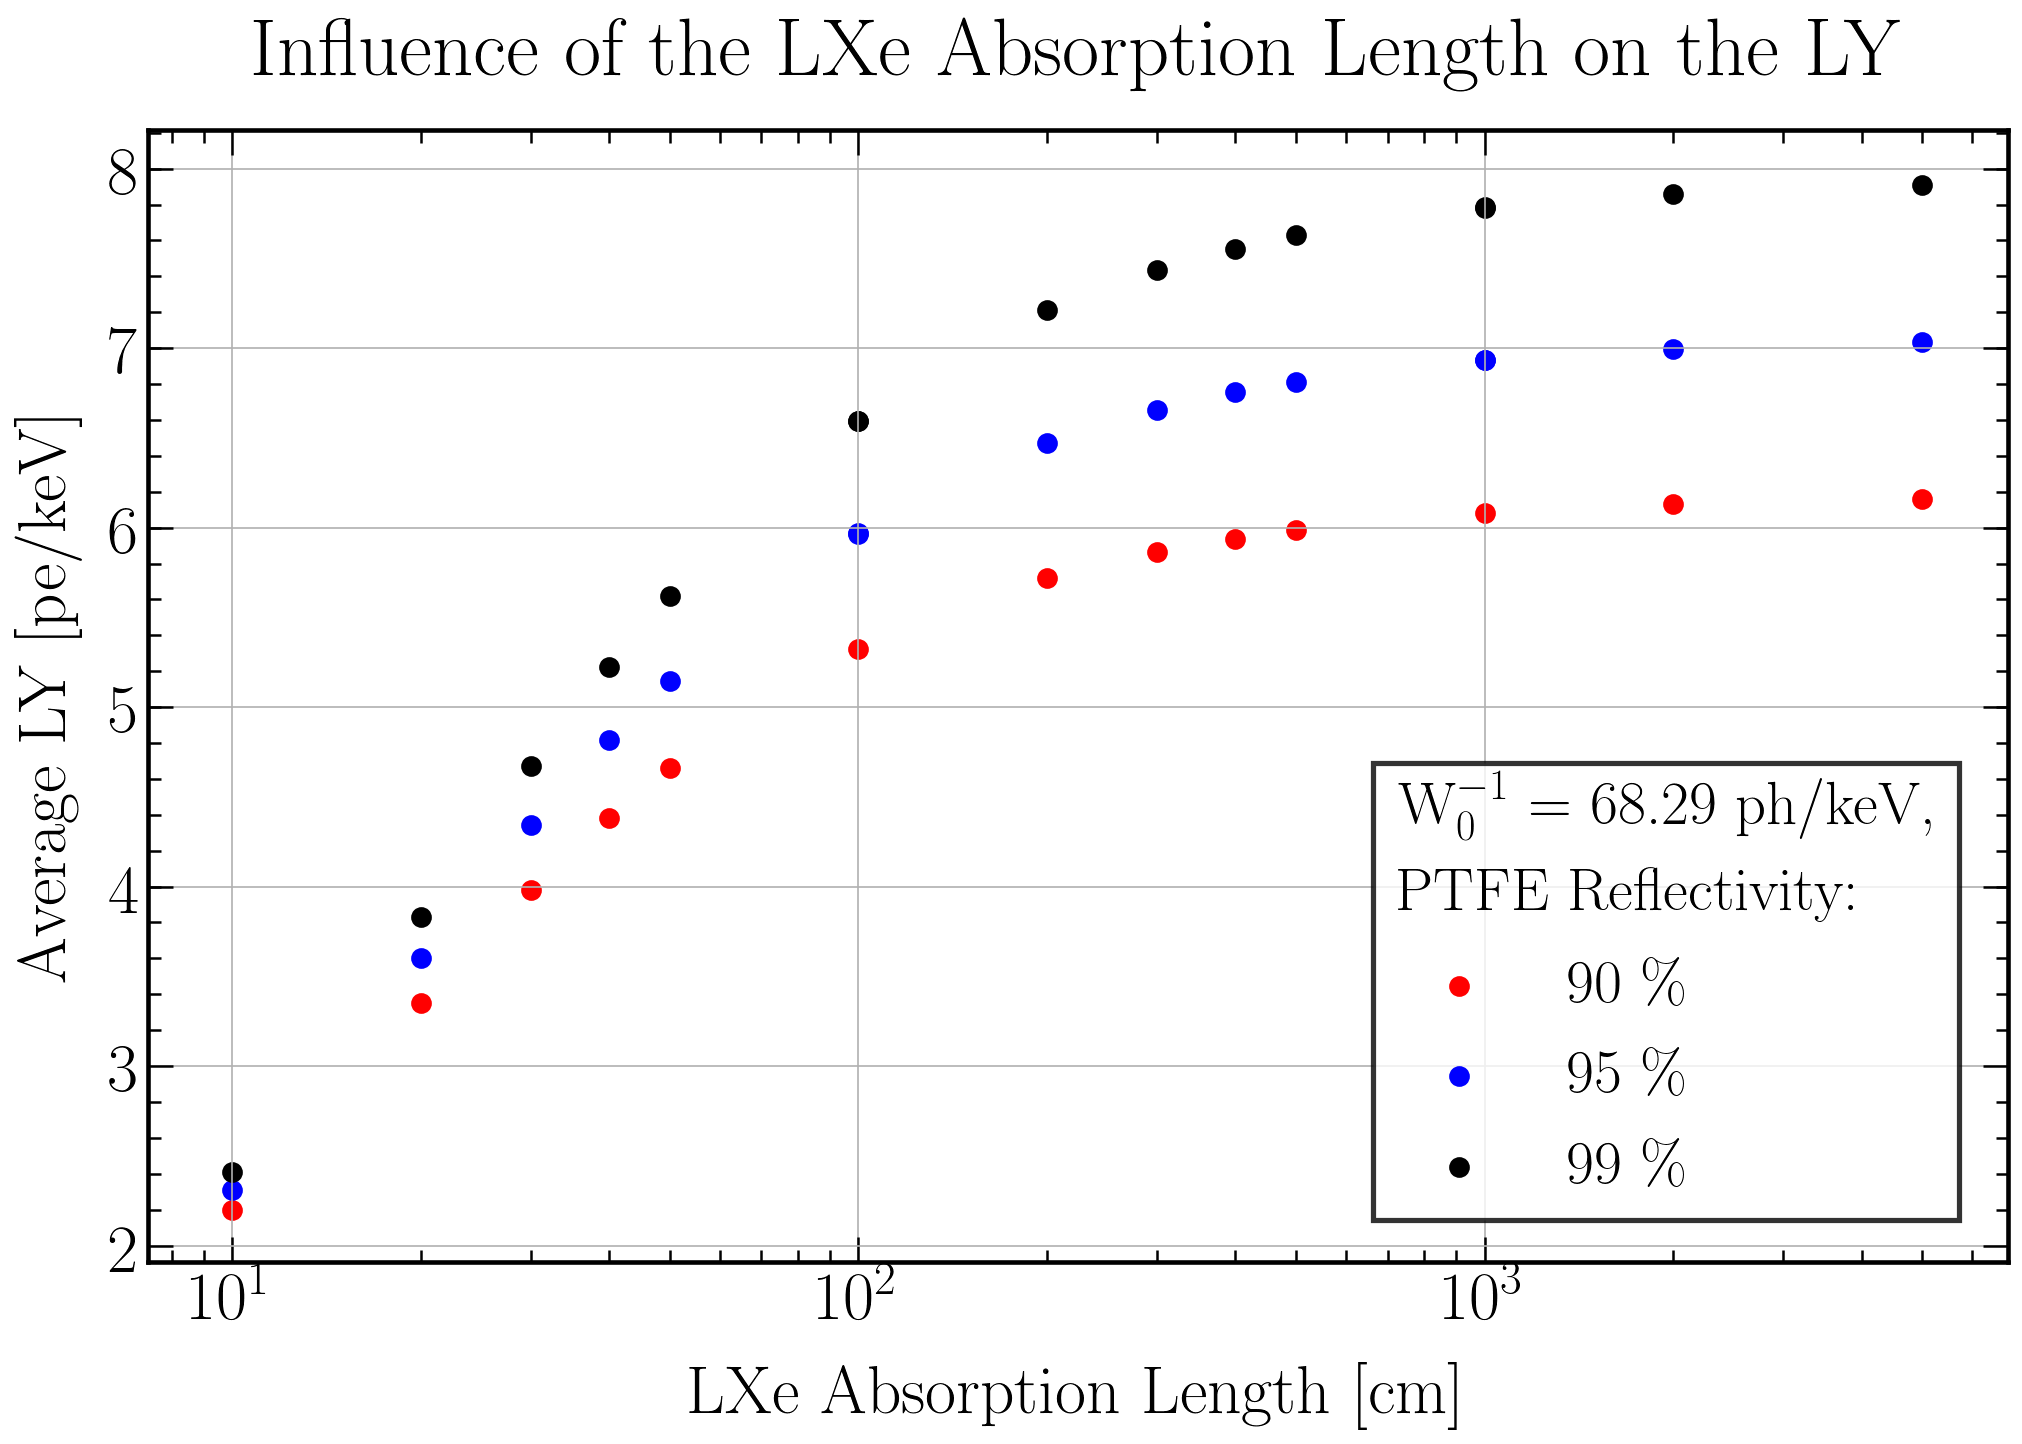

In [27]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_a"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY0_log.png")
plt.show()

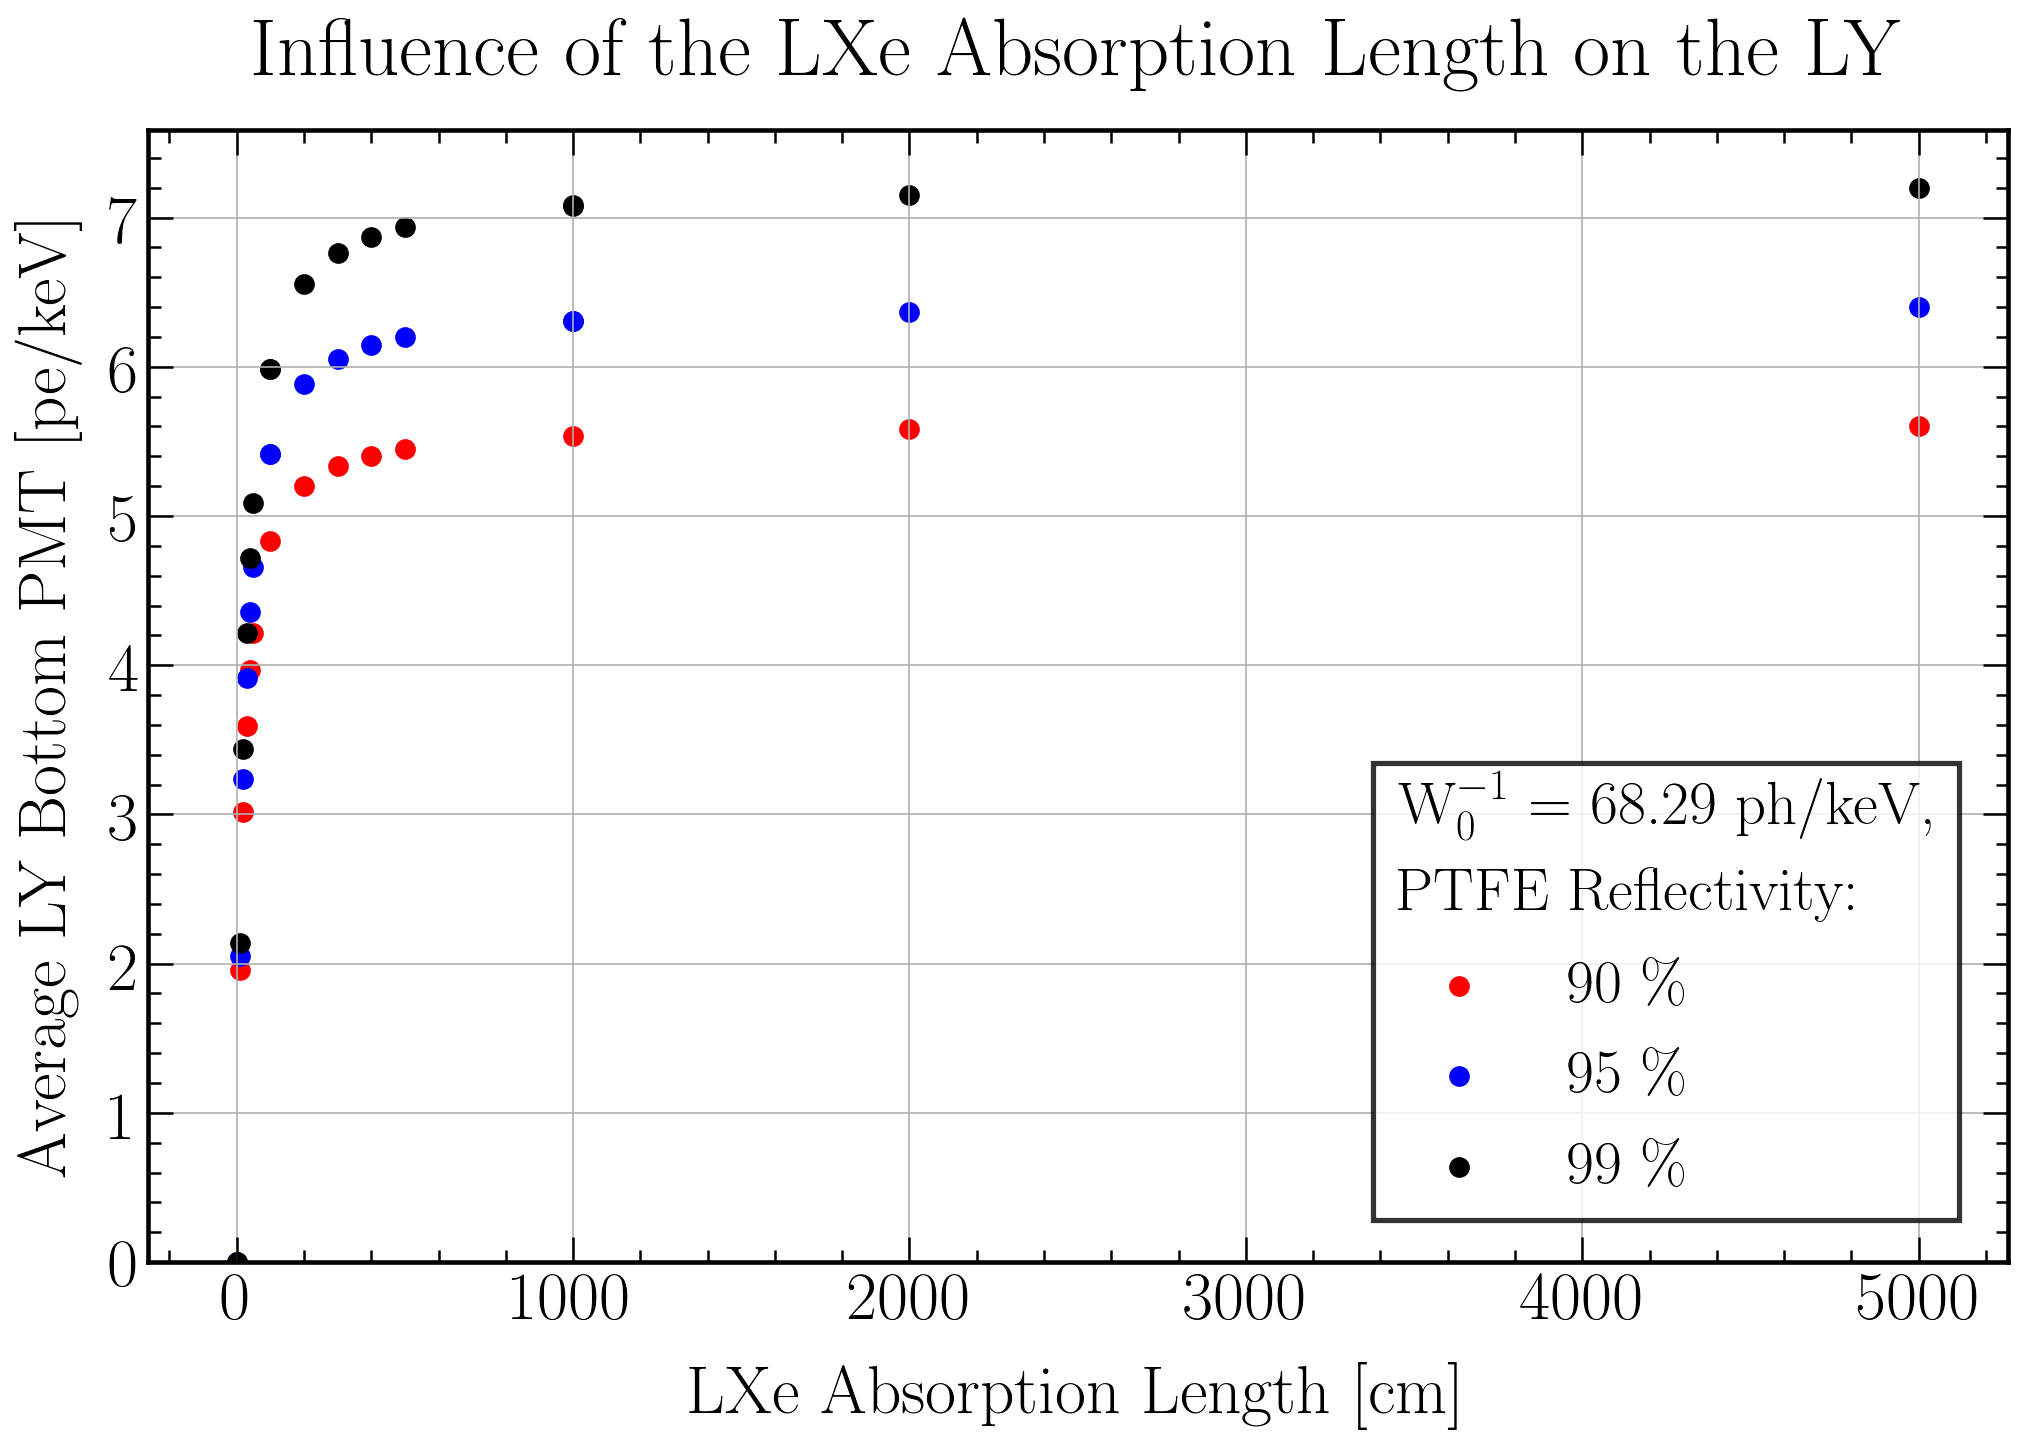

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY0_Bottom.png")
plt.show()

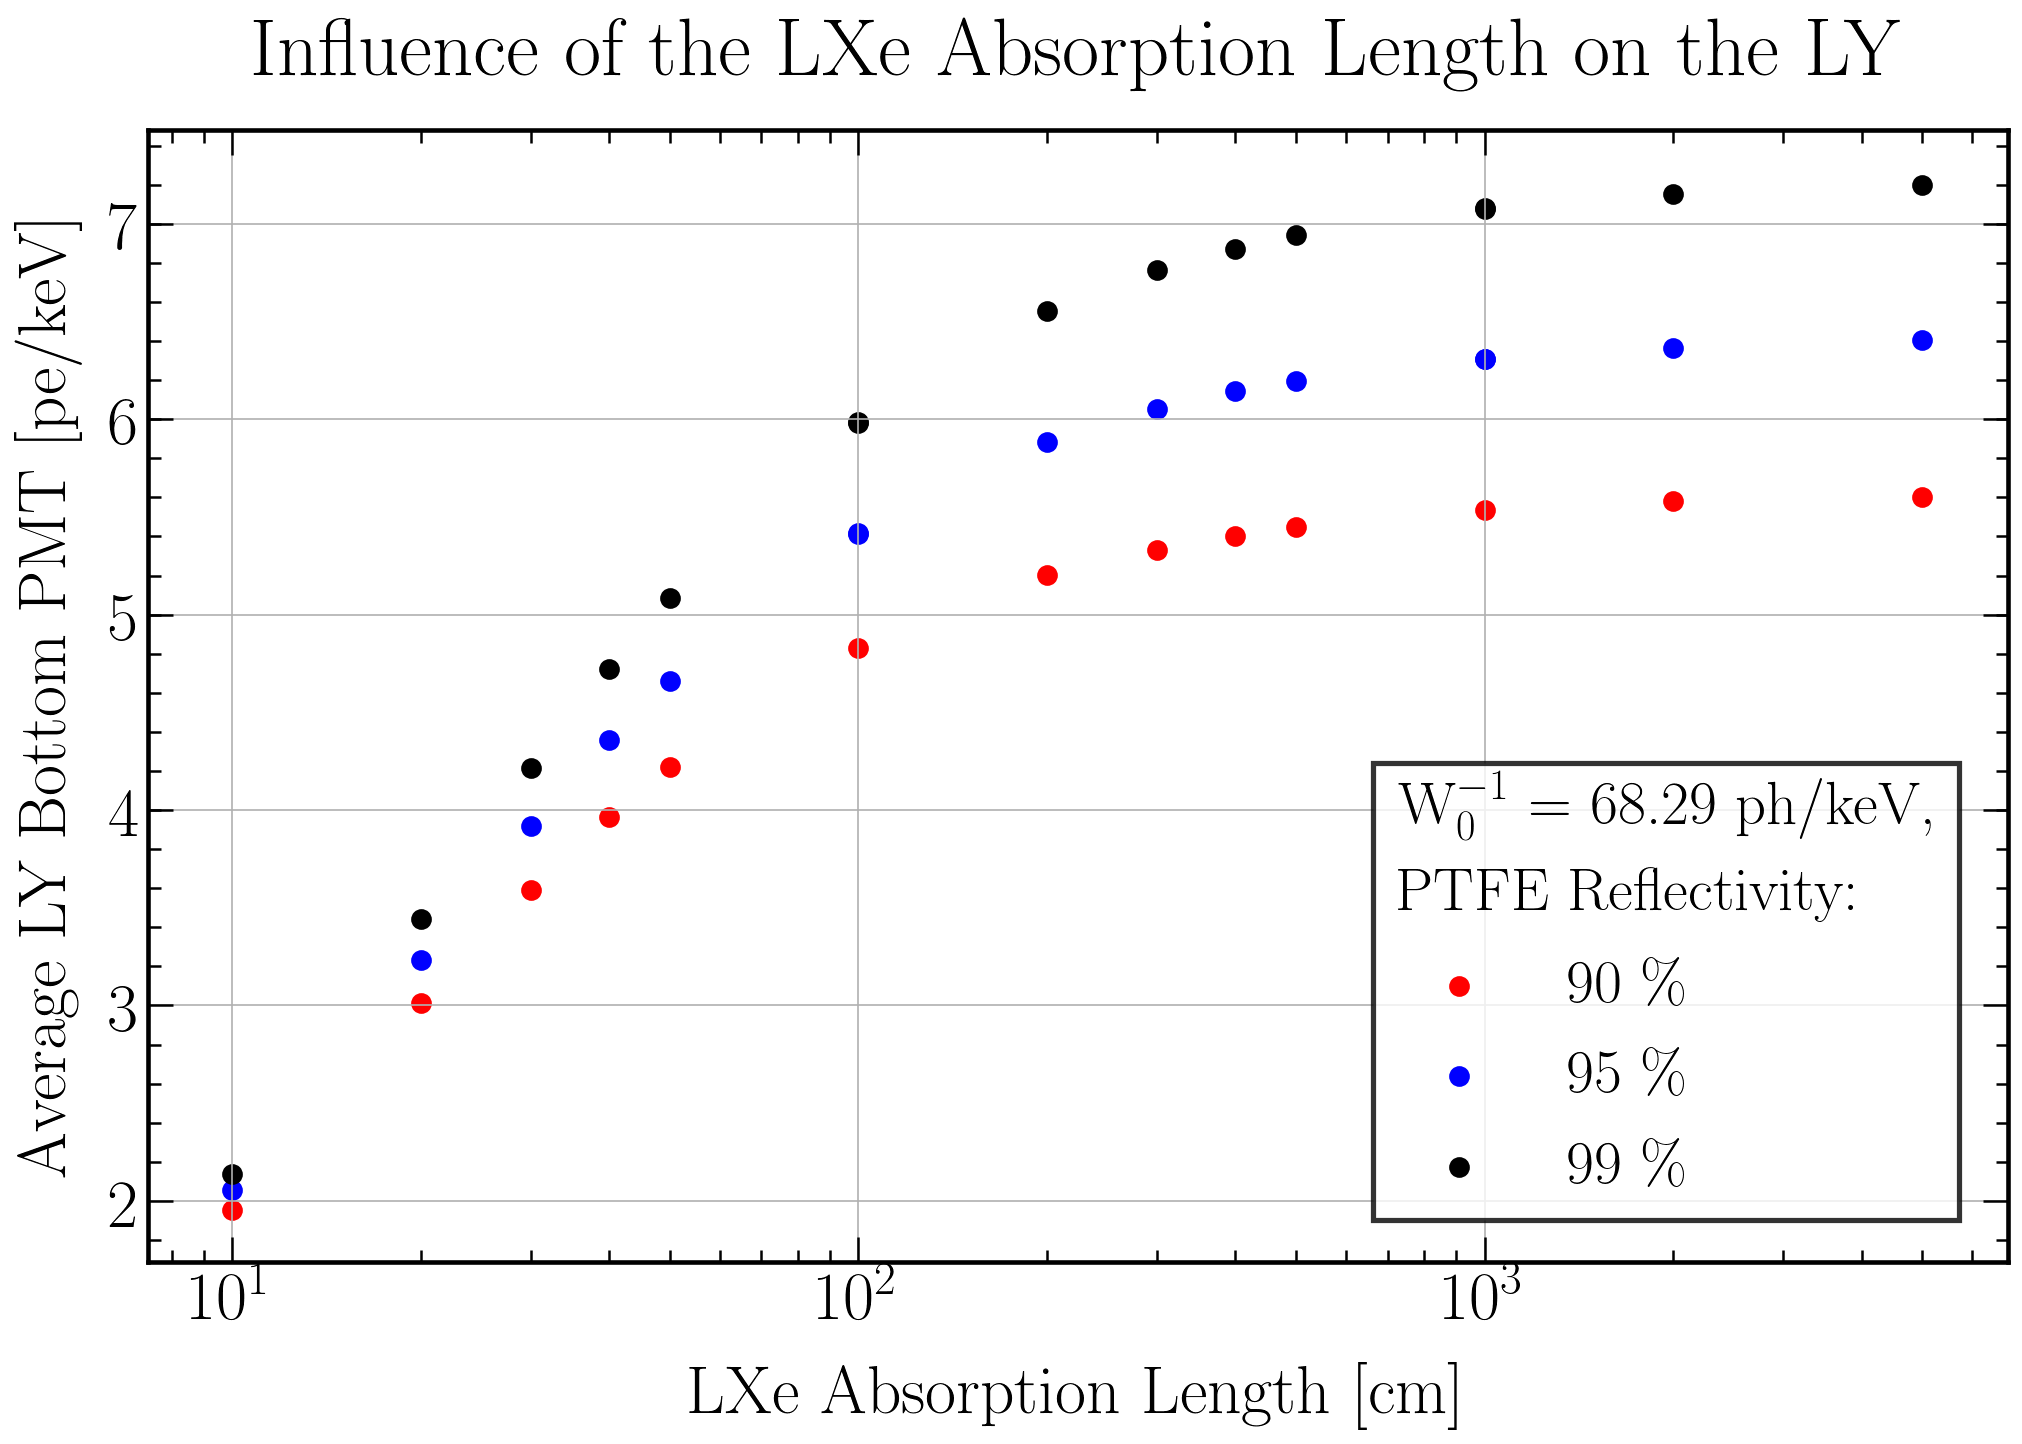

In [29]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.90) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 90 $\%$", color = "red", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.95) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 95 $\%$", color = "blue", s = 80)

x = opticals["LXeAbs"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
y = opticals["LY0_b"][(opticals["LXeAbs"] > 0) & (opticals["RPTFE"] == 0.99) & (opticals["Tmesh"] == 0.89770509)]
plt.scatter(x,y, label = " 99 $\%$", color = "black", s = 80)

plt.xlabel('LXe Absorption Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Absorption Length on the LY', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\n"+"PTFE Reflectivity:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.12)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
plt.gca().set_xscale('log')

fig.savefig("Influence_LXeAbsLen_LY0_Bottom_log.png")
plt.show()

## Influence of the Mesh Transparency on the LCE

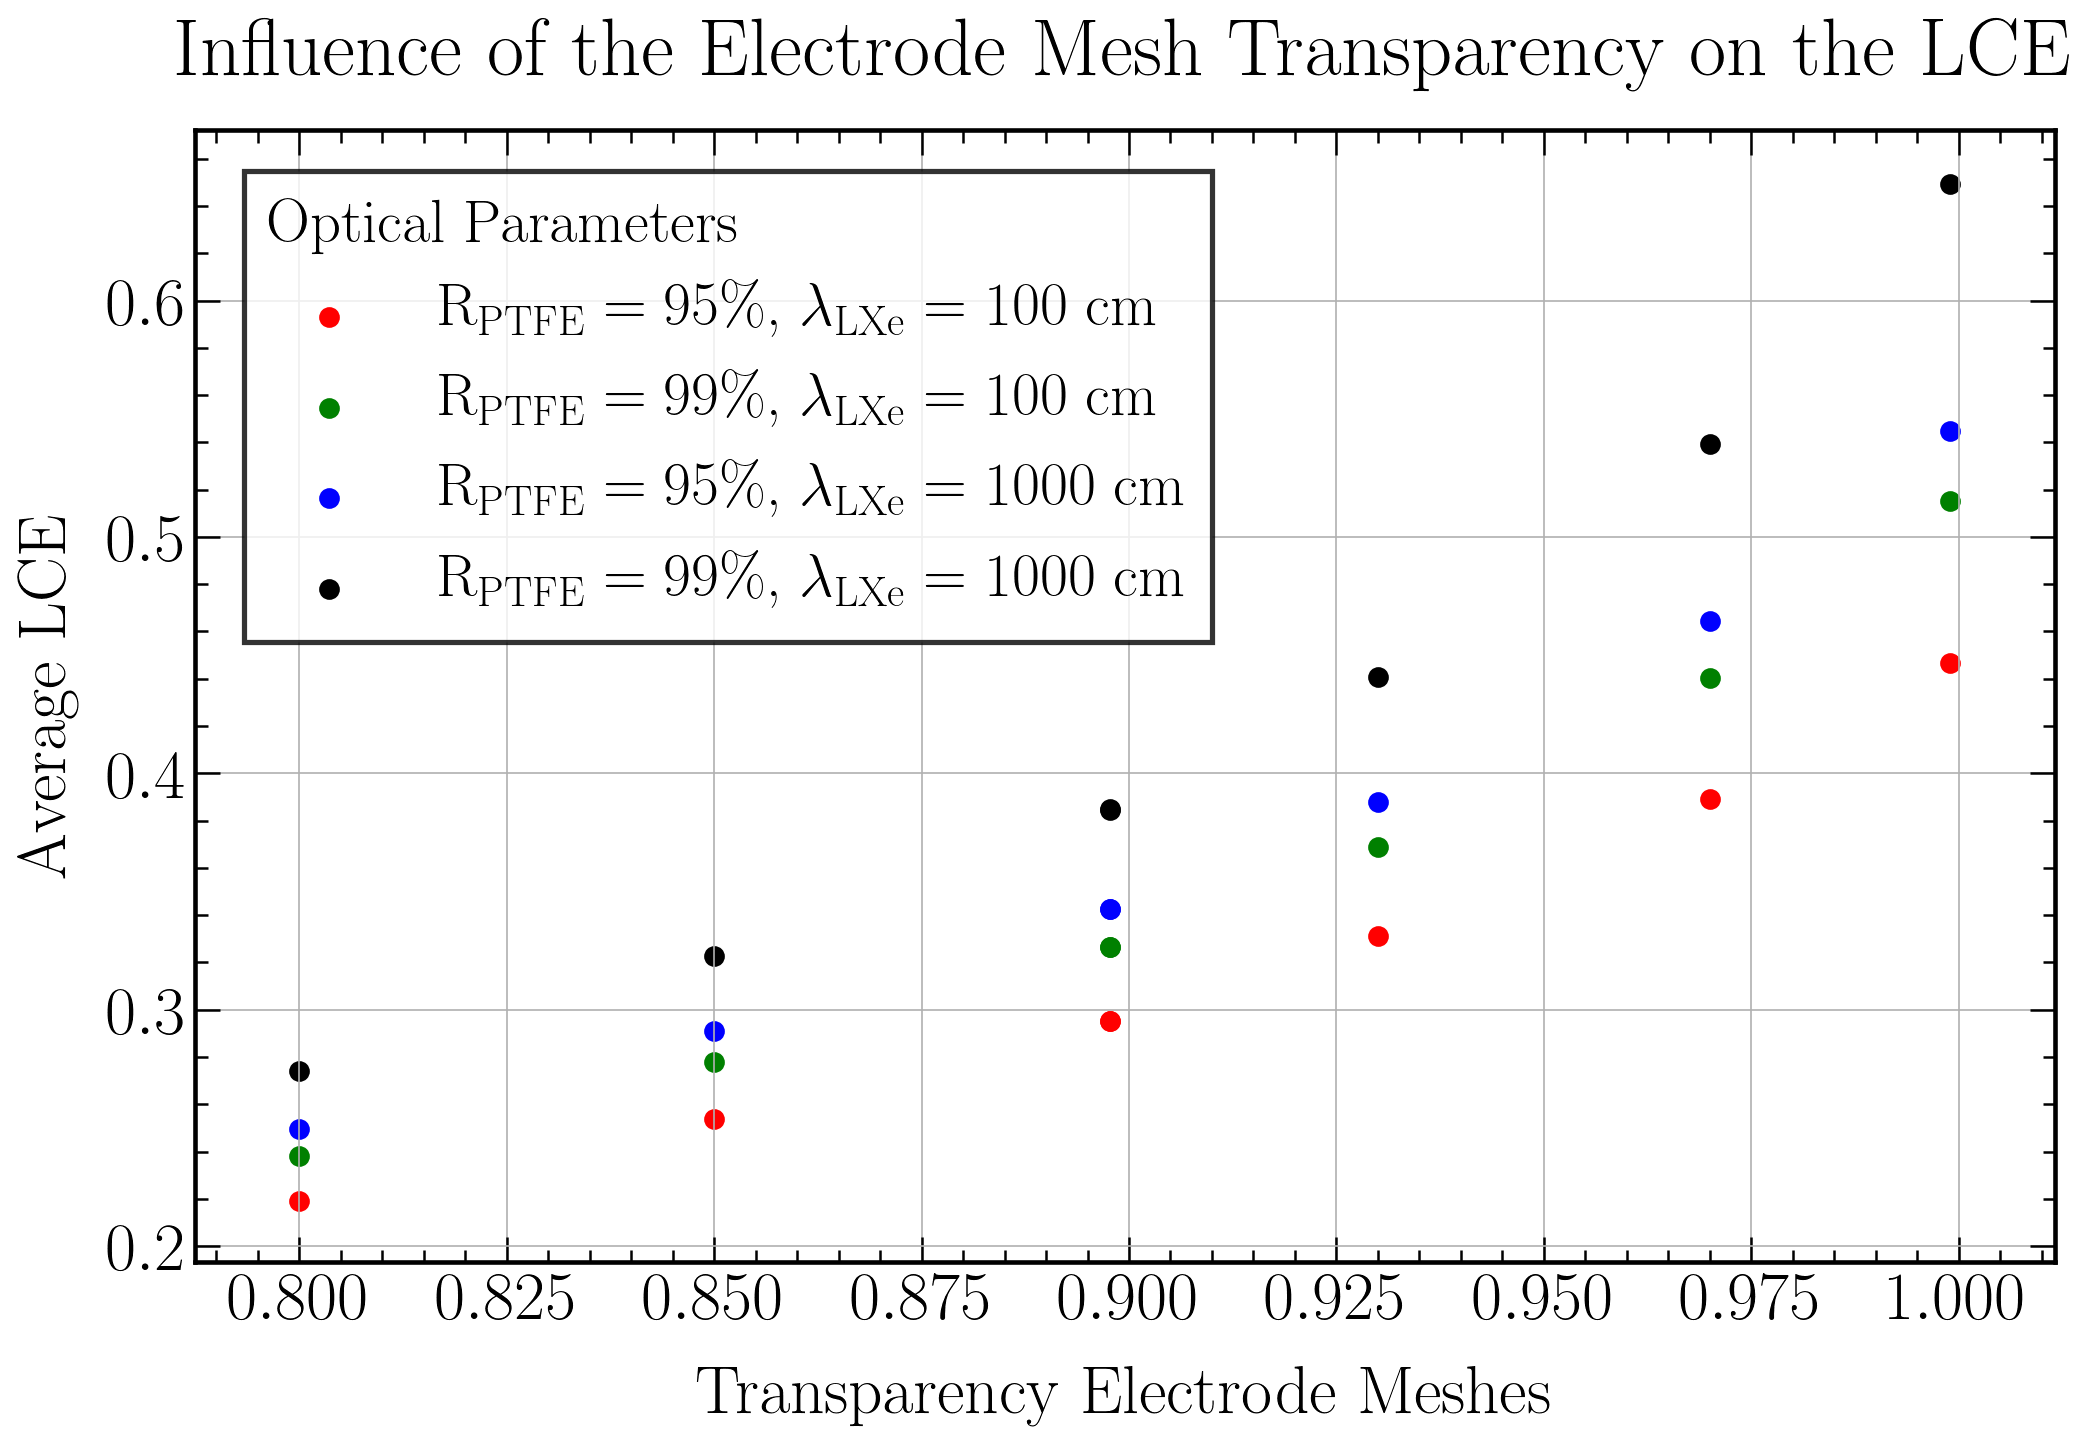

In [30]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the LCE', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_LCE.png")
plt.show()

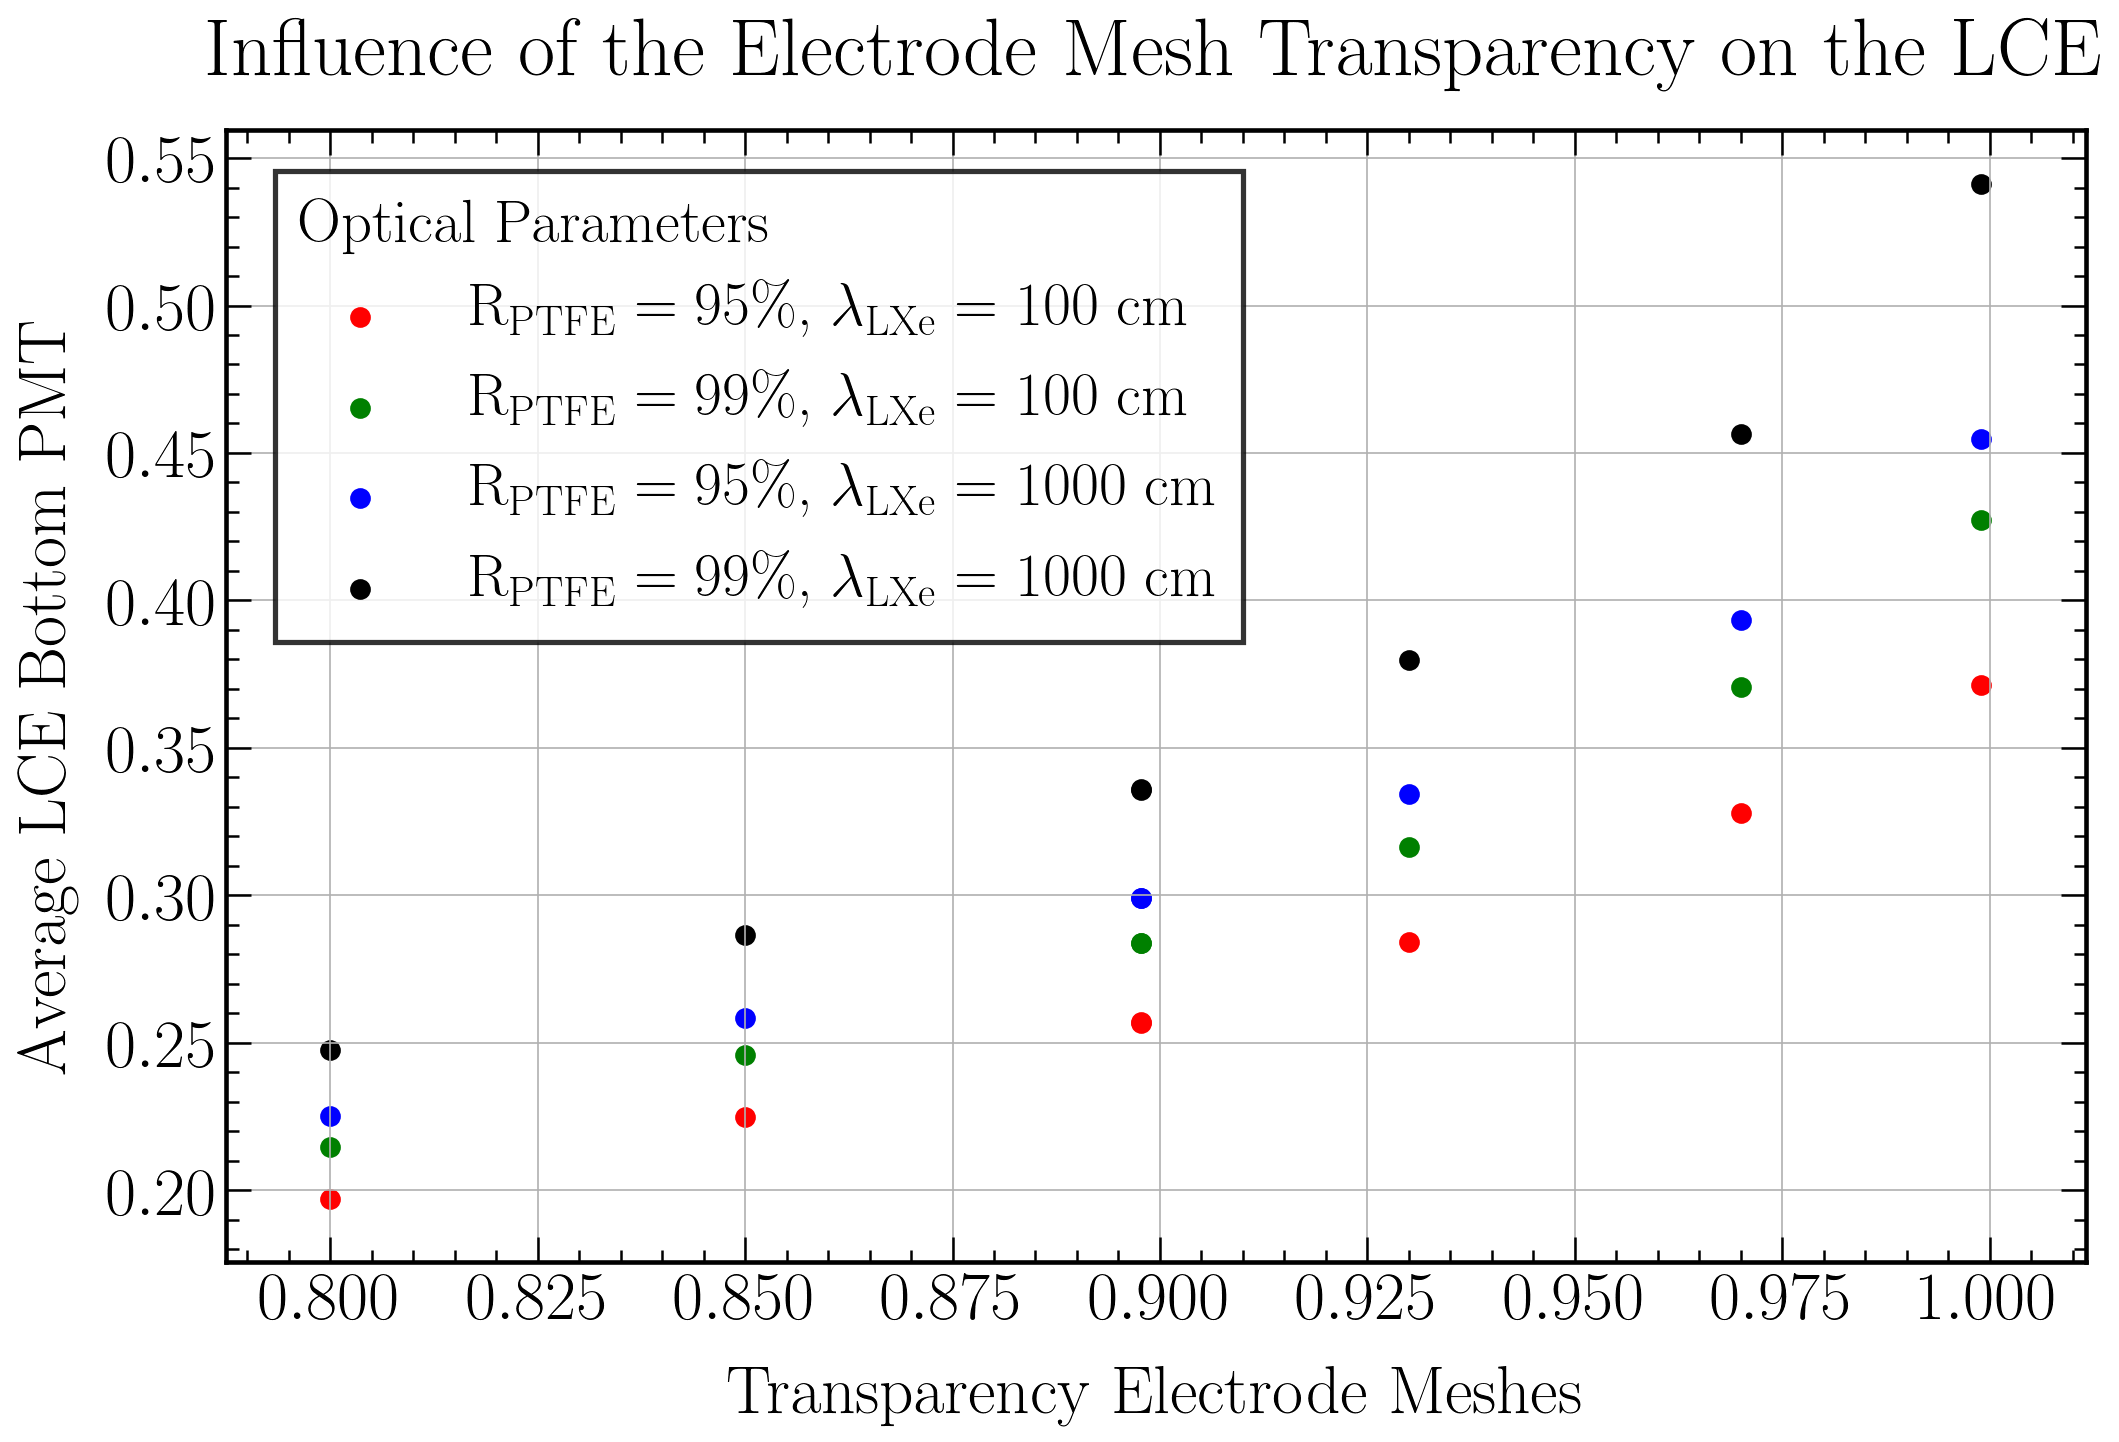

In [31]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the LCE', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_LCE_Bottom.png")
plt.show()

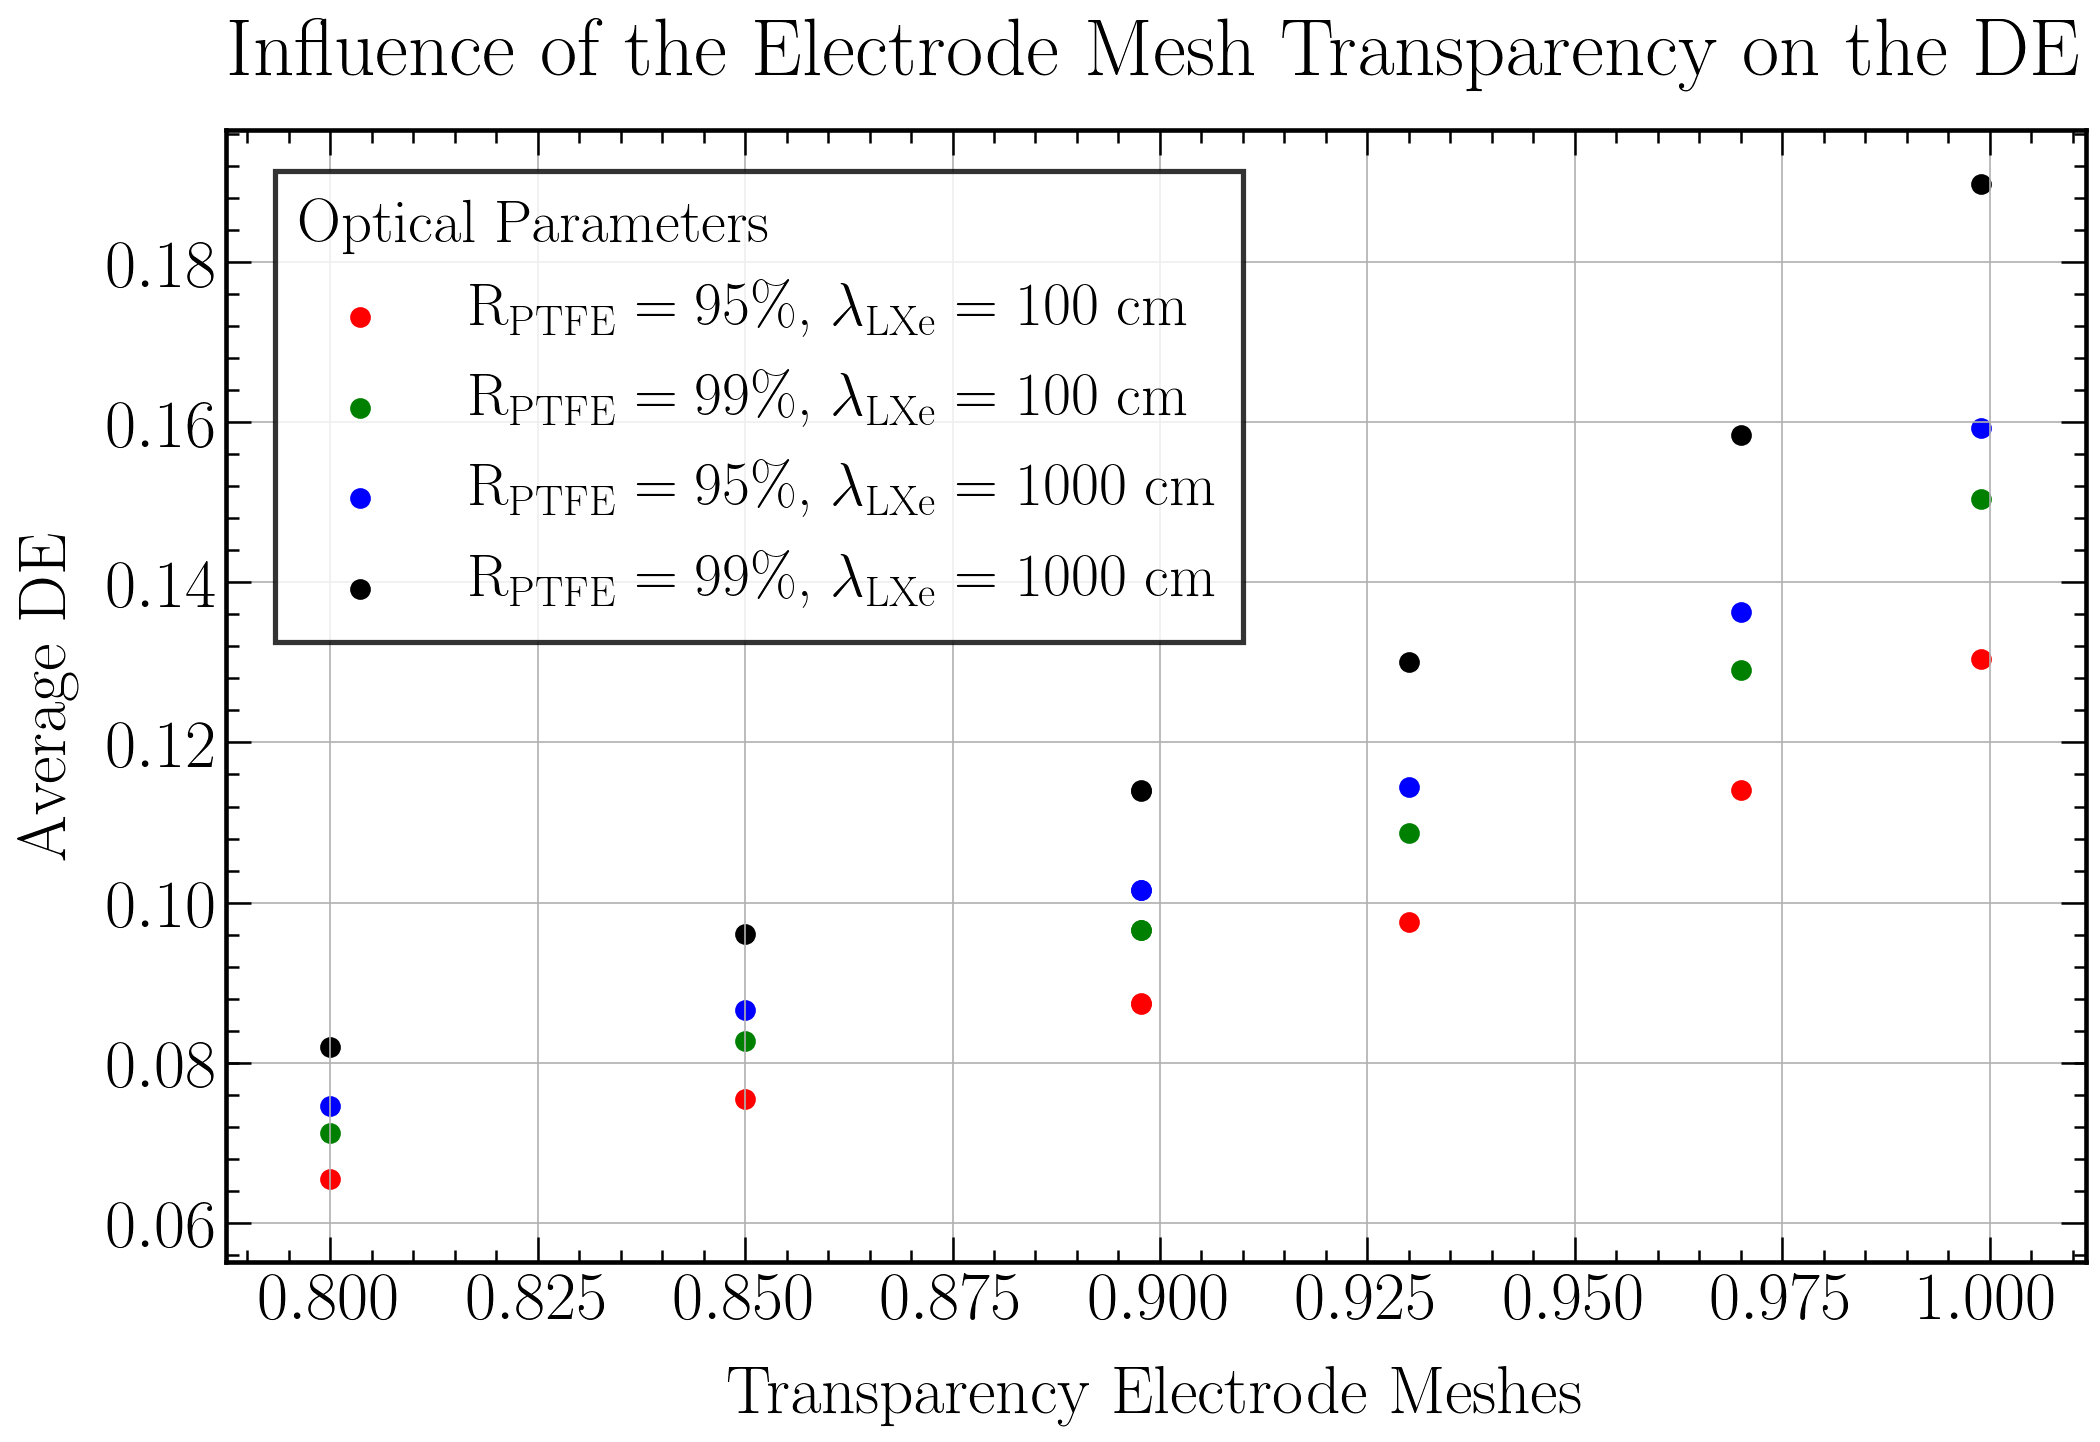

In [32]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the DE', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_DE.png")
plt.show()

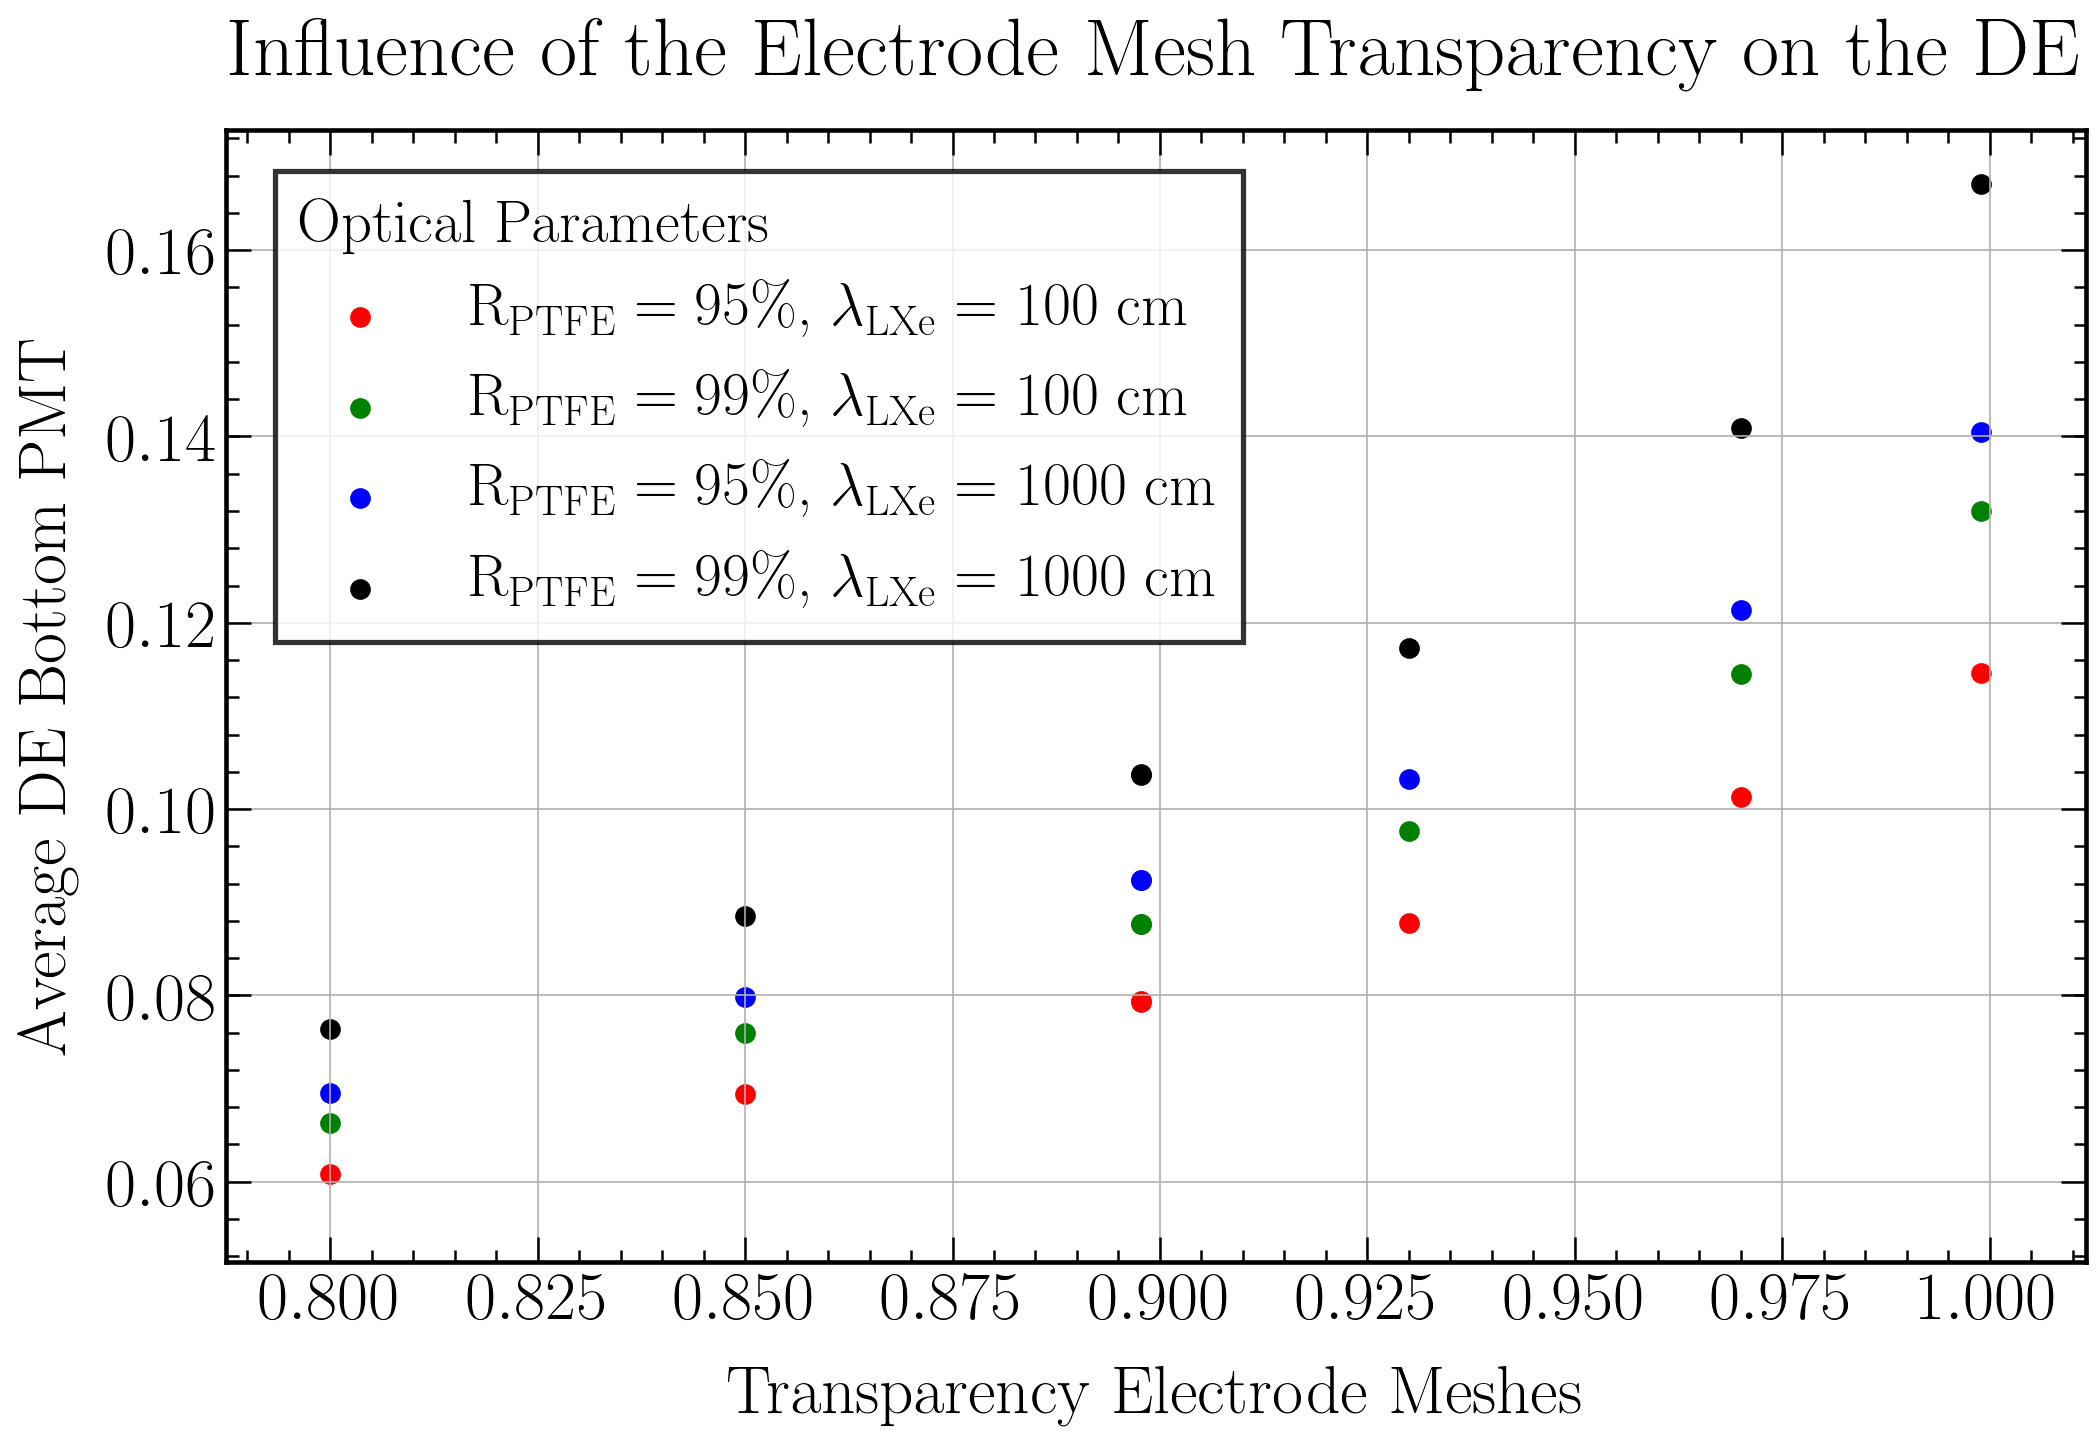

In [33]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the DE', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_DE_Bottom.png")
plt.show()

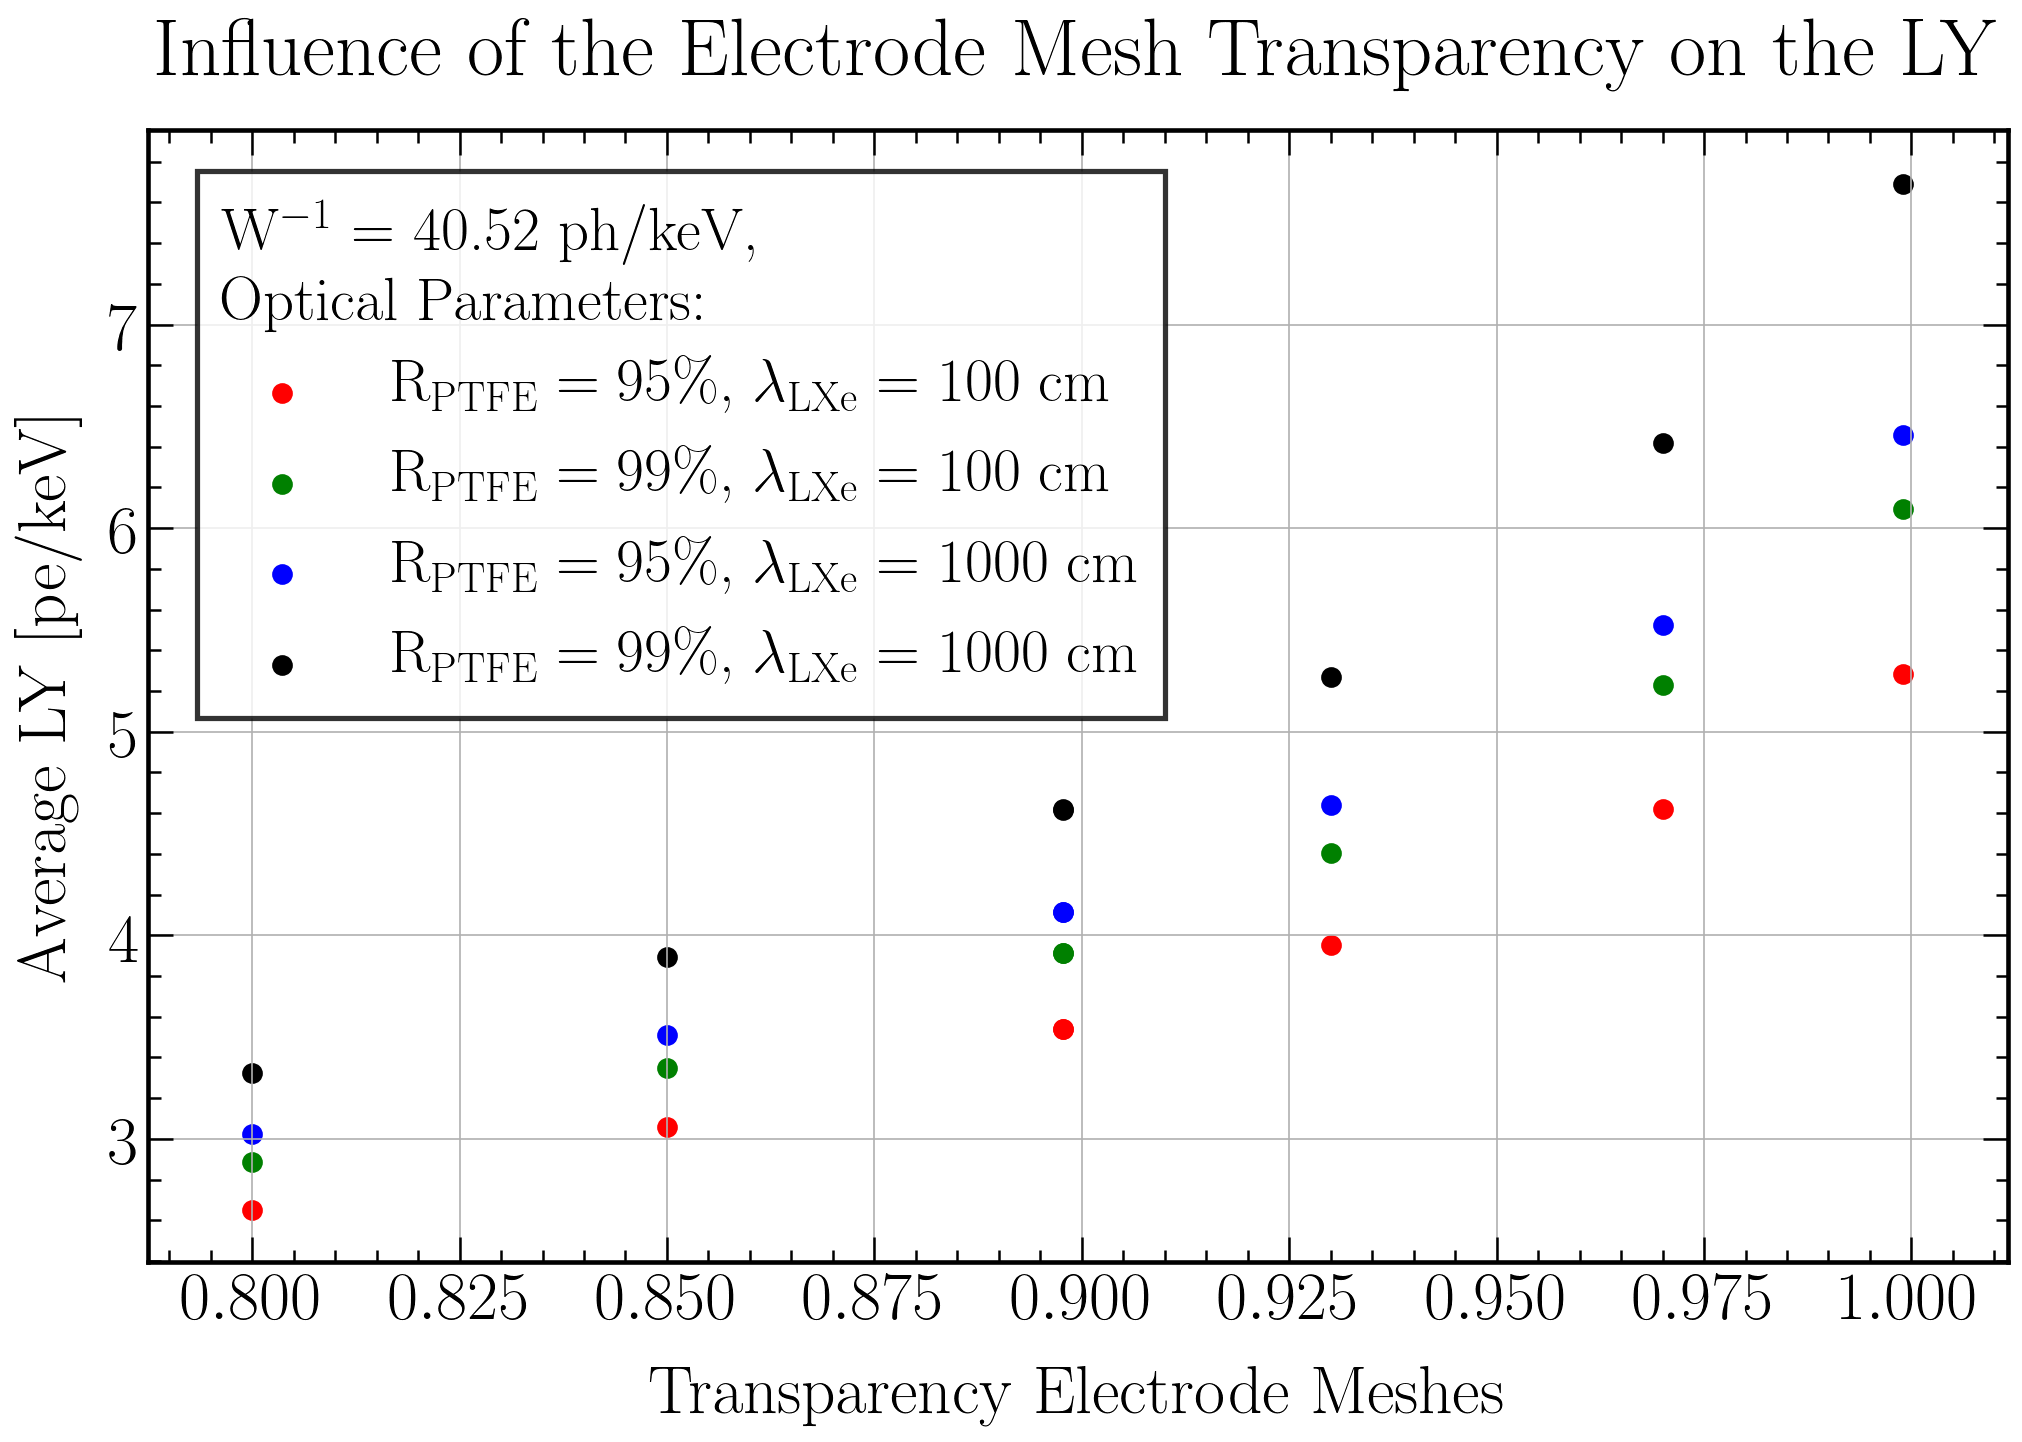

In [34]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the LY', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_LY.png")
plt.show()

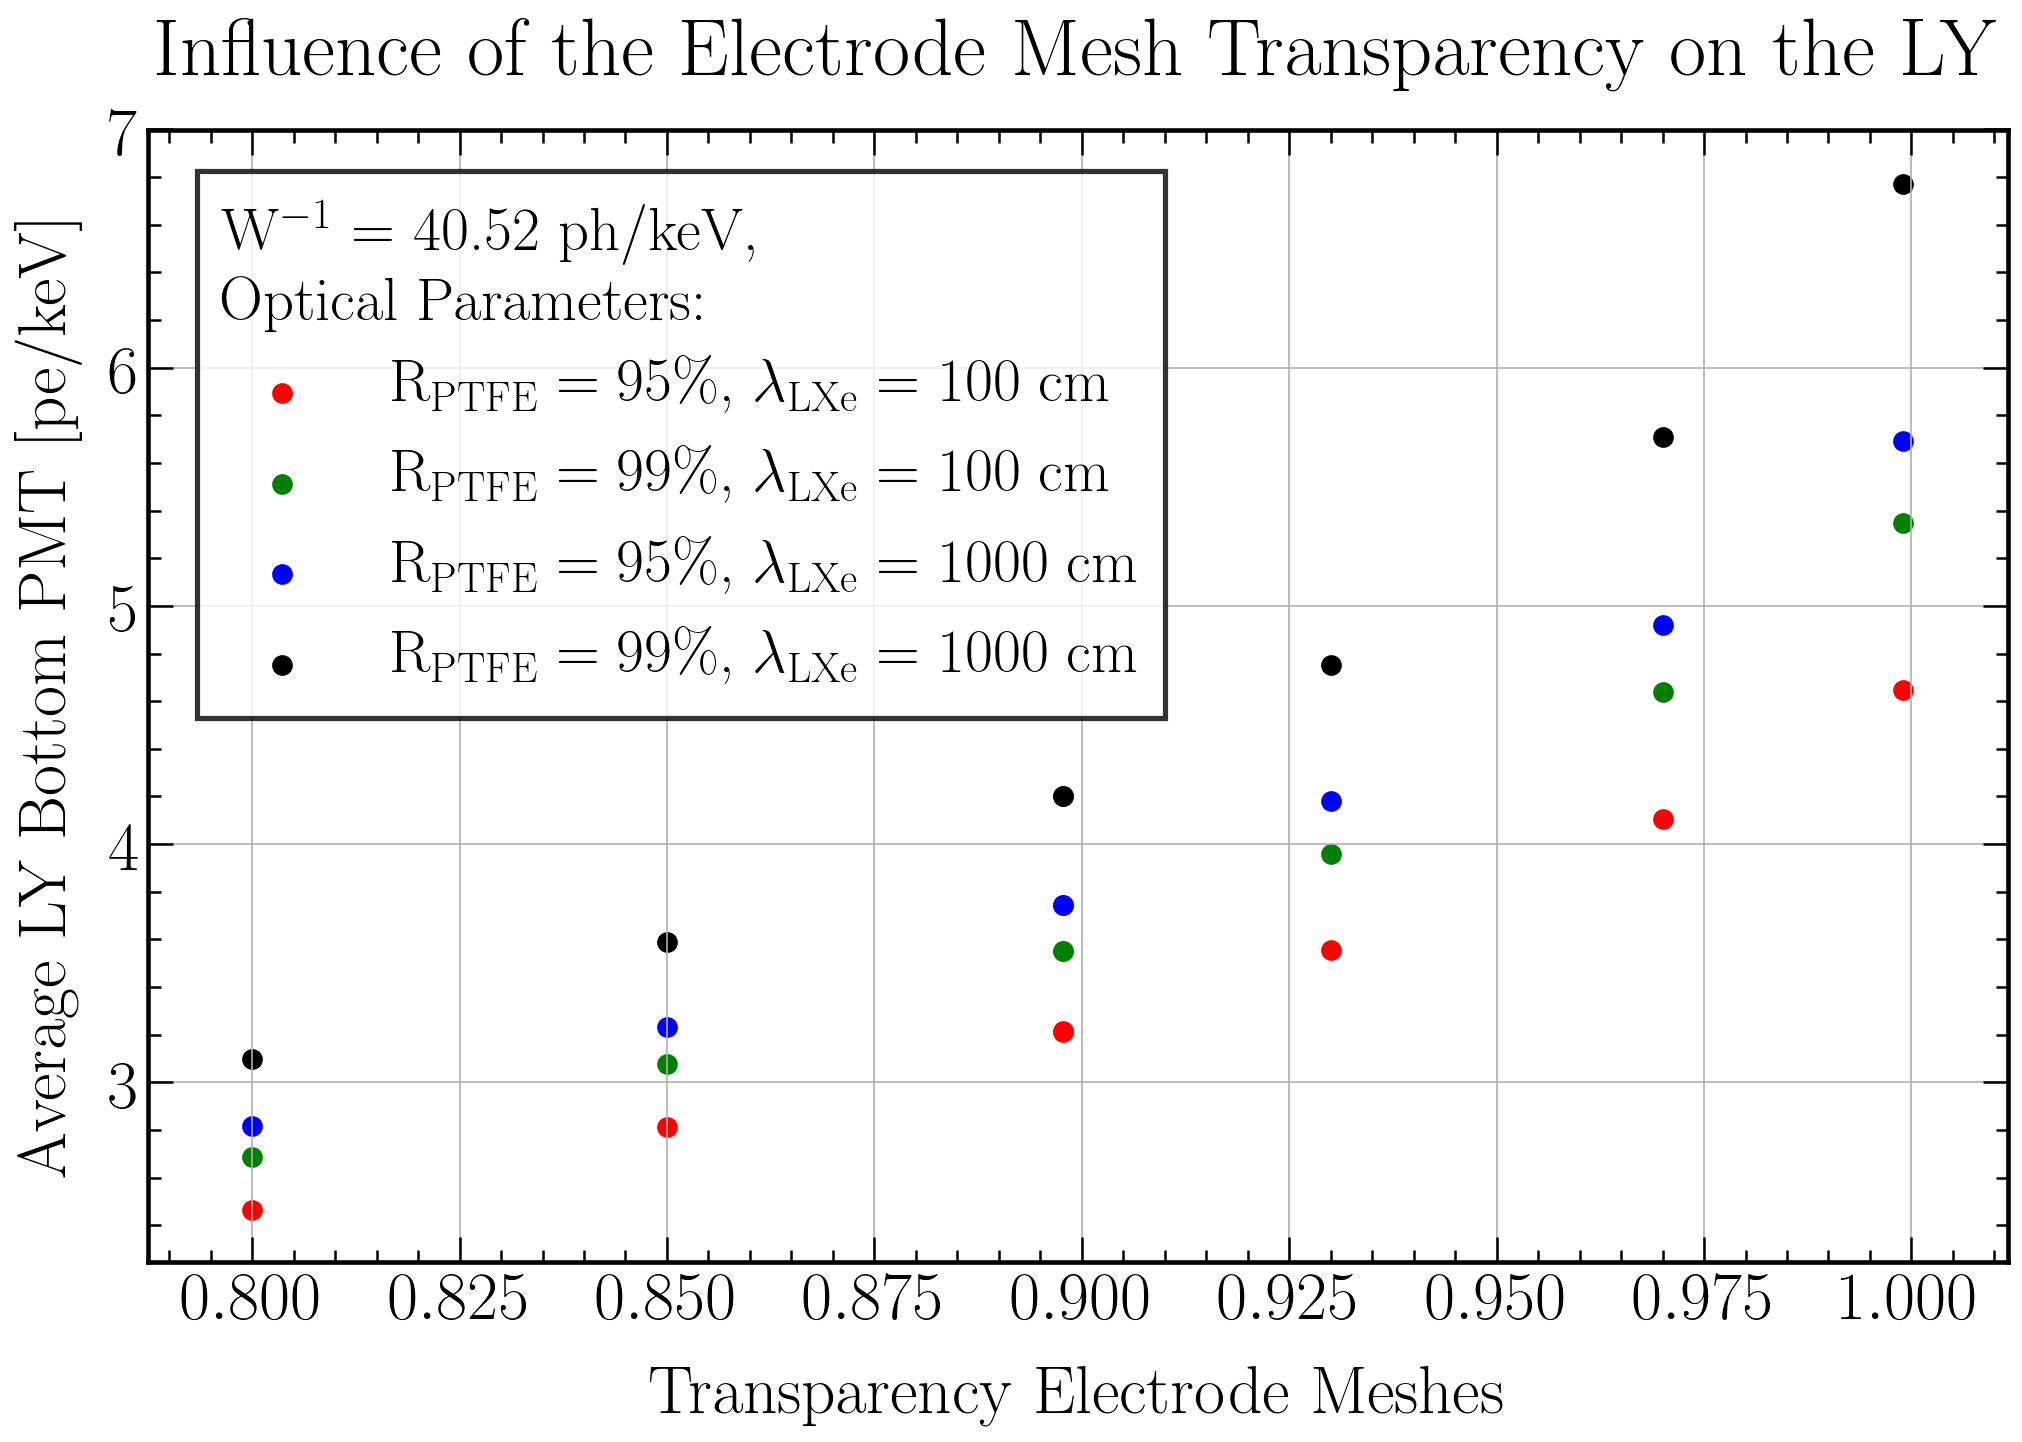

In [35]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the LY', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_LY_Bottom.png")
plt.show()

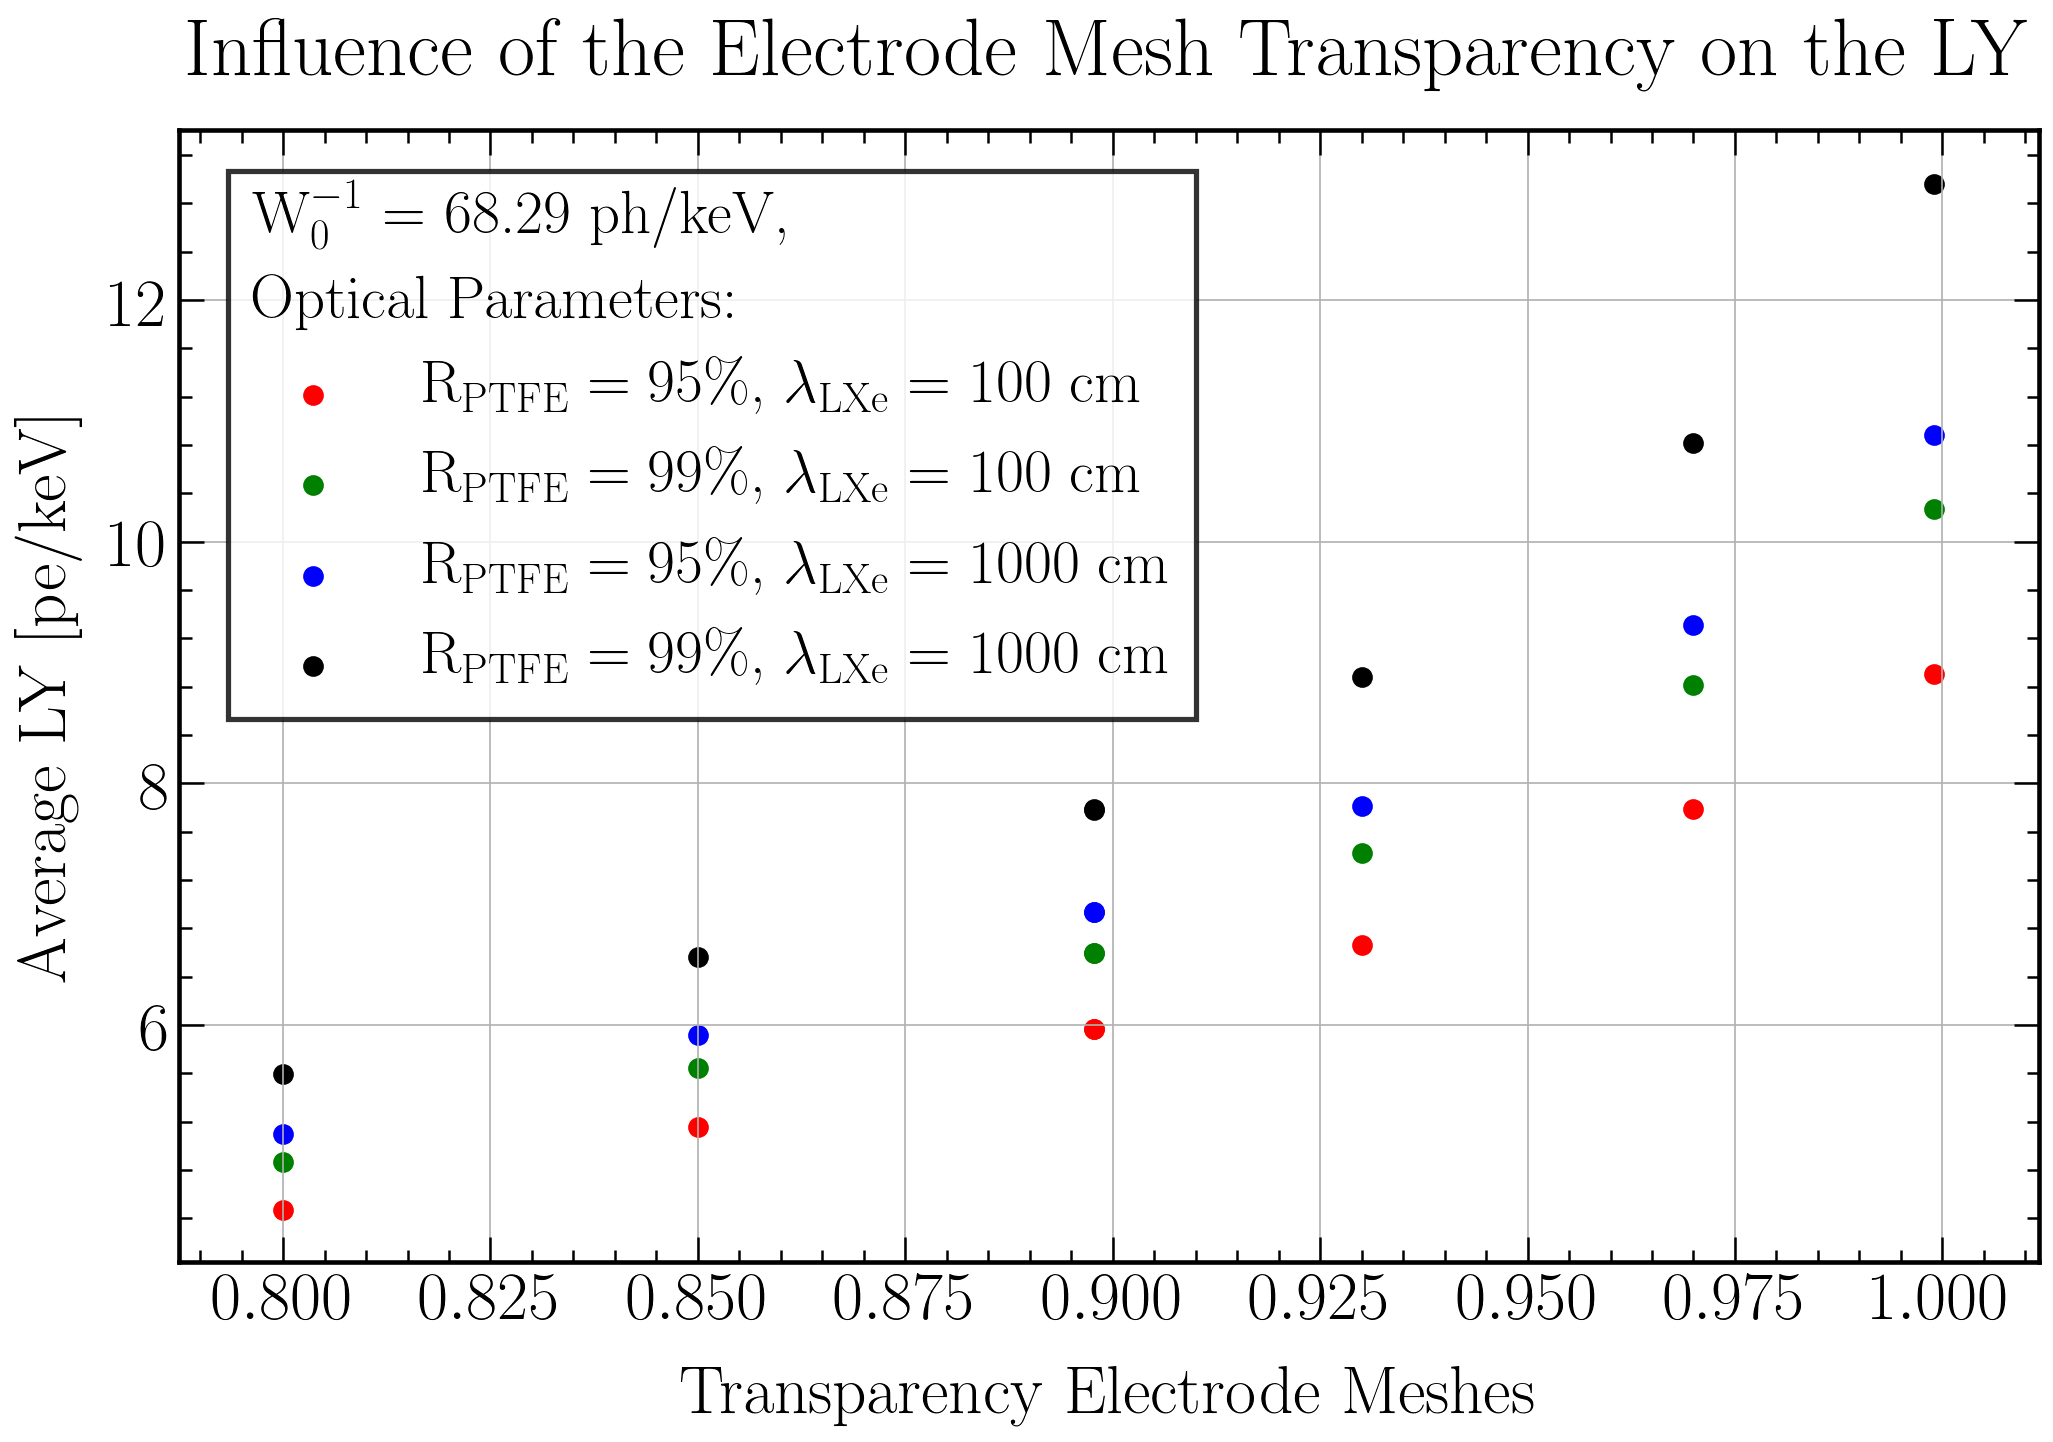

In [36]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the LY', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_LY0.png")
plt.show()

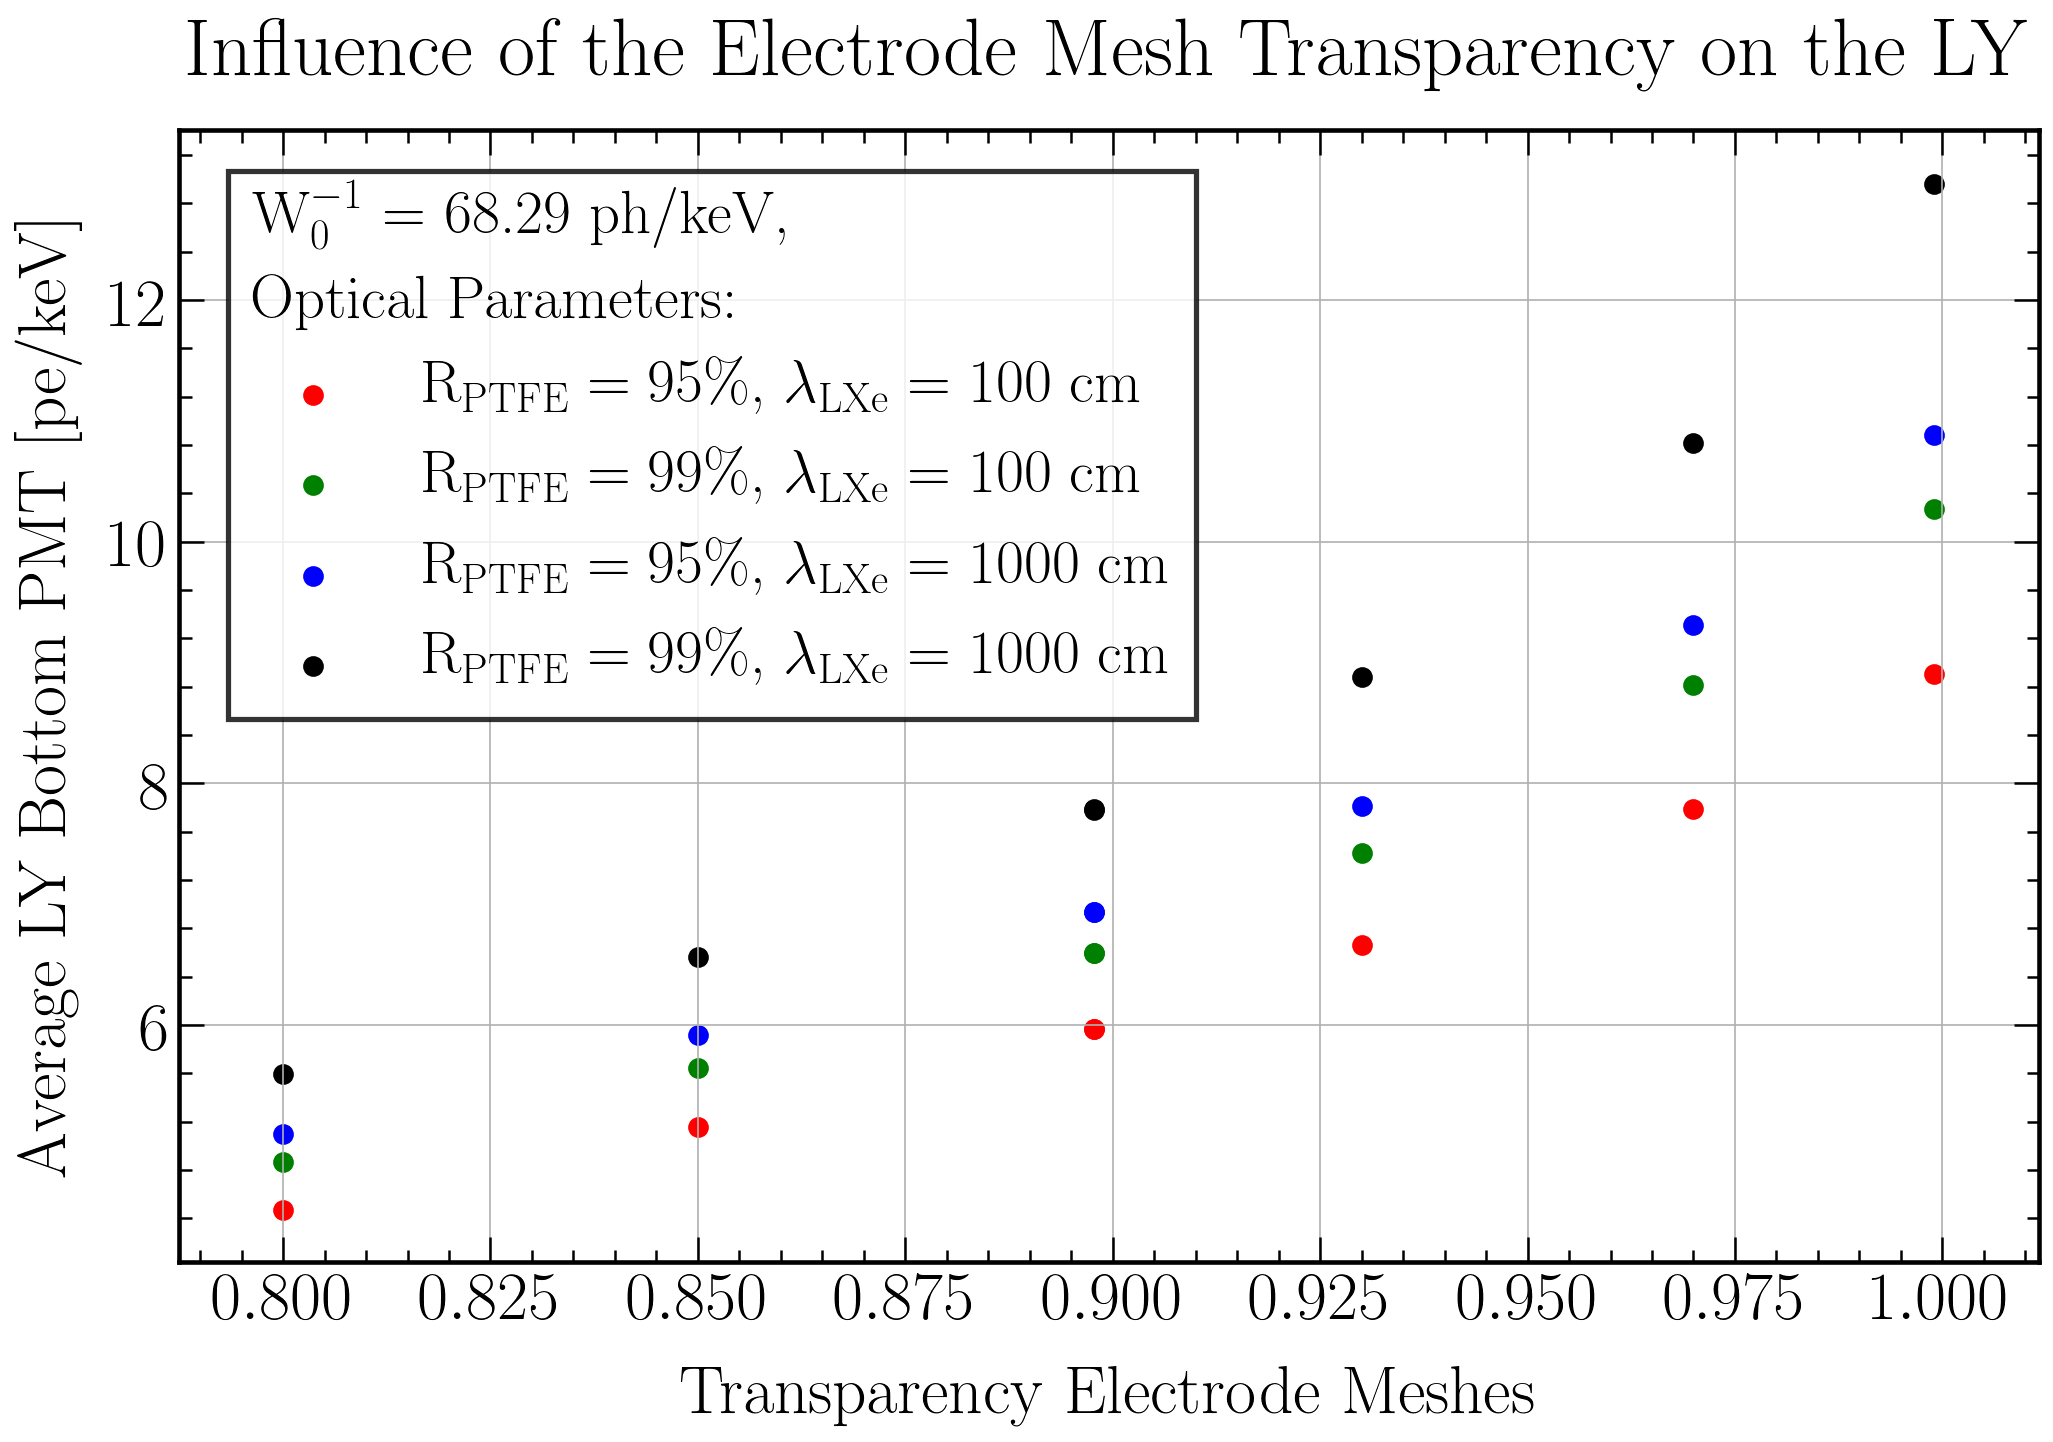

In [37]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80)

x = opticals["Tmesh"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80)

plt.xlabel('Transparency Electrode Meshes', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the Electrode Mesh Transparency on the LY', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_TranspMeshes_LY0_Bottom.png")
plt.show()